# Multi-Class Prediction of Cirrhosis 

Playground Series - Season 3, Episode 26
[This is a Kaggle Competition.](https://www.kaggle.com/competitions/playground-series-s3e26/overview)

Welcome to the 2023 Kaggle Playground Series! Thank you to everyone who participated in and contributed to Season 3 Playground Series so far. This is our last episode for the Season 3 and we wish you all a Happy New Year! Stay tuned for the new season next year!

### The Problem

The objective of this project is to use a multi-class approach to predict the outcomes of patients with cirrhosis. 

Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. Each time your liver is injured, it tries to repair itself. In the process, scar tissue forms. As the cirrhosis progresses, more and more scar tissue forms, making it difficult for the liver to function.

The target variable is a multi-class variable consisting of three unique values: `D` (death), `C` (censored), `CL` (censored due to liver transplantation). `C` indicates the patient was alive at `N_Days`, `CL` indicates the patient was alive at `N_Days` due to a liver transplant, and `D` indicates the patient was deceased at `N_Days`.

### Dataset Features

| Variable Name   | Description                                                                                                                                                              | Units   |
|-----------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------|
| id              | Unique Identifier                                                                                                                                                        |         |
| n_days          | number of days between registration and the earlier of death, transplantation or study analysis time (in July 1986)                                                      |         |
| status / target | status of the patient: `D` (death), `C` (censored), `CL` (censored due to liver transplantation)                                                                         |         |
| drug            | type of drug: D-penicillamine or placebo                                                                                                                                 |         |
| age             | age                                                                                                                                                                      | days    |
| sex             | M (male) or F (female)                                                                                                                                                   |         |
| ascites         | presence of ascites Y/N                                                                                                                                                  |         |
| hepatomegaly    | presence of hepatomegaly Y/N                                                                                                                                             |         |
| spiders         | presence of spiders Y/N                                                                                                                                                  |         |
| edema           | presence of edema N (no edema or diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy) |         |
| bilirubin       | serum bilirubin                                                                                                                                                          | mg/dl   |
| cholesterol     | serum cholesterol                                                                                                                                                        | mg/dl   |
| albumin         | albumin                                                                                                                                                                  | gm/dl   |
| copper          | urine copper                                                                                                                                                             | ug/day  |
| alk_phos        | alkaline phosphatase                                                                                                                                                     | u/liter |
| sgot            | serum glutamic oxaloacetic transaminase                                                                                                                                  | u/ml    |
| tryglicerides   | tryglicerides                                                                                                                                                            |         |
| platelets       | platelets per cubic                                                                                                                                                      | ml/1000 |
| prothrombin     | prothrombin time                                                                                                                                                         | s       |
| stage           | histologic stage of disease (1, 2, 3, 4)                                                                                                                                 |         |

### Frame Problem
- This is a supervised learning problem.
- This is a multi-class classification problem
- We'll be using batch learning and using the entire train data to train the model. The dataset is small enough for this purpose and will not overwhelm memory.

### Select a Performance Measure

Submissions are evaluated using the multi-class logarithmic loss. Each id in the test set had a single true class label, Status. For each id, you must submit a set of predicted probabilities for each of the three possible outcomes, e.g., Status_C, Status_CL, and Status_D. 

The submitted probabilities for a given row are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with max(min(p,1−10^−15), 10^−15).

### Check the Assumptions

### Load Workspace

In [176]:
import re
import datetime as dt
import warnings
import zipfile
import io
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, cross_val_predict
import optuna

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, log_loss

%matplotlib inline

### Load the Data

In [ ]:
train = pd.read_csv('playground-series-s3e26/train.csv')
test = pd.read_csv('playground-series-s3e26/test.csv')
sample_sub = pd.read_csv('playground-series-s3e26/sample_submission.csv')
cirrhosis = pd.read_csv('playground-series-s3e26/cirrhosis.csv')

train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()
cirrhosis.columns = cirrhosis.columns.str.lower()

In [ ]:
train.head()

### Preview the Data 

- There are 8323 records in the dataset.
- The dataset has 20 features.
- For a few columns between 1-2% of the records are missing. 
- All datatypes are appropriate.
- There are no duplicate rows.

In [ ]:
cirrhosis['id'] = np.arange(len(train), len(train) + len(cirrhosis))

In [ ]:
cirrhosis.info()

In [7]:
list1 = train.columns.tolist()
list2 = cirrhosis.columns.tolist()

# Check if the values are the same regardless of order
if sorted(list1) == sorted(list2):
    print("The lists have the same values.")
else:
    print("The lists have different values.")


The lists have the same values.


In [8]:
df = pd.concat([train, cirrhosis], axis=0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323 entries, 0 to 8322
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8323 non-null   int64  
 1   n_days         8323 non-null   int64  
 2   drug           8217 non-null   object 
 3   age            8323 non-null   int64  
 4   sex            8323 non-null   object 
 5   ascites        8217 non-null   object 
 6   hepatomegaly   8217 non-null   object 
 7   spiders        8217 non-null   object 
 8   edema          8323 non-null   object 
 9   bilirubin      8323 non-null   float64
 10  cholesterol    8189 non-null   float64
 11  albumin        8323 non-null   float64
 12  copper         8215 non-null   float64
 13  alk_phos       8217 non-null   float64
 14  sgot           8217 non-null   float64
 15  tryglicerides  8187 non-null   float64
 16  platelets      8312 non-null   float64
 17  prothrombin    8321 non-null   float64
 18  stage   

In [9]:
missing_percentage = (df.isnull().mean()).round(2)
missing_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing Percentage': missing_percentage.values,
    'Column Dtype': [df[col].dtype for col in missing_percentage.index.tolist()]
})

missing_cols = missing_df[missing_df['Missing Percentage'] > 0].Column.values.tolist()

print(missing_cols)

missing_df[missing_df['Missing Percentage'] > 0]

['drug', 'ascites', 'hepatomegaly', 'spiders', 'cholesterol', 'copper', 'alk_phos', 'sgot', 'tryglicerides']


Column  Missing Percentage Column Dtype
2            drug                0.01       object
5         ascites                0.01       object
6    hepatomegaly                0.01       object
7         spiders                0.01       object
10    cholesterol                0.02      float64
12         copper                0.01      float64
13       alk_phos                0.01      float64
14           sgot                0.01      float64
15  tryglicerides                0.02      float64

In [10]:
df.duplicated().sum()

0

### Data Cleaning

For missing values, given that only about 1-2% of values are missing, we'll use simple imputer to impute the mean for continuous variables and the mode for categorical variables.

**Features with Unique Values**

In [11]:
drop_unique_features = [
    col for col in df.columns if df[col].value_counts(dropna=False).shape[0] <= 1 or df[col].value_counts(dropna=False).shape[0] == df.shape[0]
]

print(drop_unique_features)

df = df.drop(columns=drop_unique_features)

**Fill Missing Values**

In [12]:
df['stage'] = df.stage.astype('object')
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=['number']).columns

df[cat_cols] = df[cat_cols].apply(lambda col: col.fillna(col.mode().iloc[0]))
df[num_cols] = df[num_cols].apply(lambda col: col.fillna(col.mean()))

### Data Exploration

In [13]:
deep_colors = [
    '#2e921b', '#7f1b92', '#4C72B0', '#55A868',
    '#C44E52', '#8172B2', '#CCB974', '#64B5CD'
]

In [14]:
def plot_data(
        data, column, plot_type='count',
        palette=deep_colors, figsize=(10,6)
):
    fig, ax = plt.subplots(figsize=figsize)
    if plot_type == 'count':
        sns.countplot(x=column, data=data, ax=ax, palette=palette[:len(data[column].unique())], hue=column, legend=False)
        ax.set_title(f"Count Plot of {column}", size=15)
        ax.set_xlabel(column, size=12, weight='bold')
        ax.set_ylabel("Count", size=12, weight='bold')
        total = len(data[column])
        for p in ax.patches:
            height = p.get_height()
            pct = 100 * height / total
            ax.annotate(f'{pct:.1f}%', (p.get_x()+0.3, height+5), fontsize=12)
    elif plot_type == 'swarm':
        sns.swarmplot(y=column, data=data, ax=ax)
        ax.set_title(f"Swarm Plot of {column}", size=15)
        ax.set_xlabel(column, size=12, weight='bold')
        ax.set_ylabel("Value", size=12, weight='bold')
    elif plot_type == 'dist':
        sns.histplot(data=data, x=column, ax=ax, kde=True)
        ax.set_title(f"Distribution Plot of {column}", size=15)
        ax.set_xlabel(column, size=12, weight='bold')
        ax.set_ylabel("Frequency", size=12, weight='bold')
    elif plot_type == 'stacked':
        groupby_df = data.groupby(column)['Loan_Status'].value_counts(normalize=True).unstack()
        groupby_df.plot(kind='bar', stacked=True, ax=ax, color=palette)
        ax.set_title(f"Stacked Bar Plot of {column}", size=15, weight='bold')
        ax.set_xlabel(column, size=12, weight='bold')
        ax.set_ylabel("Proportion", size=12, weight='bold')
        ax.legend(title="Loan Status", loc='upper right')
        for i in range(groupby_df.shape[0]):
            for j in range(groupby_df.shape[1]):
                pct = groupby_df.iloc[i, j] * 100
                ax.annotate(f"{pct:.1f}%", xy=(i, groupby_df.iloc[i, :j].sum() + pct/2),
                            ha='center', va='center', color='white', weight='bold')
    else:
        print(f"Invalid plot type: {plot_type}")

    plt.show()

**Review Categorical Variables**

The Cirrhosis status feature is imbalanced and this might affect predictions. Over 60% of records have a `C` class status, nearly 35% have a `D` class rating, and under 5% have a `CL` rating. 

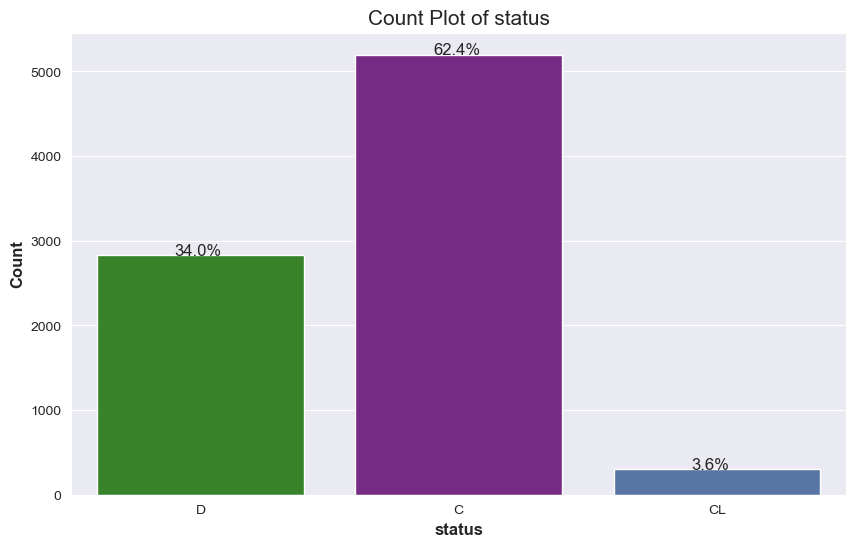

In [15]:
plot_data(df, 'status', plot_type='count')

Nearly half of the individuals in the dataset used the drug `D-penicillamine` which is used in the management of certain cases of cirrhosis. The remainder were treated with a placebo.

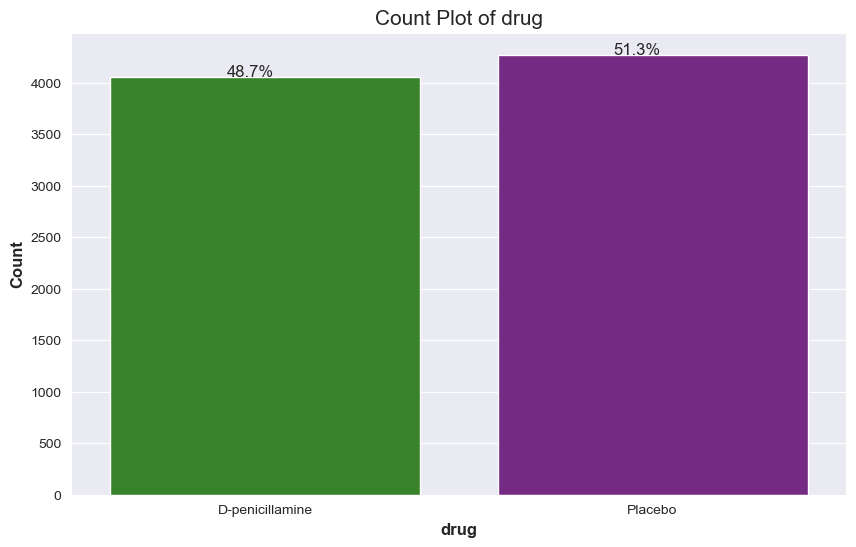

In [16]:
plot_data(df, 'drug', plot_type='count')

The trial is overrepresented by female participants.

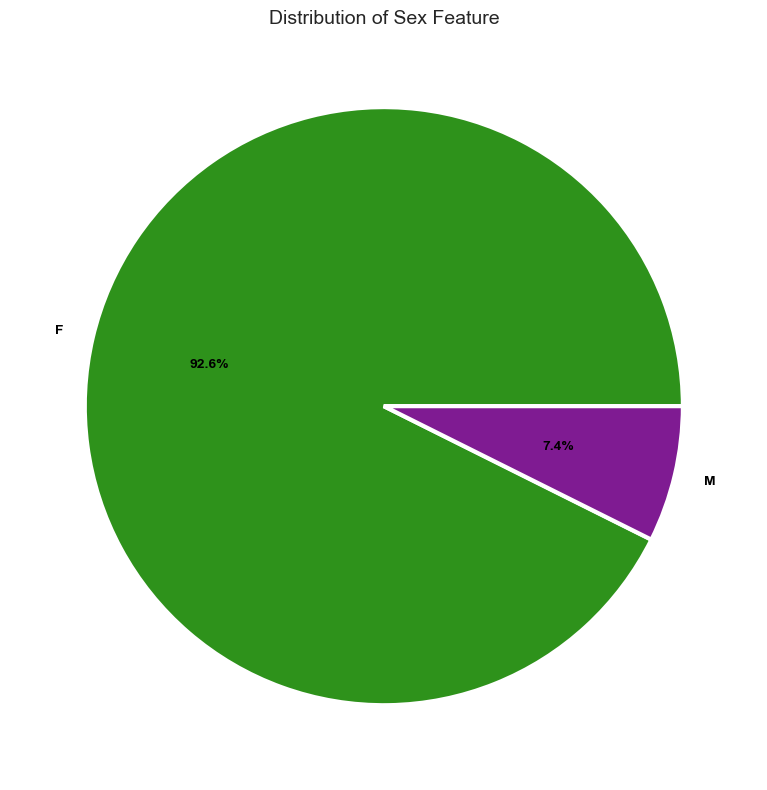

In [17]:
# Count the number of occurrences for each feature
counts = df['sex'].value_counts()

color_pie= ['#2e921b', '#7f1b92']

# Create a pie plot
fig, ax = plt.subplots(figsize=(12,8))
ax.pie(
    counts, labels=counts.index, autopct='%.1f%%', colors=color_pie,
    wedgeprops={'linewidth': 3.0, 'edgecolor': '#FFFFFF'},
    textprops={'size': 'medium', 'color':'#000000', 'weight':'bold'}
)
ax.set_title('Distribution of Sex Feature', fontsize=14)
plt.tight_layout()

Ascites is a medical term used to describe the abnormal accumulation of fluid in the abdominal cavity, specifically in the peritoneal space. The peritoneal cavity is the space between the abdominal organs and the abdominal wall. 

Cirrhosis is a frequent cause of ascites. As cirrhosis progresses, it can lead to increased pressure in the veins that bring blood to the liver (portal hypertension), resulting in fluid leakage into the abdominal cavity.

In this trial, under 5% of individuals have ascites.

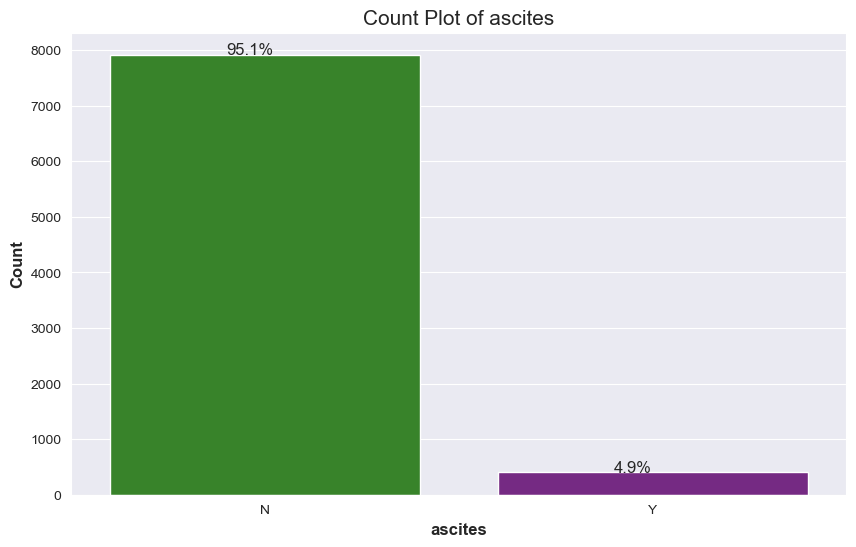

In [18]:
plot_data(df, 'ascites', plot_type='count')

Hepatomegaly is a medical term used to describe an enlarged liver. In advanced stages of liver disease, including cirrhosis, the liver may become enlarged initially but can shrink in later stages. 

While ascites is more infrequent in the dataset, hepatomegaly is more frequent, represented in nearly 52% of individuals in the dataset.

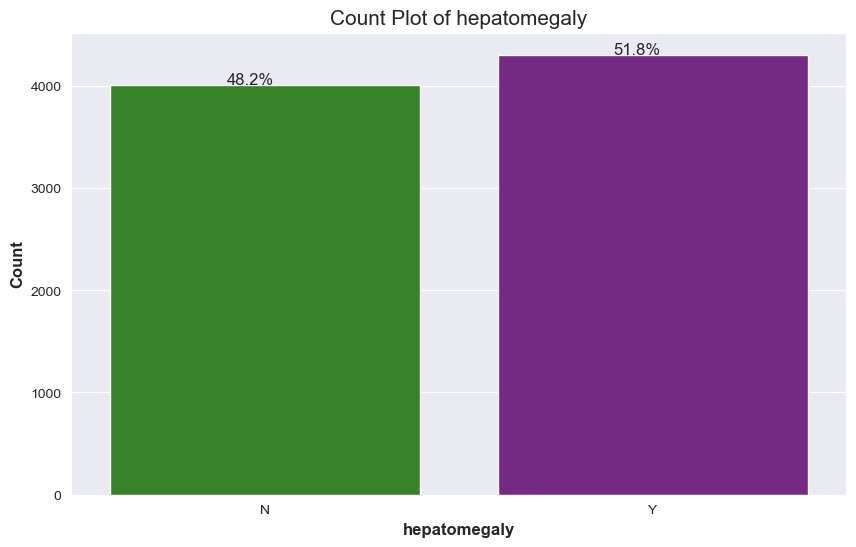

In [19]:
plot_data(df, 'hepatomegaly', plot_type='count')

"Spider angiomas," also known as "spider nevi" or "vascular spiders," are skin lesions that can be associated with liver cirrhosis. These spider-like, reddish or bluish lesions have a central arteriole (small artery) surrounded by smaller blood vessels, giving them a spider-like appearance. They are commonly found on the face, neck, upper trunk, and arms.

The presence of spider angiomas in individuals with cirrhosis is often attributed to increased pressure in the blood vessels supplying the liver, a condition known as portal hypertension. Portal hypertension is a consequence of advanced liver disease, especially cirrhosis, and it results from the scarring (fibrosis) and distortion of the liver's vascular architecture.

In our dataset, only a quarter of individuals have spiders.

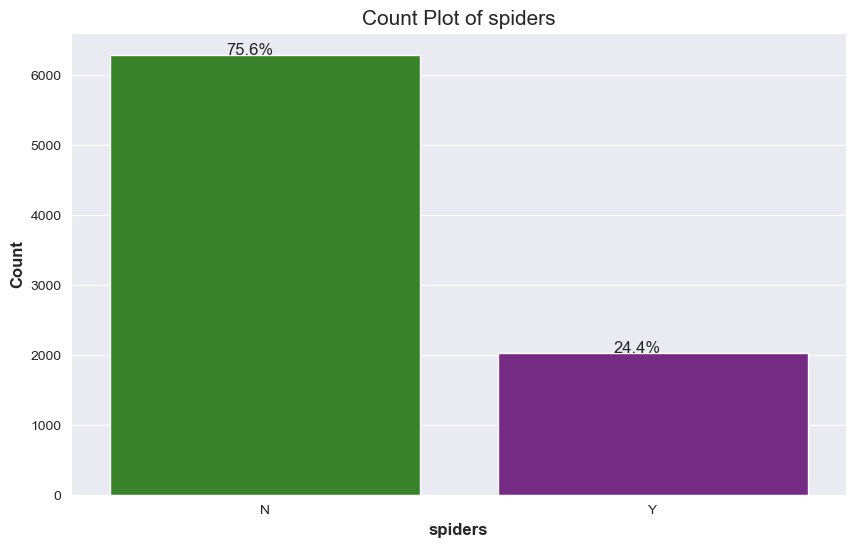

In [20]:
plot_data(df, 'spiders', plot_type='count')

Edema is a medical term used to describe the abnormal accumulation of fluid in the body's tissues, leading to swelling. This can occur in various parts of the body, but it is most commonly observed in the extremities (such as the legs, ankles, and feet) and the abdomen.

Conditions such as cirrhosis can cause fluid to accumulate in the abdomen (ascites) and other parts of the body.

In our dataset, there is no presence of edema or diuretic therapy for edema in 90% of respondents (`N`). For 5% of respondents, edema is either present without diuretics, or it has been resolved by diuretics (`S`) and for 4.4% of respondents, edema is present despite diuretic therapy (`Y`).

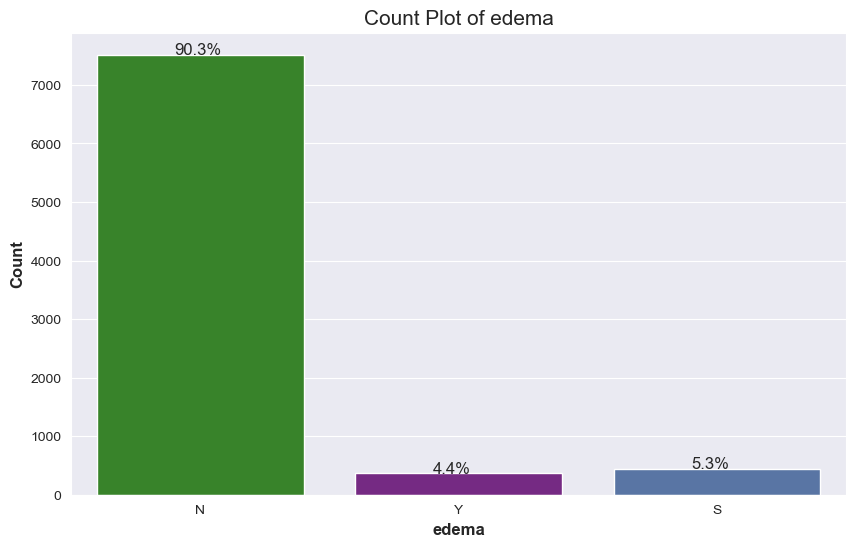

In [21]:
plot_data(df, 'edema', plot_type='count')

Histologic staging of cirrhosis refers to the classification of cirrhosis based on the extent of fibrosis (scarring) within the liver tissue. The histologic staging is often determined through a liver biopsy, which involves taking a small sample of liver tissue for microscopic examination. Staging helps assess the severity of liver fibrosis and guides treatment decisions. 

The most commonly used staging system is the METAVIR scoring system and the Ishak or Batts-Ludwig modifications. The stages are typically numbered from F0 to F4:
- `F0 - No Fibrosis`: There is no evidence of fibrosis in the liver tissue.
- `F1 - Portal Fibrosis`: Minimal fibrosis confined to the portal areas.
- `F2 - Periportal Fibrosis`: Fibrosis extends beyond the portal areas but does not yet form bridges between adjacent portal areas.
- `F3 - Septal Fibrosis`: Bridging fibrosis is observed, connecting portal areas with incomplete separation of liver tissue.
- `F4 - Cirrhosis`: There is extensive bridging fibrosis, resulting in the formation of regenerative nodules and distortion of the liver architecture. This stage represents advanced cirrhosis.

In our exploration, it will be important to consider the relationship between other features and stages.

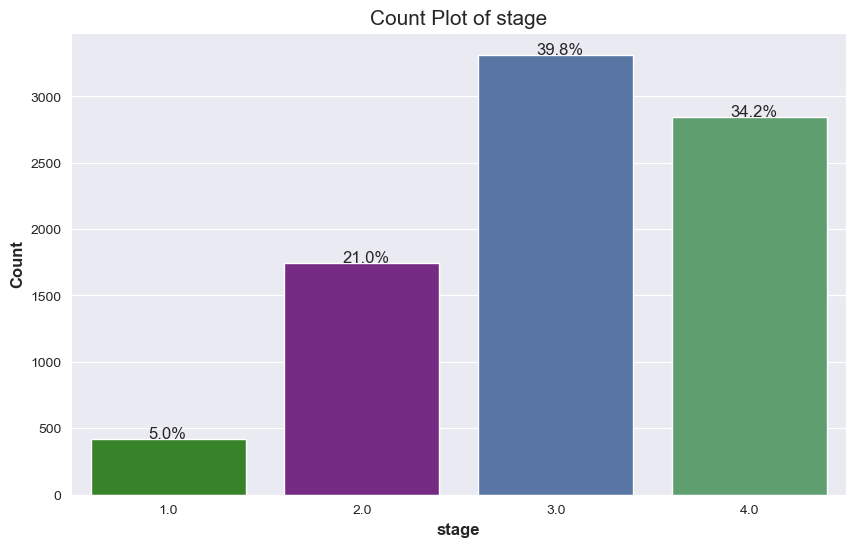

In [22]:
plot_data(df, 'stage', plot_type='count')

**Review of Numeric Features**

In [23]:
def plot_hist_box(data, column):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4), sharey=False)
    sns.histplot(data=data, x=column, bins=30, kde=True, ax=ax1, color='#2c921b')
    sns.boxplot(data=data, x=column, ax=ax2, color='#921b8b')
    plt.suptitle(f"Histogram and Box Plot of {column}", size=15, weight='bold')
    ax1.set_xlabel(column, size=12, weight='bold')
    ax1.set_ylabel("Frequency", size=12, weight='bold')
    ax2.set_xlabel(column, size=12, weight='bold')
    ax2.set_ylabel("Value", size=12, weight='bold')
    plt.show()

`n_days` is the feature describing the number of days between registration for the trial and either death, transplantation and the end of the study trial. This feature is slightly right skewed. We will conduct outlier detection on this feature to determine values outside the norm.

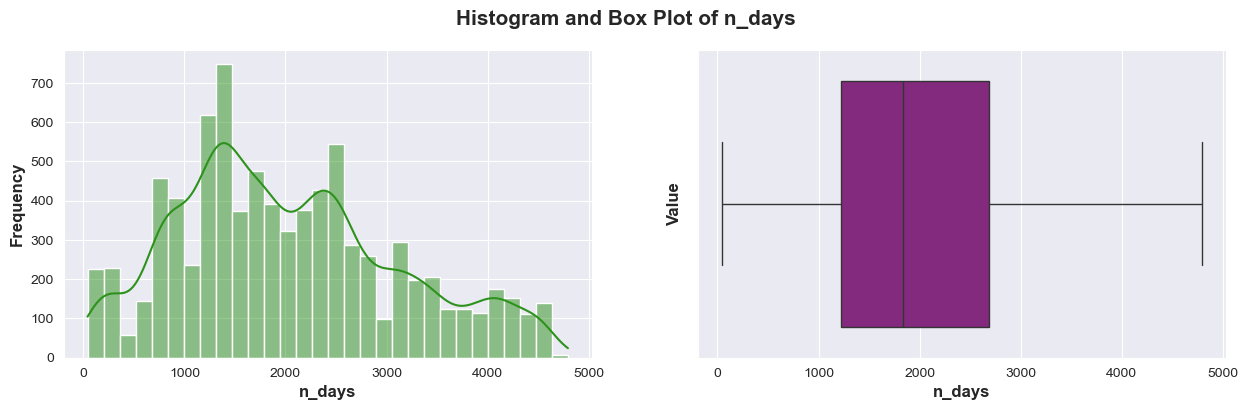

In [24]:
plot_hist_box(df, 'n_days')

**Outlier Detection**

1. Z-Score: The Z-score measures how far a data point is from the mean in terms of standard deviations. Typically, points with a Z-score greater than a certain threshold are considered outliers. For our test, we'll use a threshold of 3. 

In [40]:
z_scores = np.abs(stats.zscore(df.n_days))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

Number of Z-Score Outliers: 0


2. Interquartile Range (IQR): The IQR is the range between the first quartile (Q1) and the third quartile (Q3). Data points outside a certain range beyond the quartiles are considered outliers.

In [39]:
q1, q3 = np.percentile(df.n_days, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.n_days < lower_bound) | (df.n_days > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

Number of IQR Outliers: 0


The Age feature, which tracks the age of participants in days is normally distributed. The age range of participants is 30 to 80 years old, with most participants age hovering around the median age of 50.

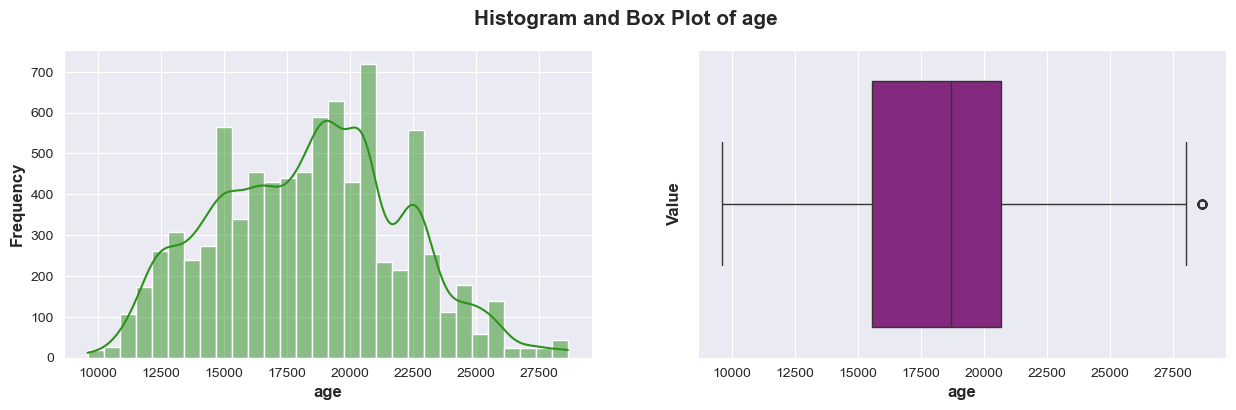

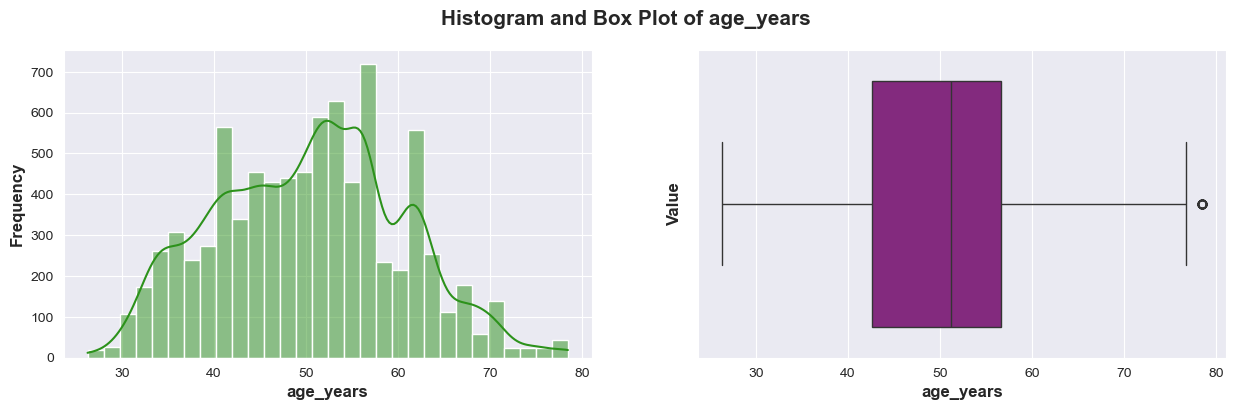

In [32]:
df['age_years'] = df['age'] / 365.25

for col in df.columns:
    if col in ['age', 'age_years']:
        plot_hist_box(df, col)

Bilirubin is a yellow pigment produced during the breakdown of red blood cells, and impaired liver function can lead to its accumulation, causing jaundice. Elevated levels of bilirubin may be observed in cirrhosis. 

This feature is severely right skewed, and we'll use outlier detection to identify which values are outside the norm.

The IQR outlier detection detects about 3x more outliers than the z-score technique with threshold 3.

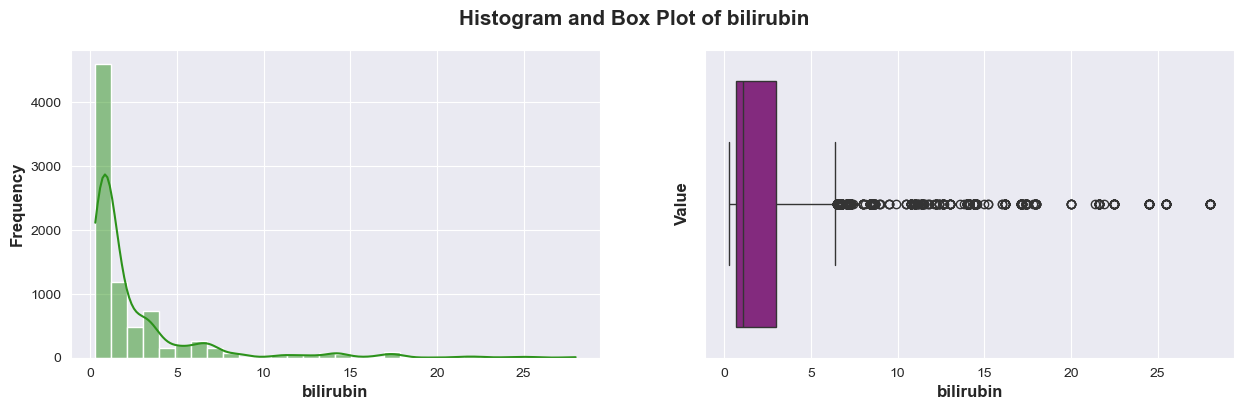

In [33]:
plot_hist_box(df, 'bilirubin')

In [41]:
z_scores = np.abs(stats.zscore(df.bilirubin))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'bilirubin'].describe())

Number of Z-Score Outliers: 259

Description
count    259.000000
mean      18.954826
std        3.970541
min       14.400000
25%       16.200000
50%       17.400000
75%       21.600000
max       28.000000
Name: bilirubin, dtype: float64


In [42]:
q1, q3 = np.percentile(df.bilirubin, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.bilirubin < lower_bound) | (df.bilirubin > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'bilirubin'].describe())

Number of IQR Outliers: 846

Description
count    846.000000
mean      12.073286
std        5.543399
min        6.500000
25%        7.100000
50%       11.050000
75%       14.500000
max       28.000000
Name: bilirubin, dtype: float64


Blood cholesterol is a waxy, fat-like substance made by the liver. Cholesterol levels may be altered in cirrhosis, but the changes can vary, ranging from decreased to elevated levels.

Our feature is clearly right-skewed, indicating that most participants have a lower cholesterol level. The IQR outlier detection detects about 2x more outliers than the z-score technique with threshold 3.

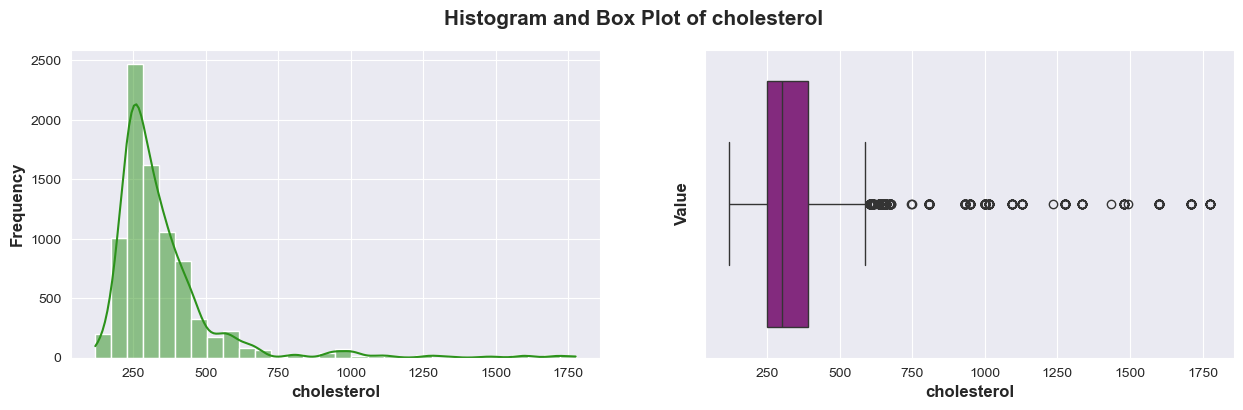

In [43]:
plot_hist_box(df, 'cholesterol')

In [45]:
z_scores = np.abs(stats.zscore(df.cholesterol))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'cholesterol'].describe())

Number of Z-Score Outliers: 227

Description
count     227.000000
mean     1246.731278
std       284.695744
min       950.000000
25%      1000.000000
50%      1128.000000
75%      1480.000000
max      1775.000000
Name: cholesterol, dtype: float64


In [46]:
q1, q3 = np.percentile(df.cholesterol, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.cholesterol < lower_bound) | (df.cholesterol > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'cholesterol'].describe())

Number of IQR Outliers: 525

Description
count     525.000000
mean      936.365714
std       339.393357
min       604.000000
25%       652.000000
50%       932.000000
75%      1092.000000
max      1775.000000
Name: cholesterol, dtype: float64


Albumin is a protein produced by the liver, and its levels tend to decrease in cirrhosis. Lower albumin levels can contribute to the development of edema (fluid retention) and ascites.

This feature is slightly left-skewed. From our outlier analysis, the outliers fall on both ends of the distribution. The IQR outlier detection detects about 1.7x more outliers than the z-score technique with threshold 3.

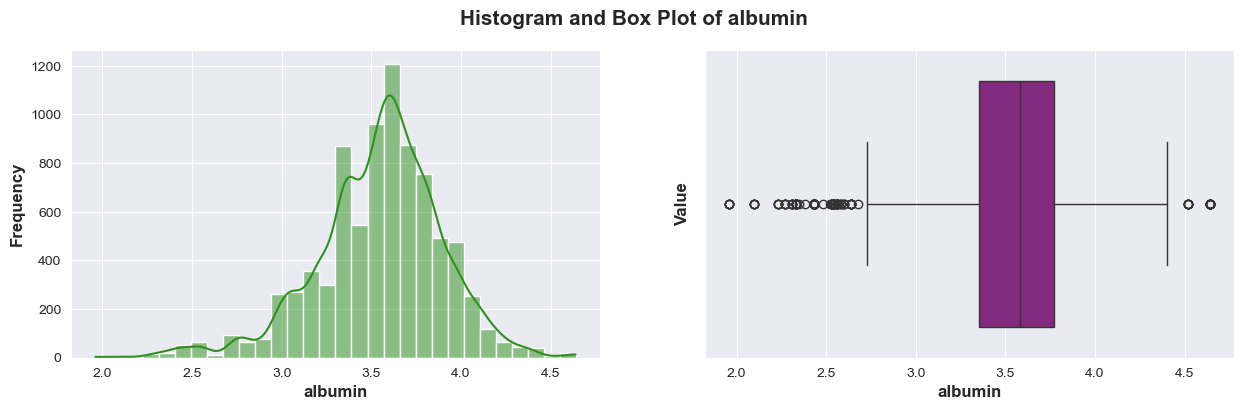

In [47]:
plot_hist_box(df, 'albumin')

In [48]:
z_scores = np.abs(stats.zscore(df.albumin))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'albumin'].describe())

Number of Z-Score Outliers: 116

Description
count    116.000000
mean       2.761293
std        0.894548
min        1.960000
25%        2.330000
50%        2.430000
75%        2.430000
max        4.640000
Name: albumin, dtype: float64


In [49]:
q1, q3 = np.percentile(df.albumin, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.albumin < lower_bound) | (df.albumin > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'albumin'].describe())

Number of IQR Outliers: 198

Description
count    198.000000
mean       2.746414
std        0.770106
min        1.960000
25%        2.430000
50%        2.530000
75%        2.560000
max        4.640000
Name: albumin, dtype: float64


Chronic copper toxicity primarily affects the liver because it is the first site of copper deposition after it enters the blood. Extra copper in the liver overflows and builds up in the kidneys, brain, and eyes. This extra copper can kill liver cells and cause nerve damage.

The copper feature is right-skewed, favouring values between 0 and 100. The IQR outlier detection detects about 4x more outliers than the z-score technique with threshold 3.

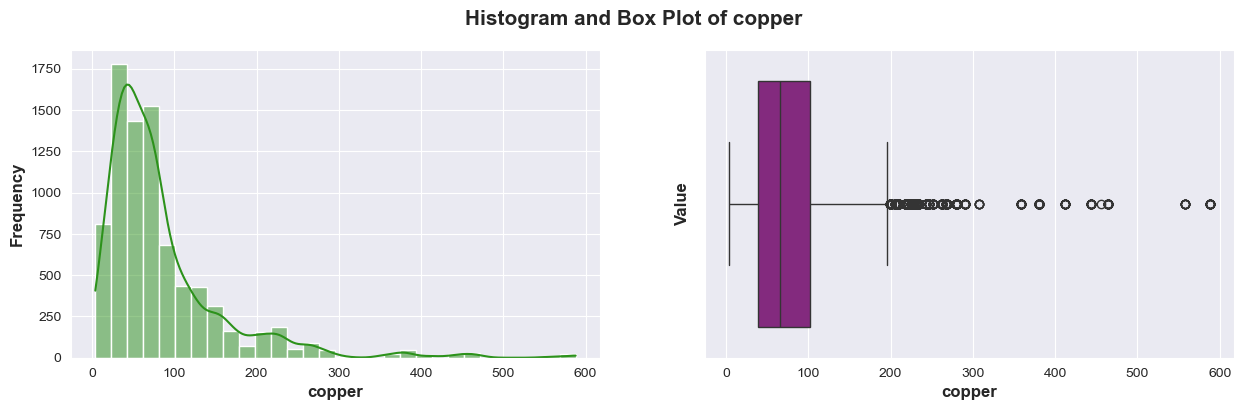

In [50]:
plot_hist_box(df, 'copper')

In [51]:
z_scores = np.abs(stats.zscore(df.copper))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'copper'].describe())

Number of Z-Score Outliers: 158

Description
count    158.000000
mean     438.860759
std       74.983265
min      358.000000
25%      380.000000
50%      412.000000
75%      464.000000
max      588.000000
Name: copper, dtype: float64


In [52]:
q1, q3 = np.percentile(df.copper, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.copper < lower_bound) | (df.copper > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'copper'].describe())

Number of IQR Outliers: 693

Description
count    693.000000
mean     280.963925
std       96.051137
min      199.000000
25%      219.000000
50%      243.000000
75%      290.000000
max      588.000000
Name: copper, dtype: float64


Alkaline phosphatase is an enzyme found in the liver, bones, and other tissues. Elevated levels of alkaline phosphatase in the blood may indicate liver damage or obstruction of bile flow. Alkaline phosphatase levels can be elevated in cirrhosis, particularly when there is cholestasis (impaired bile flow). Elevated Alk Phos may also indicate biliary obstruction.

The feature is significantly right-skewed. The IQR outlier detection detects about 4x more outliers than the z-score technique with threshold 3.

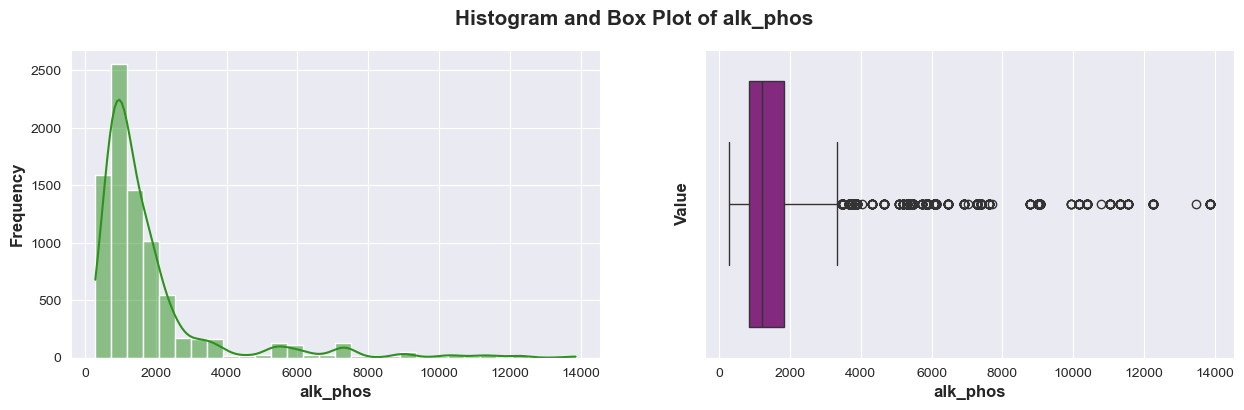

In [59]:
plot_hist_box(df, 'alk_phos')

In [60]:
z_scores = np.abs(stats.zscore(df.alk_phos))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'alk_phos'].describe())

Number of Z-Score Outliers: 201

Description
count      201.000000
mean     10453.204975
std       1703.027463
min       7622.800000
25%       9066.800000
50%      10396.800000
75%      11552.000000
max      13862.400000
Name: alk_phos, dtype: float64


In [61]:
q1, q3 = np.percentile(df.alk_phos, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.alk_phos < lower_bound) | (df.alk_phos > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'alk_phos'].describe())

Number of IQR Outliers: 829

Description
count      829.000000
mean      6683.706634
std       2571.380934
min       3472.000000
25%       5184.000000
50%       6064.800000
75%       7394.800000
max      13862.400000
Name: alk_phos, dtype: float64


SGOT is an enzyme found in the liver and other tissues. Elevated SGOT levels may indicate liver inflammation or damage. However, SGOT is not specific to the liver, and other conditions can contribute to elevated levels.

The feature is slightly right-skewed, with IQR outlier detection detecting about 2x more outliers than the z-score technique with a threshold > 3. 

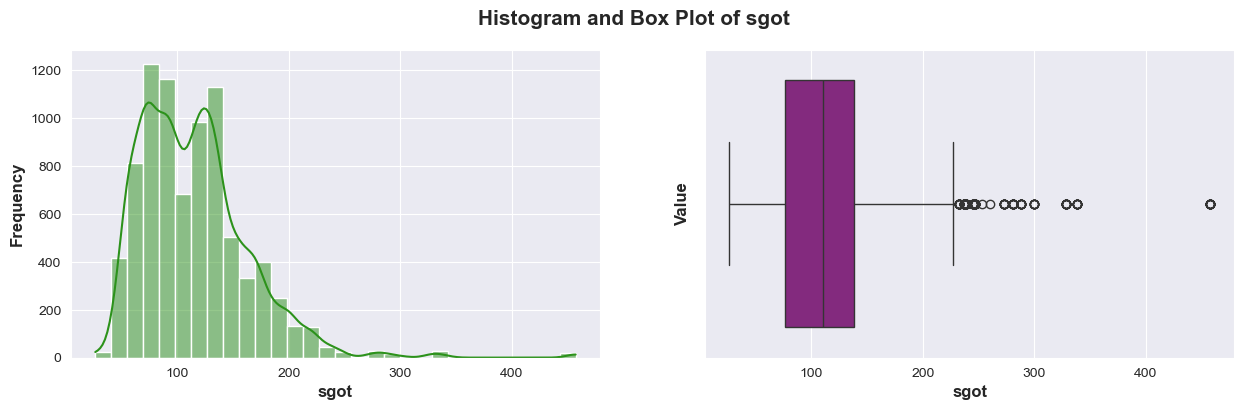

In [62]:
plot_hist_box(df, 'sgot')

In [63]:
z_scores = np.abs(stats.zscore(df.sgot))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'sgot'].describe())

Number of Z-Score Outliers: 87

Description
count     87.000000
mean     334.010920
std       67.071913
min      272.800000
25%      280.550000
50%      328.600000
75%      338.000000
max      457.250000
Name: sgot, dtype: float64


In [64]:
q1, q3 = np.percentile(df.sgot, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.sgot < lower_bound) | (df.sgot > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'sgot'].describe())

Number of IQR Outliers: 158

Description
count    158.000000
mean     291.486076
std       68.637883
min      232.500000
25%      238.700000
50%      272.800000
75%      328.600000
max      457.250000
Name: sgot, dtype: float64


Triglyceride molecules represent the major form of storage and transport of fatty acids within cells and in the plasma. The liver is the central organ for fatty acid metabolism. Elevated triglyceride levels are not typically a direct consequence of cirrhosis. However, cirrhosis can be associated with metabolic changes, and abnormalities in lipid metabolism may be observed.

The feature is slightly right-skewed, with IQR outlier detection detecting about 3x more outliers than the z-score technique with a threshold > 3. 

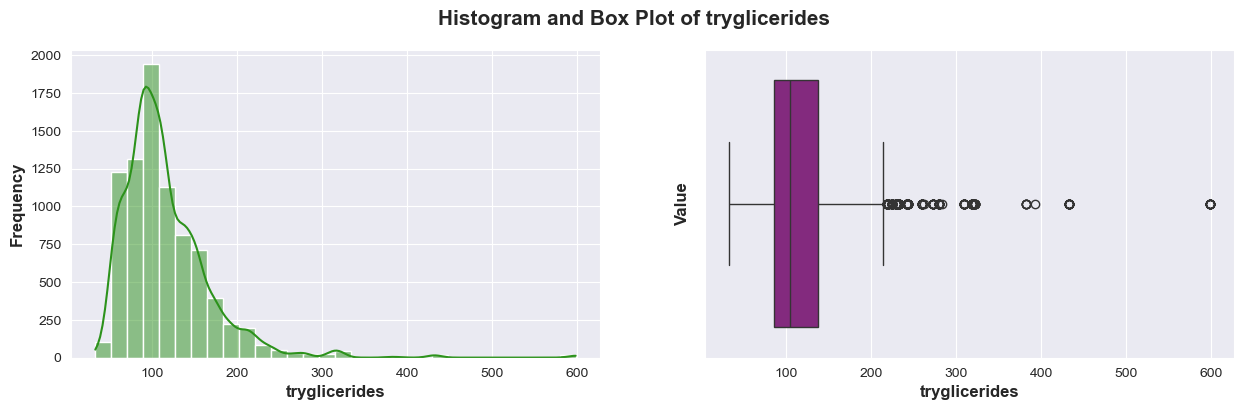

In [66]:
plot_hist_box(df, 'tryglicerides')

In [67]:
z_scores = np.abs(stats.zscore(df.tryglicerides))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'tryglicerides'].describe())

Number of Z-Score Outliers: 121

Description
count    121.000000
mean     361.561983
std       97.825686
min      280.000000
25%      309.000000
50%      318.000000
75%      432.000000
max      598.000000
Name: tryglicerides, dtype: float64


In [68]:
q1, q3 = np.percentile(df.tryglicerides, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.tryglicerides < lower_bound) | (df.tryglicerides > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'tryglicerides'].describe())

Number of IQR Outliers: 319

Description
count    319.000000
mean     283.545455
std       86.560138
min      218.000000
25%      229.000000
50%      243.000000
75%      309.000000
max      598.000000
Name: tryglicerides, dtype: float64


Thrombocytopenia (low platelet count) is a common finding in cirrhosis. As the liver becomes cirrhotic, it may produce fewer platelets, and there may also be increased sequestration of platelets in the spleen.

This feature is generally normally distributed, with a few values extending rightward. IQR outlier detection detects about 2.5x more values than the z-score technique with a threshold > 3.

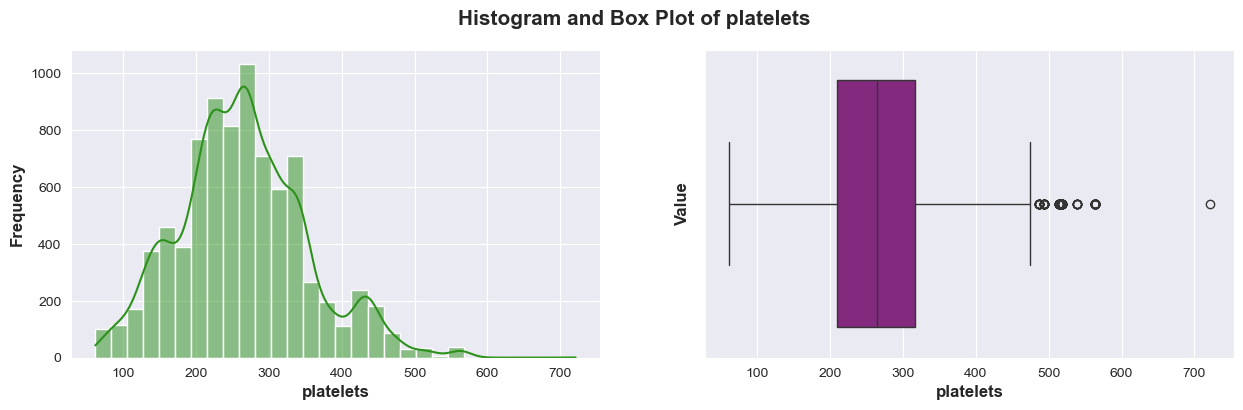

In [69]:
plot_hist_box(df, 'platelets')

In [70]:
z_scores = np.abs(stats.zscore(df.platelets))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'platelets'].describe())

Number of Z-Score Outliers: 44

Description
count     44.000000
mean     563.318182
std       25.706549
min      539.000000
25%      563.000000
50%      563.000000
75%      563.000000
max      721.000000
Name: platelets, dtype: float64


In [71]:
q1, q3 = np.percentile(df.platelets, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.platelets < lower_bound) | (df.platelets > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'platelets'].describe())

Number of IQR Outliers: 105

Description
count    105.000000
mean     528.857143
std       35.146241
min      487.000000
25%      493.000000
50%      518.000000
75%      563.000000
max      721.000000
Name: platelets, dtype: float64


Prothrombin is a protein involved in blood clotting. In cirrhosis, the liver's ability to produce clotting factors is compromised, leading to an increased PT. Prolonged prothrombin time is a common finding in advanced liver disease and can contribute to an increased risk of bleeding.

The feature is right-skewed with IQR outlier detection detecting about 2x more outliers than the z-score technique with a threshold > 3.

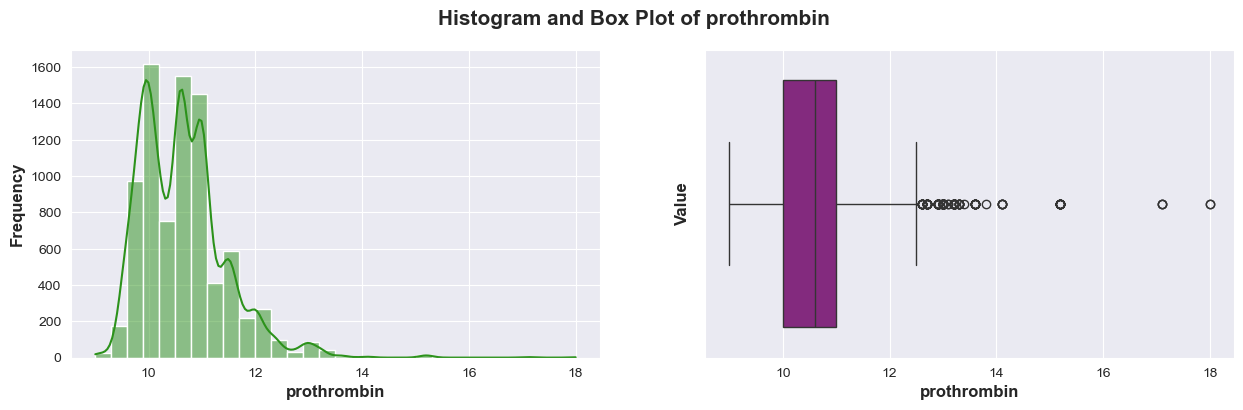

In [72]:
plot_hist_box(df, 'prothrombin')

In [73]:
z_scores = np.abs(stats.zscore(df.prothrombin))
threshold = 3

outliers = np.where(z_scores > threshold)[0]
print("Number of Z-Score Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'prothrombin'].describe())

Number of Z-Score Outliers: 80

Description
count    80.000000
mean     13.918750
std       1.172911
min      13.100000
25%      13.200000
50%      13.300000
75%      14.100000
max      18.000000
Name: prothrombin, dtype: float64


In [74]:
q1, q3 = np.percentile(df.prothrombin, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = np.where((df.prothrombin < lower_bound) | (df.prothrombin > upper_bound))[0]
print("Number of IQR Outliers:", len(outliers))

print('\nDescription')
print(df.loc[outliers, 'prothrombin'].describe())

Number of IQR Outliers: 194

Description
count    194.000000
mean      13.306701
std        0.916010
min       12.600000
25%       12.900000
50%       13.000000
75%       13.200000
max       18.000000
Name: prothrombin, dtype: float64


**Interaction between Features**

Using a pairplot, we're able to visualize pairwise relationship between numeric features. From the pairplot, there are no significant correlated relationships between numeric variables. 

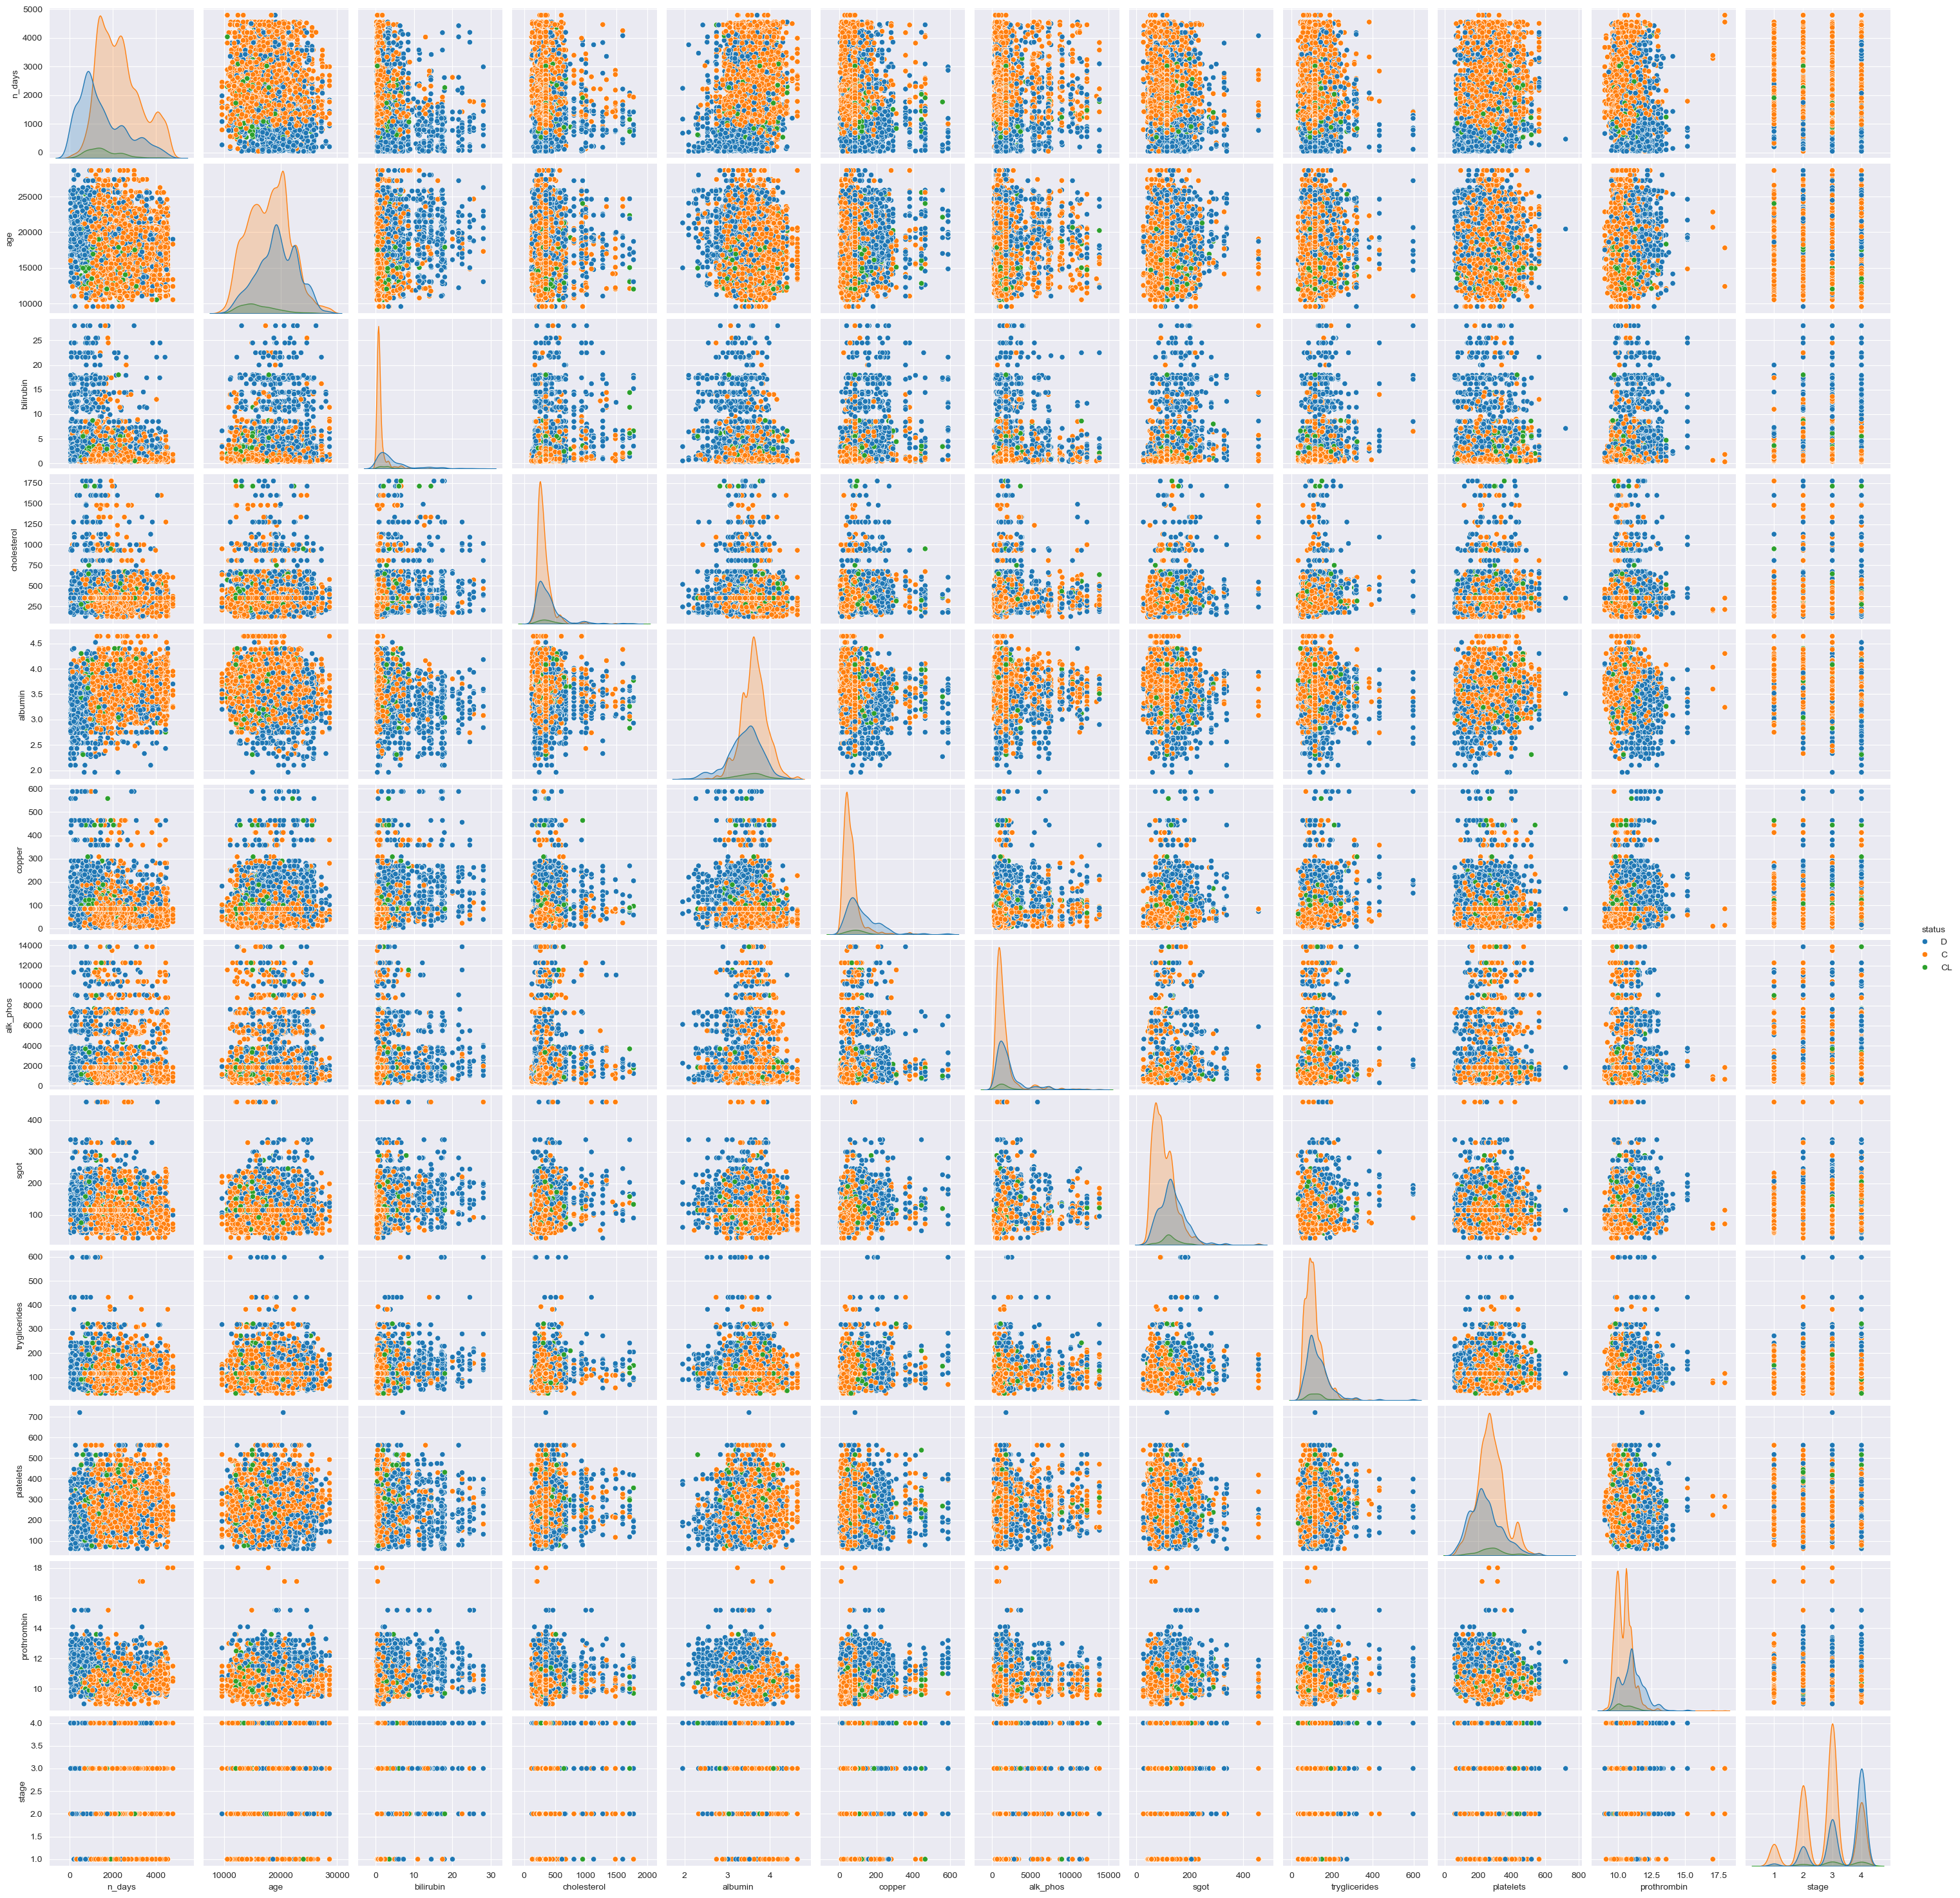

In [78]:
df = df.drop(columns='age_years')

sns.pairplot(df, hue='status')
plt.show()

A clearer way to decipher correlation and pairwise relationships is using correlation coefficients. We'll convert the categorical features to numeric to capture the whole dataset in this correlation matrix. The matrix shows clearly the existence of linear relationships between the features. Some features with high correlation with the target feature values include `n_days`, `bilirubin`, `copper`, `sgot`, `prothrombin`, `hepatomegaly`, and `stage`.

We'll use hypothesis testing to determine whether these relationships are statistically significant. 

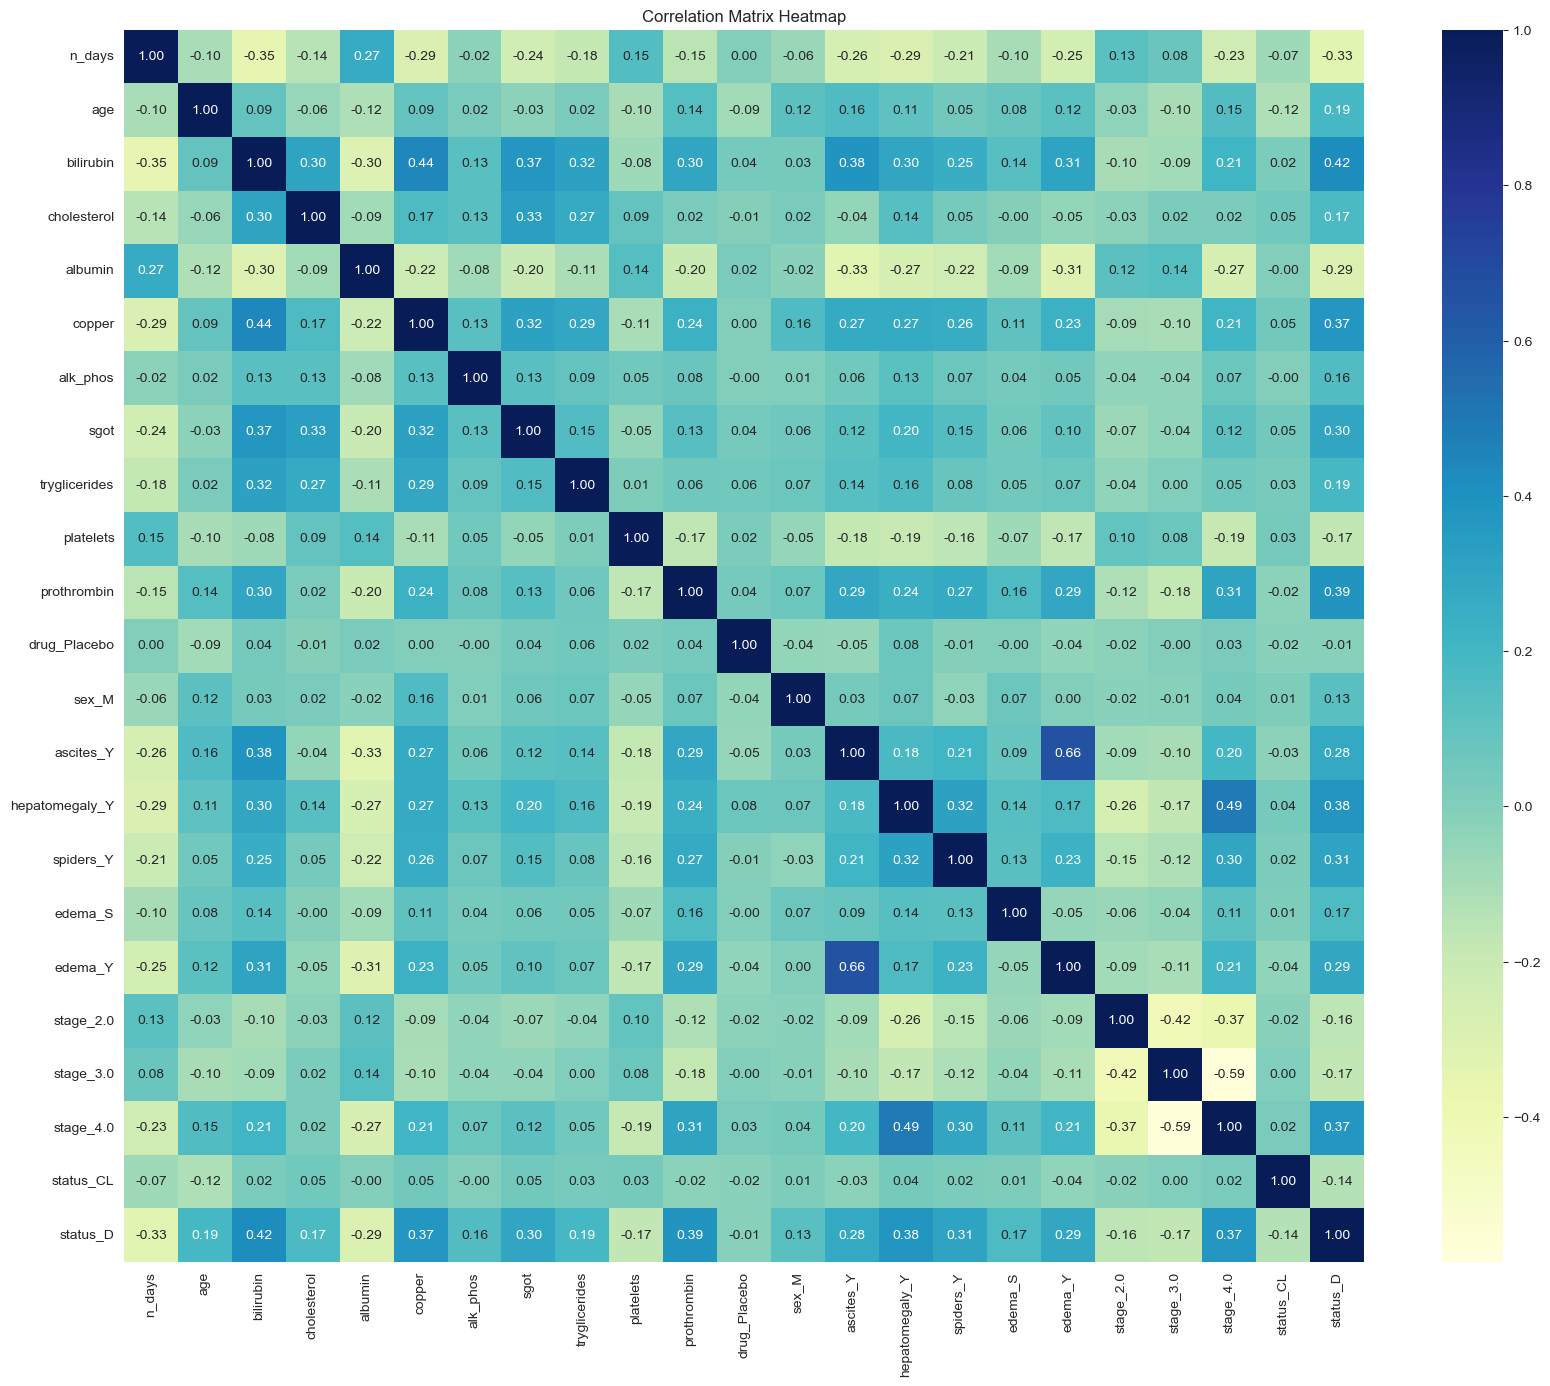

In [80]:
df_corr = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_corr = df_corr.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(df_corr, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

### Statistical Tests

We'll test the following questions:
1. Does the number of days between registration and final reading have an impact on patient's status?
2. Does the type of drug used have an impact on patient's status?
3. Does the participant's age have an impact on patient's status?
4. Does the participant's sex have an impact on patient's status?
5. Does the presence of ascites have an impact on patient's status?
6. Does the presence of hepatomegaly have an impact on patient's status?
7. Does the presence of spiders have an impact on patient's status?
8. Does the presence of edema have an impact on patient's status?
9. Does the level of serum bilirubin have an impact on patient's status?
10. Does the level of serum cholesterol have an impact on patient's status?
11. Does the level of albumin have an impact on patient's status?
12. Does the level of urine copper have an impact on patient's status?
13. Does the level of alkaline phosphatase have an impact on patient's status?
14. Does the level of sgot have an impact on patient's status?
15. Does the level of tryglicerides have an impact on patient's status?
16. Does the level of platelets per cubic have an impact on patient's status?
17. Does the amount of prothrombin time in the patient's system have an impact on patient's status?

_From our statistical tests, all features have statistically significant impact on patient status except `drug`._

##### Question 1
Statistical Question: Does the number of days between registration and final reading have an impact on patient's status?

Null Hypothesis: Number of days does not have a significant impact on status.

Alternative Hypothesis: Number of days has a significant impact on status.

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test. It is used to determine if there are any statistically significant differences between the means of three or more independent (unrelated) groups. It helps to determine whether the means across multiple groups are equal or if at least one group differs from the others.

Result: We accept the alternative hypothesis that number of days has a significant impact on patient status. This impact is mostly seen between the `C` and `D` values.

In [103]:
# Separate the numeric variable based on the categorical variable
grouped_data = [df['n_days'][df['status'] == category] for category in df['status'].unique()]

# Perform one-way ANOVA test
f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 587.4511
P-value: 0.0000
We reject the null hypothesis.


##### Question 2
Statistical Question: Does the type of drug used have an impact on patient's status?

Null Hypothesis: The type of drug used does not have an impact on patient's status?

Alternative Hypothesis: The type of drug used has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence. This test can determine whether there is a statistically significant association between two categorical variables.

Result: We accept the null hypothesis that the type of drug used has no significant impact on patient status.

In [83]:
contingency_table = pd.crosstab(df.drug, df.status)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

status              C   CL     D
drug                            
D-penicillamine  2488  161  1404
Placebo          2709  139  1422

P-value:  0.06483144753595531
We fail to reject the null hypothesis.


##### Question 3
Statistical Question: Does the participant's age have an impact on patient's status?

Null Hypothesis: Patient's age does not have an impact on patient's status?

Alternative Hypothesis: Patient's age has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test. 

Result: We accept the alternative hypothesis that the type of drug used has a significant impact on patient status.

In [87]:
grouped_data = [df['age'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 196.1715
P-value: 0.0000
We reject the null hypothesis.


##### Question 4
Statistical Question: Does the participant's sex have an impact on patient's status?

Null Hypothesis: Participant's sex does not have an impact on patient's status?

Alternative Hypothesis: Participant's sex has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence.

Result: We accept the alternative hypothesis that participant's sex has a significant impact on patient status.

In [88]:
contingency_table = pd.crosstab(df.sex, df.status)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

status     C   CL     D
sex                    
F       4950  273  2487
M        247   27   339

P-value:  1.4796603709237143e-31
We reject the null hypothesis.


##### Question 5
Statistical Question: Does the presence of ascites have an impact on patient's status?

Null Hypothesis: The presence of ascites does not have an impact on patient's status?

Alternative Hypothesis: The presence of ascites has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence.

Result: We accept the alternative hypothesis that the presence of ascites has a significant impact on patient status.

In [89]:
contingency_table = pd.crosstab(df.ascites, df.status)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

status      C   CL     D
ascites                 
N        5171  294  2454
Y          26    6   372

P-value:  6.161825511329564e-140
We reject the null hypothesis.


##### Question 6
Statistical Question: Does the presence of hepatomegaly have an impact on patient's status?

Null Hypothesis: The presence of hepatomegaly does not have an impact on patient's status?

Alternative Hypothesis: The presence of hepatomegaly has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence.

Result: We accept the alternative hypothesis that the presence of hepatomegaly has a significant impact on patient status.

In [90]:
contingency_table = pd.crosstab(df.hepatomegaly, df.status)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

status           C   CL     D
hepatomegaly                 
N             3282  116   617
Y             1915  184  2209

P-value:  5.336575580268355e-275
We reject the null hypothesis.


##### Question 7
Statistical Question: Does the presence of spiders have an impact on patient's status?

Null Hypothesis: The presence of spiders does not have an impact on patient's status?

Alternative Hypothesis: The presence of spiders has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence.

Result: We accept the alternative hypothesis that the presence of spiders has a significant impact on patient status.

In [91]:
contingency_table = pd.crosstab(df.spiders, df.status)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

status      C   CL     D
spiders                 
N        4471  213  1610
Y         726   87  1216

P-value:  1.3641487061645025e-183
We reject the null hypothesis.


##### Question 8
Statistical Question: Does the presence of edema have an impact on patient's status?

Null Hypothesis: The presence of edema does not have an impact on patient's status?

Alternative Hypothesis: The presence of edema has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the chi-squared test of independence.

Result: We accept the alternative hypothesis that the presence of edema has a significant impact on patient status.

In [92]:
contingency_table = pd.crosstab(df.edema, df.status)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

status     C   CL     D
edema                  
N       5063  279  2173
S        125   19   299
Y          9    2   354

P-value:  3.789208951605514e-207
We reject the null hypothesis.


##### Question 9
Statistical Question: Does the level of serum bilirubin have an impact on patient's status?

Null Hypothesis: The level of serum bilirubin does not have an impact on patient's status?

Alternative Hypothesis: The level of serum bilirubin has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test.

Result: We accept the alternative hypothesis that the level of serum bilirubin has a significant impact on patient status.

In [93]:
grouped_data = [df['bilirubin'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 943.3951
P-value: 0.0000
We reject the null hypothesis.


##### Question 10
Statistical Question: Does the level of serum cholesterol have an impact on patient's status?

Null Hypothesis: The level of serum cholesterol does not have an impact on patient's status?

Alternative Hypothesis: The level of serum cholesterol has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test.

Result: We accept the alternative hypothesis that the level of serum cholesterol has a significant impact on patient status.

In [94]:
grouped_data = [df['cholesterol'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 153.8005
P-value: 0.0000
We reject the null hypothesis.


##### Question 11
Statistical Question: Does the level of albumin have an impact on patient's status?

Null Hypothesis: The level of albumin does not have an impact on patient's status?

Alternative Hypothesis: The level of albumin has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test.

Result: We accept the alternative hypothesis that the level of albumin has a significant impact on patient status.

In [95]:
grouped_data = [df['albumin'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 395.7204
P-value: 0.0000
We reject the null hypothesis.


##### Question 12
Statistical Question: Does the level of urine copper have an impact on patient's status?

Null Hypothesis: The level of urine copper does not have an impact on patient's status?

Alternative Hypothesis: The level of urine copper has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test.

Result: We accept the alternative hypothesis that the level of urine copper has a significant impact on patient status.

In [97]:
grouped_data = [df['copper'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 724.5351
P-value: 0.0000
We reject the null hypothesis.


##### Question 13
Statistical Question: Does the level of alkaline phosphatase have an impact on patient's status?

Null Hypothesis: The level of alkaline phosphatase does not have an impact on patient's status?

Alternative Hypothesis: The level of alkaline phosphatase has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test.

Result: We accept the alternative hypothesis that the level of alkaline phosphatase has a significant impact on patient status.

In [98]:
grouped_data = [df['alk_phos'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 105.8024
P-value: 0.0000
We reject the null hypothesis.


##### Question 14
Statistical Question: Does the level of sgot have an impact on patient's status?

Null Hypothesis: The level of sgot does not have an impact on patient's status?

Alternative Hypothesis: The level of sgot has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test.

Result: We accept the alternative hypothesis that the level of sgot has a significant impact on patient status.

In [99]:
grouped_data = [df['sgot'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 450.3121
P-value: 0.0000
We reject the null hypothesis.


##### Question 15
Statistical Question: Does the level of tryglicerides have an impact on patient's status?

Null Hypothesis: The level of tryglicerides does not have an impact on patient's status?

Alternative Hypothesis: The level of tryglicerides has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test.

Result: We accept the alternative hypothesis that the level of tryglicerides has a significant impact on patient status.

In [100]:
grouped_data = [df['tryglicerides'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 168.6291
P-value: 0.0000
We reject the null hypothesis.


##### Question 16
Statistical Question: Does the level of platelets have an impact on patient's status?

Null Hypothesis: The level of platelets does not have an impact on patient's status?

Alternative Hypothesis: The level of platelets has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test.

Result: We accept the alternative hypothesis that the level of platelets has a significant impact on patient status.

In [101]:
grouped_data = [df['platelets'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 130.0820
P-value: 0.0000
We reject the null hypothesis.


##### Question 17
Statistical Question: Does the amount of prothrombin time have an impact on patient's status?

Null Hypothesis: The amount of prothrombin time does not have an impact on patient's status?

Alternative Hypothesis: The amount of prothrombin time has an impact on patient's status?

p-value alpha: 0.05. If the resulting p-value is less than or equal to alpha, we reject the null hypothesis and accept the alternative hypothesis.

Hypothesis test: A suitable hypothesis test for this scenario could be the one-way ANOVA test.

Result: We accept the alternative hypothesis that the amount of prothrombin time has a significant impact on patient status.

In [102]:
grouped_data = [df['prothrombin'][df['status'] == category] for category in df['status'].unique()]

f_statistic, p_val = f_oneway(*grouped_data)

print(f"ANOVA F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_val:.4f}")
if p_val <= 0.05:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

ANOVA F-statistic: 734.9277
P-value: 0.0000
We reject the null hypothesis.


### Feature Engineering

In [207]:
X = df.drop(columns='status')
y = df.status

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['number']).columns

In [208]:
# Create transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply transformers to respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, num_cols),
        ('categorical', categorical_transformer, cat_cols)
    ])

# Create a pipeline that includes the preprocessing steps
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the data using the pipeline
X_transformed = pipeline.fit_transform(X)

# Convert the transformed data back to a DataFrame 
columns = num_cols.tolist() + pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols).tolist()

X = pd.DataFrame(X_transformed, columns=columns)
X[num_cols] = X[num_cols].astype(float, errors='ignore')

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323 entries, 0 to 8322
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   n_days                8323 non-null   float64
 1   age                   8323 non-null   float64
 2   bilirubin             8323 non-null   float64
 3   cholesterol           8323 non-null   float64
 4   albumin               8323 non-null   float64
 5   copper                8323 non-null   float64
 6   alk_phos              8323 non-null   float64
 7   sgot                  8323 non-null   float64
 8   tryglicerides         8323 non-null   float64
 9   platelets             8323 non-null   float64
 10  prothrombin           8323 non-null   float64
 11  stage                 8323 non-null   float64
 12  drug_D-penicillamine  8323 non-null   float64
 13  drug_Placebo          8323 non-null   float64
 14  sex_F                 8323 non-null   float64
 15  sex_M                

#### Train and Validation Sets

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [210]:
np.unique(y_train_le), np.unique(y_test_le)

(array([0, 1, 2]), array([0, 1, 2]))

### Model Training & Evaluation

In [211]:
classifiers = [
    # LogisticRegression(), 
    # SGDClassifier(),
    # KNeighborsClassifier(),
    # LinearSVC(dual='auto'),
    # SVC(probability=True, kernel='linear'), 
    # MLPClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
    CatBoostClassifier()
]

linear_clfs = [
    # LogisticRegression(),
    SGDClassifier(),
    KNeighborsClassifier(),
    # LinearSVC(dual='auto'),
    SVC(probability=True, kernel='linear'),
]

encoded_clfs = [
    XGBClassifier(),
    LGBMClassifier(),
    CatBoostClassifier()
]

In [161]:
results = []

for classifier in classifiers:
    if classifier in linear_clfs:
        classifier.fit(X_train_scaled, y_train_le)
        y_pred = classifier.predict(X_test_scaled)
        y_pred_proba = classifier.predict_proba(X_test_scaled)
        
    else:
        classifier.fit(X_train, y_train_le)
        y_pred = classifier.predict(X_test)
        y_pred_proba = classifier.predict_proba(X_test)

    accuracy = accuracy_score(y_test_le, y_pred)
    precision = precision_score(y_test_le, y_pred, average='weighted')
    recall = recall_score(y_test_le, y_pred, average='weighted')
    f1 = f1_score(y_test_le, y_pred, average='weighted')
    logloss = log_loss(y_test_le, y_pred_proba)
    
    results.append({
        'Classifier': classifier.__class__.__name__,
        'Accuracy': f'{accuracy:.2f}',
        'Precision': f'{precision:.2f}',
        'Recall': f'{recall:.2f}',
        'F1 Score': f'{f1:.2f}',
        'Log Loss': f'{logloss:.2f}'
    })

df_results = pd.DataFrame(results)

# Display results DataFrame
display(df_results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1954
[LightGBM] [Info] Number of data points in the train set: 6658, number of used features: 25
[LightGBM] [Info] Start training from score -0.465986
[LightGBM] [Info] Start training from score -3.327111
[LightGBM] [Info] Start training from score -1.088897
Learning rate set to 0.087159
0:	learn: 1.0107476	total: 13.2ms	remaining: 13.2s
1:	learn: 0.9406951	total: 23.9ms	remaining: 11.9s
2:	learn: 0.8801383	total: 31.5ms	remaining: 10.5s
3:	learn: 0.8313252	total: 37.1ms	remaining: 9.24s
4:	learn: 0.7910443	total: 48.2ms	remaining: 9.59s
5:	learn: 0.7556484	total: 64.7ms	remaining: 10.7s
6:	learn: 0.7249110	total: 73.8ms	remaining: 10.5s
7:	learn: 0.6969846	total: 89ms	remaining: 11s
8:	learn: 0.6728536	total: 113ms	remaining: 12.5s
9:

Classifier Accuracy Precision Recall F1 Score Log Loss
0      DecisionTreeClassifier     0.73      0.72   0.73     0.73     9.83
1      RandomForestClassifier     0.82      0.81   0.82     0.81     0.59
2        ExtraTreesClassifier     0.81      0.80   0.81     0.79     0.68
3  GradientBoostingClassifier     0.82      0.82   0.82     0.81     0.46
4               XGBClassifier     0.82      0.82   0.82     0.81     0.51
5              LGBMClassifier     0.82      0.82   0.82     0.82     0.47
6          CatBoostClassifier     0.82      0.82   0.82     0.81     0.47

**Handling Imbalance in the Target Variable**

In [162]:
df.status.value_counts()

status
C     5197
D     2826
CL     300
Name: count, dtype: int64

In [165]:
smote = SMOTE()
adasyn = ADASYN()

X_smote, y_smote = smote.fit_resample(X_train, y_train_le)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train_le)

In [171]:
print('SMOTE')
print("Before SAMPLING:",y_train.value_counts())
print('----------')
unique_values, counts = np.unique(y_smote, return_counts=True)
print("After SAMPLING:",dict(zip(unique_values, counts)))

print('\nADASYN')
print("Before SAMPLING:",y_train.value_counts())
print('----------')
unique_values, counts = np.unique(y_adasyn, return_counts=True)
print("After SAMPLING:",dict(zip(unique_values, counts)))

SMOTE
Before SAMPLING: status
C     4178
D     2241
CL     239
Name: count, dtype: int64
----------
After SAMPLING: {0: 4178, 1: 4178, 2: 4178}

ADASYN
Before SAMPLING: status
C     4178
D     2241
CL     239
Name: count, dtype: int64
----------
After SAMPLING: {0: 4178, 1: 4099, 2: 4127}


In [174]:
results = []

for classifier in classifiers:
    classifier.fit(X_smote, y_smote)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)

    accuracy = accuracy_score(y_test_le, y_pred)
    precision = precision_score(y_test_le, y_pred, average='weighted')
    recall = recall_score(y_test_le, y_pred, average='weighted')
    f1 = f1_score(y_test_le, y_pred, average='weighted')
    logloss = log_loss(y_test_le, y_pred_proba)

    results.append({
        'Classifier': classifier.__class__.__name__,
        'Accuracy': f'{accuracy:.2f}',
        'Precision': f'{precision:.2f}',
        'Recall': f'{recall:.2f}',
        'F1 Score': f'{f1:.2f}',
        'Log Loss': f'{logloss:.2f}'
    })

df_results = pd.DataFrame(results)

# Display results DataFrame
display(df_results)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6355
[LightGBM] [Info] Number of data points in the train set: 12534, number of used features: 25
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Learning rate set to 0.090017
0:	learn: 1.0383153	total: 17.7ms	remaining: 17.7s
1:	learn: 0.9940210	total: 27.6ms	remaining: 13.8s
2:	learn: 0.9483814	total: 34.6ms	remaining: 11.5s
3:	learn: 0.9138917	total: 40.7ms	remaining: 10.1s
4:	learn: 0.8826144	total: 47.1ms	remaining: 9.37s
5:	learn: 0.8560461	total: 53ms	remaining: 8.79s
6:	learn: 0.8297710	total: 59.7ms	remaining: 8.46s
7:	learn: 0.8089730	total: 66.2ms	remaining: 8.21s
8:	learn: 0.7893073	total: 74ms	remaining: 8.15s
9:	learn: 0.7674148	total: 81.4ms	remaining: 8.06s
10:	learn: 0.

Classifier Accuracy Precision Recall F1 Score Log Loss
0      DecisionTreeClassifier     0.72      0.73   0.72     0.73     9.96
1      RandomForestClassifier     0.82      0.82   0.82     0.81     0.53
2        ExtraTreesClassifier     0.80      0.80   0.80     0.79     0.63
3  GradientBoostingClassifier     0.80      0.80   0.80     0.80     0.50
4               XGBClassifier     0.82      0.81   0.82     0.81     0.52
5              LGBMClassifier     0.82      0.81   0.82     0.81     0.47
6          CatBoostClassifier     0.82      0.81   0.82     0.81     0.49

In [175]:
results = []

for classifier in classifiers:
    classifier.fit(X_adasyn, y_adasyn)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)

    accuracy = accuracy_score(y_test_le, y_pred)
    precision = precision_score(y_test_le, y_pred, average='weighted')
    recall = recall_score(y_test_le, y_pred, average='weighted')
    f1 = f1_score(y_test_le, y_pred, average='weighted')
    logloss = log_loss(y_test_le, y_pred_proba)

    results.append({
        'Classifier': classifier.__class__.__name__,
        'Accuracy': f'{accuracy:.2f}',
        'Precision': f'{precision:.2f}',
        'Recall': f'{recall:.2f}',
        'F1 Score': f'{f1:.2f}',
        'Log Loss': f'{logloss:.2f}'
    })

df_results = pd.DataFrame(results)

# Display results DataFrame
display(df_results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5968
[LightGBM] [Info] Number of data points in the train set: 12404, number of used features: 25
[LightGBM] [Info] Start training from score -1.088186
[LightGBM] [Info] Start training from score -1.107276
[LightGBM] [Info] Start training from score -1.100468
Learning rate set to 0.089969
0:	learn: 1.0435519	total: 10.7ms	remaining: 10.7s
1:	learn: 0.9984883	total: 24.9ms	remaining: 12.4s
2:	learn: 0.9612446	total: 39.3ms	remaining: 13.1s
3:	learn: 0.9317636	total: 49.8ms	remaining: 12.4s
4:	learn: 0.9041992	total: 59.7ms	remaining: 11.9s
5:	learn: 0.8800025	total: 68.7ms	remaining: 11.4s
6:	learn: 0.8579399	total: 77.6ms	remaining: 11s
7:	learn: 0.8389646	total: 86.9ms	remaining: 10.8s
8:	learn: 0.8175123	total: 96.1ms	remaining: 10.6

Classifier Accuracy Precision Recall F1 Score Log Loss
0      DecisionTreeClassifier     0.71      0.72   0.71     0.71    10.61
1      RandomForestClassifier     0.82      0.81   0.82     0.81     0.52
2        ExtraTreesClassifier     0.81      0.80   0.81     0.80     0.71
3  GradientBoostingClassifier     0.80      0.80   0.80     0.80     0.50
4               XGBClassifier     0.82      0.81   0.82     0.81     0.52
5              LGBMClassifier     0.82      0.81   0.82     0.81     0.47
6          CatBoostClassifier     0.82      0.81   0.82     0.81     0.48

The best model is the ADASYN balanced LigbtGBM Classifier.

### Hyperparameter Tuning

ExtraTrees ADASYN:

In [218]:
# Define the Optuna objective function
def objective_et(trial):
    # Define hyperparameters to be optimized
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    # Create and train Extra Trees model
    model = ExtraTreesClassifier(**params, random_state=42)
    model.fit(X_adasyn, y_adasyn)

    # Predict class probabilities on the validation set
    y_pred_proba = model.predict_proba(X_test)

    # Calculate log loss as the metric to optimize
    logloss = log_loss(y_test_le, y_pred_proba)

    return logloss

# Set up Optuna study
study_et = optuna.create_study(direction='minimize')  # minimize log loss

# Optimize hyperparameters
study_et.optimize(objective_et, n_trials=50)  # you can adjust n_trials

# Print the best hyperparameters and their log loss
print('Best trial:')
trial_et = study_et.best_trial

print(f"Log Loss: {trial_et.value:.4f}")
print("Best hyperparameters:")
for key, value in trial_et.params.items():
    print(f"    {key}: {value}")


[I 2024-01-16 08:02:36,913] A new study created in memory with name: no-name-747ab552-09eb-4eda-94a9-920440c13b36
[I 2024-01-16 08:02:37,211] Trial 0 finished with value: 1.0941354597204866 and parameters: {'n_estimators': 64, 'max_depth': 17, 'min_samples_split': 0.45291012237301737, 'min_samples_leaf': 0.4905771365591752, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 1.0941354597204866.
[I 2024-01-16 08:02:37,742] Trial 1 finished with value: 1.093552537680761 and parameters: {'n_estimators': 171, 'max_depth': 7, 'min_samples_split': 0.3994733061890493, 'min_samples_leaf': 0.3197328273193858, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 1.093552537680761.
[I 2024-01-16 08:02:38,090] Trial 2 finished with value: 1.0017579777393977 and parameters: {'n_estimators': 120, 'max_depth': 12, 'min_samples_split': 0.780495387058602, 'min_samples_leaf': 0.15954395350779305, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with val

Best trial:
Log Loss: 0.9454
Best hyperparameters:
    n_estimators: 83
    max_depth: 11
    min_samples_split: 0.15429048989839433
    min_samples_leaf: 0.12473814981262742
    max_features: sqrt
    bootstrap: False


XGBoost ADASYN:

In [220]:
def objective_xgb(trial):
    params = {
        'objective': 'multi:softmax',  # Specify multi-class classification
        'num_class': 3,  # Number of classes in your dataset
        'eval_metric': 'mlogloss',  # Multi-class log loss
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    model = XGBClassifier(**params, random_state=42)
    model.fit(X_adasyn, y_adasyn, eval_set=[(X_test, y_test_le)])

    y_pred_proba = model.predict_proba(X_test)
    logloss = log_loss(y_test_le, y_pred_proba)

    return logloss

# Set up Optuna study for XGBoost
study_xgb = optuna.create_study(direction='minimize')  # minimize log loss

# Optimize hyperparameters for XGBoost
study_xgb.optimize(objective_xgb, n_trials=50)

# Print the best hyperparameters and their log loss for XGBoost
print('Best trial (XGBoost):')
trial_xgb = study_xgb.best_trial
print(f"Log Loss: {trial_xgb.value:.4f}")
print("Best hyperparameters:")
for key, value in trial_xgb.params.items():
    print(f"    {key}: {value}")


[I 2024-01-16 08:04:32,895] A new study created in memory with name: no-name-98193cab-e7cb-4945-bea8-feed0027a69c


[0]	validation_0-mlogloss:1.09052
[1]	validation_0-mlogloss:1.08201
[2]	validation_0-mlogloss:1.07354
[3]	validation_0-mlogloss:1.06588
[4]	validation_0-mlogloss:1.05838
[5]	validation_0-mlogloss:1.05054
[6]	validation_0-mlogloss:1.04329
[7]	validation_0-mlogloss:1.03608
[8]	validation_0-mlogloss:1.02874
[9]	validation_0-mlogloss:1.02152
[10]	validation_0-mlogloss:1.01443
[11]	validation_0-mlogloss:1.00761
[12]	validation_0-mlogloss:1.00085
[13]	validation_0-mlogloss:0.99446
[14]	validation_0-mlogloss:0.98806
[15]	validation_0-mlogloss:0.98172
[16]	validation_0-mlogloss:0.97522
[17]	validation_0-mlogloss:0.96916
[18]	validation_0-mlogloss:0.96297
[19]	validation_0-mlogloss:0.95731
[20]	validation_0-mlogloss:0.95147
[21]	validation_0-mlogloss:0.94566
[22]	validation_0-mlogloss:0.94006
[23]	validation_0-mlogloss:0.93421
[24]	validation_0-mlogloss:0.92863
[25]	validation_0-mlogloss:0.92292
[26]	validation_0-mlogloss:0.91763
[27]	validation_0-mlogloss:0.91247
[28]	validation_0-mlogloss:0.9

[I 2024-01-16 08:04:33,969] Trial 0 finished with value: 0.8147253725619313 and parameters: {'n_estimators': 51, 'learning_rate': 0.014894942663593992, 'max_depth': 6, 'min_child_weight': 1.37194088390078, 'subsample': 0.26138252858531325, 'colsample_bytree': 0.9233720996350858, 'gamma': 0.5531815976226704, 'reg_alpha': 5.482627511693881, 'reg_lambda': 5.874499238584251}. Best is trial 0 with value: 0.8147253725619313.


[0]	validation_0-mlogloss:1.06422
[1]	validation_0-mlogloss:1.03193
[2]	validation_0-mlogloss:1.00058
[3]	validation_0-mlogloss:0.97240
[4]	validation_0-mlogloss:0.94619
[5]	validation_0-mlogloss:0.92189
[6]	validation_0-mlogloss:0.89803
[7]	validation_0-mlogloss:0.87640
[8]	validation_0-mlogloss:0.85540
[9]	validation_0-mlogloss:0.83524
[10]	validation_0-mlogloss:0.81603
[11]	validation_0-mlogloss:0.79863
[12]	validation_0-mlogloss:0.78162
[13]	validation_0-mlogloss:0.76610
[14]	validation_0-mlogloss:0.75100
[15]	validation_0-mlogloss:0.73676
[16]	validation_0-mlogloss:0.72304
[17]	validation_0-mlogloss:0.71031
[18]	validation_0-mlogloss:0.69813
[19]	validation_0-mlogloss:0.68651
[20]	validation_0-mlogloss:0.67504
[21]	validation_0-mlogloss:0.66415
[22]	validation_0-mlogloss:0.65414
[23]	validation_0-mlogloss:0.64407
[24]	validation_0-mlogloss:0.63500
[25]	validation_0-mlogloss:0.62607
[26]	validation_0-mlogloss:0.61706
[27]	validation_0-mlogloss:0.60846
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:04:39,652] Trial 1 finished with value: 0.31700997564164535 and parameters: {'n_estimators': 180, 'learning_rate': 0.054329489453135746, 'max_depth': 19, 'min_child_weight': 6.271053120331447, 'subsample': 0.5348925764460851, 'colsample_bytree': 0.7895383318449448, 'gamma': 0.7163835310154029, 'reg_alpha': 2.5240116944004685, 'reg_lambda': 8.926220228256263}. Best is trial 1 with value: 0.31700997564164535.


[0]	validation_0-mlogloss:1.07659
[1]	validation_0-mlogloss:1.05517
[2]	validation_0-mlogloss:1.03490
[3]	validation_0-mlogloss:1.01545
[4]	validation_0-mlogloss:0.99671
[5]	validation_0-mlogloss:0.97857
[6]	validation_0-mlogloss:0.96138
[7]	validation_0-mlogloss:0.94475
[8]	validation_0-mlogloss:0.92898
[9]	validation_0-mlogloss:0.91359
[10]	validation_0-mlogloss:0.89904
[11]	validation_0-mlogloss:0.88459
[12]	validation_0-mlogloss:0.87051
[13]	validation_0-mlogloss:0.85738
[14]	validation_0-mlogloss:0.84438
[15]	validation_0-mlogloss:0.83213
[16]	validation_0-mlogloss:0.82014
[17]	validation_0-mlogloss:0.80853
[18]	validation_0-mlogloss:0.79704
[19]	validation_0-mlogloss:0.78611
[20]	validation_0-mlogloss:0.77553
[21]	validation_0-mlogloss:0.76539
[22]	validation_0-mlogloss:0.75549
[23]	validation_0-mlogloss:0.74570
[24]	validation_0-mlogloss:0.73631
[25]	validation_0-mlogloss:0.72713
[26]	validation_0-mlogloss:0.71852
[27]	validation_0-mlogloss:0.70950
[28]	validation_0-mlogloss:0.7

[I 2024-01-16 08:04:46,472] Trial 2 finished with value: 0.34743923309706015 and parameters: {'n_estimators': 142, 'learning_rate': 0.030534720229397194, 'max_depth': 16, 'min_child_weight': 9.553469368457561, 'subsample': 0.8163172324593767, 'colsample_bytree': 0.9786015979453714, 'gamma': 0.04348035315974763, 'reg_alpha': 2.7605799780124327, 'reg_lambda': 5.967421948297376}. Best is trial 1 with value: 0.31700997564164535.


[0]	validation_0-mlogloss:1.06986
[1]	validation_0-mlogloss:1.03443
[2]	validation_0-mlogloss:1.00222
[3]	validation_0-mlogloss:0.97677
[4]	validation_0-mlogloss:0.94811
[5]	validation_0-mlogloss:0.92688
[6]	validation_0-mlogloss:0.90274
[7]	validation_0-mlogloss:0.87854
[8]	validation_0-mlogloss:0.85543
[9]	validation_0-mlogloss:0.83919
[10]	validation_0-mlogloss:0.81880
[11]	validation_0-mlogloss:0.80393
[12]	validation_0-mlogloss:0.78680
[13]	validation_0-mlogloss:0.77091
[14]	validation_0-mlogloss:0.75524
[15]	validation_0-mlogloss:0.74211
[16]	validation_0-mlogloss:0.73026
[17]	validation_0-mlogloss:0.71729
[18]	validation_0-mlogloss:0.70496
[19]	validation_0-mlogloss:0.69437
[20]	validation_0-mlogloss:0.68345
[21]	validation_0-mlogloss:0.67197
[22]	validation_0-mlogloss:0.66320
[23]	validation_0-mlogloss:0.65347
[24]	validation_0-mlogloss:0.64527
[25]	validation_0-mlogloss:0.63673
[26]	validation_0-mlogloss:0.62936
[27]	validation_0-mlogloss:0.62205
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:04:51,387] Trial 3 finished with value: 0.3871450275125498 and parameters: {'n_estimators': 173, 'learning_rate': 0.07698826815413716, 'max_depth': 20, 'min_child_weight': 1.4078242594085708, 'subsample': 0.47441714231888643, 'colsample_bytree': 0.35040536173611175, 'gamma': 0.00939664560127973, 'reg_alpha': 8.852105743202417, 'reg_lambda': 6.198899532763097}. Best is trial 1 with value: 0.31700997564164535.


[0]	validation_0-mlogloss:1.07187
[1]	validation_0-mlogloss:1.04100
[2]	validation_0-mlogloss:1.01241
[3]	validation_0-mlogloss:0.98735
[4]	validation_0-mlogloss:0.96068
[5]	validation_0-mlogloss:0.93979
[6]	validation_0-mlogloss:0.91649
[7]	validation_0-mlogloss:0.89417
[8]	validation_0-mlogloss:0.87253
[9]	validation_0-mlogloss:0.85388
[10]	validation_0-mlogloss:0.83458
[11]	validation_0-mlogloss:0.81688
[12]	validation_0-mlogloss:0.79973
[13]	validation_0-mlogloss:0.78484
[14]	validation_0-mlogloss:0.76999
[15]	validation_0-mlogloss:0.75720
[16]	validation_0-mlogloss:0.74373
[17]	validation_0-mlogloss:0.73043
[18]	validation_0-mlogloss:0.71743
[19]	validation_0-mlogloss:0.70659
[20]	validation_0-mlogloss:0.69549
[21]	validation_0-mlogloss:0.68498
[22]	validation_0-mlogloss:0.67557
[23]	validation_0-mlogloss:0.66609
[24]	validation_0-mlogloss:0.65704
[25]	validation_0-mlogloss:0.64792
[26]	validation_0-mlogloss:0.64055
[27]	validation_0-mlogloss:0.63261
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:04:53,792] Trial 4 finished with value: 0.46010386690392535 and parameters: {'n_estimators': 77, 'learning_rate': 0.06457464827972069, 'max_depth': 20, 'min_child_weight': 8.76771832875953, 'subsample': 0.44218412635740834, 'colsample_bytree': 0.372694932495291, 'gamma': 0.07148310224888099, 'reg_alpha': 4.199715100561133, 'reg_lambda': 9.203018466090235}. Best is trial 1 with value: 0.31700997564164535.


[0]	validation_0-mlogloss:1.04856
[1]	validation_0-mlogloss:1.00549
[2]	validation_0-mlogloss:0.96517
[3]	validation_0-mlogloss:0.93062
[4]	validation_0-mlogloss:0.89733
[5]	validation_0-mlogloss:0.86809
[6]	validation_0-mlogloss:0.84058
[7]	validation_0-mlogloss:0.81529
[8]	validation_0-mlogloss:0.79091
[9]	validation_0-mlogloss:0.76994
[10]	validation_0-mlogloss:0.75057
[11]	validation_0-mlogloss:0.73230
[12]	validation_0-mlogloss:0.71616
[13]	validation_0-mlogloss:0.70113
[14]	validation_0-mlogloss:0.68690
[15]	validation_0-mlogloss:0.67333
[16]	validation_0-mlogloss:0.66007
[17]	validation_0-mlogloss:0.64862
[18]	validation_0-mlogloss:0.63765
[19]	validation_0-mlogloss:0.62828
[20]	validation_0-mlogloss:0.61871
[21]	validation_0-mlogloss:0.60981
[22]	validation_0-mlogloss:0.60191
[23]	validation_0-mlogloss:0.59463
[24]	validation_0-mlogloss:0.58642
[25]	validation_0-mlogloss:0.57901
[26]	validation_0-mlogloss:0.57252
[27]	validation_0-mlogloss:0.56591
[28]	validation_0-mlogloss:0.5

[I 2024-01-16 08:04:55,457] Trial 5 finished with value: 0.4472454479389645 and parameters: {'n_estimators': 70, 'learning_rate': 0.0883367182161876, 'max_depth': 16, 'min_child_weight': 7.2199957463763385, 'subsample': 0.3601060878734139, 'colsample_bytree': 0.5995404864575117, 'gamma': 0.8929783024078674, 'reg_alpha': 5.856193991817362, 'reg_lambda': 0.01899743077289129}. Best is trial 1 with value: 0.31700997564164535.


[0]	validation_0-mlogloss:1.06175
[1]	validation_0-mlogloss:1.02608
[2]	validation_0-mlogloss:0.99261
[3]	validation_0-mlogloss:0.96354
[4]	validation_0-mlogloss:0.93645
[5]	validation_0-mlogloss:0.91071
[6]	validation_0-mlogloss:0.88677
[7]	validation_0-mlogloss:0.86413
[8]	validation_0-mlogloss:0.84239
[9]	validation_0-mlogloss:0.82247
[10]	validation_0-mlogloss:0.80357
[11]	validation_0-mlogloss:0.78694
[12]	validation_0-mlogloss:0.77167
[13]	validation_0-mlogloss:0.75753
[14]	validation_0-mlogloss:0.74312
[15]	validation_0-mlogloss:0.72967
[16]	validation_0-mlogloss:0.71803
[17]	validation_0-mlogloss:0.70657
[18]	validation_0-mlogloss:0.69545
[19]	validation_0-mlogloss:0.68602
[20]	validation_0-mlogloss:0.67649
[21]	validation_0-mlogloss:0.66704
[22]	validation_0-mlogloss:0.65865
[23]	validation_0-mlogloss:0.65045
[24]	validation_0-mlogloss:0.64257
[25]	validation_0-mlogloss:0.63425
[26]	validation_0-mlogloss:0.62690
[27]	validation_0-mlogloss:0.61897
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:04:59,731] Trial 6 finished with value: 0.39080965973154874 and parameters: {'n_estimators': 169, 'learning_rate': 0.06805031265186477, 'max_depth': 11, 'min_child_weight': 6.918855044177264, 'subsample': 0.37044645208222454, 'colsample_bytree': 0.7727954144139582, 'gamma': 0.5950771293045822, 'reg_alpha': 6.4929123463631475, 'reg_lambda': 6.176047621292683}. Best is trial 1 with value: 0.31700997564164535.


[0]	validation_0-mlogloss:1.07526
[1]	validation_0-mlogloss:1.05380
[2]	validation_0-mlogloss:1.03178
[3]	validation_0-mlogloss:1.01411
[4]	validation_0-mlogloss:0.99458
[5]	validation_0-mlogloss:0.97734
[6]	validation_0-mlogloss:0.96015
[7]	validation_0-mlogloss:0.94382
[8]	validation_0-mlogloss:0.92675
[9]	validation_0-mlogloss:0.91177
[10]	validation_0-mlogloss:0.89726
[11]	validation_0-mlogloss:0.88308
[12]	validation_0-mlogloss:0.86928
[13]	validation_0-mlogloss:0.85749
[14]	validation_0-mlogloss:0.84553
[15]	validation_0-mlogloss:0.83429
[16]	validation_0-mlogloss:0.82308
[17]	validation_0-mlogloss:0.81227
[18]	validation_0-mlogloss:0.80156
[19]	validation_0-mlogloss:0.79257
[20]	validation_0-mlogloss:0.78347
[21]	validation_0-mlogloss:0.77411
[22]	validation_0-mlogloss:0.76618
[23]	validation_0-mlogloss:0.75755
[24]	validation_0-mlogloss:0.74977
[25]	validation_0-mlogloss:0.74172
[26]	validation_0-mlogloss:0.73455
[27]	validation_0-mlogloss:0.72721
[28]	validation_0-mlogloss:0.7

[I 2024-01-16 08:05:02,148] Trial 7 finished with value: 0.5152703896972446 and parameters: {'n_estimators': 104, 'learning_rate': 0.04691517861978612, 'max_depth': 16, 'min_child_weight': 5.358859444314792, 'subsample': 0.2771420162612295, 'colsample_bytree': 0.6279435589490487, 'gamma': 0.7939978157584568, 'reg_alpha': 7.363288969095604, 'reg_lambda': 9.05905685843558}. Best is trial 1 with value: 0.31700997564164535.


[0]	validation_0-mlogloss:1.04230
[1]	validation_0-mlogloss:0.99161
[2]	validation_0-mlogloss:0.94398
[3]	validation_0-mlogloss:0.90225
[4]	validation_0-mlogloss:0.86344
[5]	validation_0-mlogloss:0.82821
[6]	validation_0-mlogloss:0.79589
[7]	validation_0-mlogloss:0.76675
[8]	validation_0-mlogloss:0.74008
[9]	validation_0-mlogloss:0.71435
[10]	validation_0-mlogloss:0.69097
[11]	validation_0-mlogloss:0.66889
[12]	validation_0-mlogloss:0.64854
[13]	validation_0-mlogloss:0.63041
[14]	validation_0-mlogloss:0.61279
[15]	validation_0-mlogloss:0.59702
[16]	validation_0-mlogloss:0.58192
[17]	validation_0-mlogloss:0.56761
[18]	validation_0-mlogloss:0.55455
[19]	validation_0-mlogloss:0.54284
[20]	validation_0-mlogloss:0.53088
[21]	validation_0-mlogloss:0.52010
[22]	validation_0-mlogloss:0.50950
[23]	validation_0-mlogloss:0.50017
[24]	validation_0-mlogloss:0.49061
[25]	validation_0-mlogloss:0.48236
[26]	validation_0-mlogloss:0.47422
[27]	validation_0-mlogloss:0.46605
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:05:05,026] Trial 8 finished with value: 0.33303691993744144 and parameters: {'n_estimators': 60, 'learning_rate': 0.08375234058713507, 'max_depth': 15, 'min_child_weight': 5.957411150469713, 'subsample': 0.9708329306134154, 'colsample_bytree': 0.6825896221389116, 'gamma': 0.40633936954698713, 'reg_alpha': 3.5494865624518432, 'reg_lambda': 6.300851045940802}. Best is trial 1 with value: 0.31700997564164535.


[0]	validation_0-mlogloss:1.04801
[1]	validation_0-mlogloss:0.99646
[2]	validation_0-mlogloss:0.94713
[3]	validation_0-mlogloss:0.90203
[4]	validation_0-mlogloss:0.85857
[5]	validation_0-mlogloss:0.82388
[6]	validation_0-mlogloss:0.78753
[7]	validation_0-mlogloss:0.75439
[8]	validation_0-mlogloss:0.72352
[9]	validation_0-mlogloss:0.69555
[10]	validation_0-mlogloss:0.66713
[11]	validation_0-mlogloss:0.64233
[12]	validation_0-mlogloss:0.61753
[13]	validation_0-mlogloss:0.59597
[14]	validation_0-mlogloss:0.57566
[15]	validation_0-mlogloss:0.55731
[16]	validation_0-mlogloss:0.53921
[17]	validation_0-mlogloss:0.52111
[18]	validation_0-mlogloss:0.50465
[19]	validation_0-mlogloss:0.48956
[20]	validation_0-mlogloss:0.47464
[21]	validation_0-mlogloss:0.46074
[22]	validation_0-mlogloss:0.44708
[23]	validation_0-mlogloss:0.43414
[24]	validation_0-mlogloss:0.42286
[25]	validation_0-mlogloss:0.41121
[26]	validation_0-mlogloss:0.40077
[27]	validation_0-mlogloss:0.39071
[28]	validation_0-mlogloss:0.3

[I 2024-01-16 08:05:12,336] Trial 9 finished with value: 0.14250476138962326 and parameters: {'n_estimators': 100, 'learning_rate': 0.07360951055796659, 'max_depth': 20, 'min_child_weight': 1.9763804376017435, 'subsample': 0.5131606301330716, 'colsample_bytree': 0.37338890208161607, 'gamma': 0.07692371125561326, 'reg_alpha': 0.30271005490719705, 'reg_lambda': 0.42398744391598187}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.08397
[1]	validation_0-mlogloss:1.06786
[2]	validation_0-mlogloss:1.04750
[3]	validation_0-mlogloss:1.03098
[4]	validation_0-mlogloss:1.01449
[5]	validation_0-mlogloss:0.99969
[6]	validation_0-mlogloss:0.98304
[7]	validation_0-mlogloss:0.96866
[8]	validation_0-mlogloss:0.95523
[9]	validation_0-mlogloss:0.94514
[10]	validation_0-mlogloss:0.92903
[11]	validation_0-mlogloss:0.91703
[12]	validation_0-mlogloss:0.90391
[13]	validation_0-mlogloss:0.89146
[14]	validation_0-mlogloss:0.88140
[15]	validation_0-mlogloss:0.87048
[16]	validation_0-mlogloss:0.86030
[17]	validation_0-mlogloss:0.84721
[18]	validation_0-mlogloss:0.83785
[19]	validation_0-mlogloss:0.82663
[20]	validation_0-mlogloss:0.81514
[21]	validation_0-mlogloss:0.80533
[22]	validation_0-mlogloss:0.79634
[23]	validation_0-mlogloss:0.78601
[24]	validation_0-mlogloss:0.77617
[25]	validation_0-mlogloss:0.76803
[26]	validation_0-mlogloss:0.75945
[27]	validation_0-mlogloss:0.75084
[28]	validation_0-mlogloss:0.7

[I 2024-01-16 08:05:17,904] Trial 10 finished with value: 0.4547077900013684 and parameters: {'n_estimators': 114, 'learning_rate': 0.0362096020158545, 'max_depth': 9, 'min_child_weight': 3.4371495925808007, 'subsample': 0.6824821541443775, 'colsample_bytree': 0.19715069332232943, 'gamma': 0.2819616009097064, 'reg_alpha': 1.133669015893377, 'reg_lambda': 0.04164307318984406}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.03394
[1]	validation_0-mlogloss:0.97184
[2]	validation_0-mlogloss:0.91784
[3]	validation_0-mlogloss:0.86856
[4]	validation_0-mlogloss:0.82271
[5]	validation_0-mlogloss:0.78469
[6]	validation_0-mlogloss:0.74803
[7]	validation_0-mlogloss:0.71514
[8]	validation_0-mlogloss:0.68449
[9]	validation_0-mlogloss:0.65774
[10]	validation_0-mlogloss:0.63225
[11]	validation_0-mlogloss:0.60802
[12]	validation_0-mlogloss:0.58538
[13]	validation_0-mlogloss:0.56751
[14]	validation_0-mlogloss:0.54854
[15]	validation_0-mlogloss:0.53281
[16]	validation_0-mlogloss:0.51831
[17]	validation_0-mlogloss:0.50279
[18]	validation_0-mlogloss:0.48916
[19]	validation_0-mlogloss:0.47701
[20]	validation_0-mlogloss:0.46489
[21]	validation_0-mlogloss:0.45392
[22]	validation_0-mlogloss:0.44359
[23]	validation_0-mlogloss:0.43381
[24]	validation_0-mlogloss:0.42486
[25]	validation_0-mlogloss:0.41589
[26]	validation_0-mlogloss:0.40827
[27]	validation_0-mlogloss:0.40072
[28]	validation_0-mlogloss:0.3

[I 2024-01-16 08:05:23,305] Trial 11 finished with value: 0.2228269824519511 and parameters: {'n_estimators': 142, 'learning_rate': 0.0991210480635786, 'max_depth': 20, 'min_child_weight': 3.7355956513231314, 'subsample': 0.6581804251099812, 'colsample_bytree': 0.4511789113419275, 'gamma': 0.7224085900867627, 'reg_alpha': 0.5963279688536391, 'reg_lambda': 2.7240466103574406}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.06744
[1]	validation_0-mlogloss:1.02852
[2]	validation_0-mlogloss:0.99191
[3]	validation_0-mlogloss:0.96383
[4]	validation_0-mlogloss:0.93804
[5]	validation_0-mlogloss:0.91509
[6]	validation_0-mlogloss:0.89167
[7]	validation_0-mlogloss:0.87033
[8]	validation_0-mlogloss:0.84741
[9]	validation_0-mlogloss:0.82856
[10]	validation_0-mlogloss:0.81126
[11]	validation_0-mlogloss:0.79385
[12]	validation_0-mlogloss:0.77828
[13]	validation_0-mlogloss:0.76531
[14]	validation_0-mlogloss:0.75207
[15]	validation_0-mlogloss:0.74184
[16]	validation_0-mlogloss:0.73159
[17]	validation_0-mlogloss:0.71995
[18]	validation_0-mlogloss:0.70898
[19]	validation_0-mlogloss:0.70051
[20]	validation_0-mlogloss:0.69149
[21]	validation_0-mlogloss:0.68335
[22]	validation_0-mlogloss:0.67652
[23]	validation_0-mlogloss:0.66915
[24]	validation_0-mlogloss:0.66304
[25]	validation_0-mlogloss:0.65695
[26]	validation_0-mlogloss:0.65103
[27]	validation_0-mlogloss:0.64519
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:05:24,969] Trial 12 finished with value: 0.46471907796404976 and parameters: {'n_estimators': 140, 'learning_rate': 0.09911101996487318, 'max_depth': 3, 'min_child_weight': 3.403135309120321, 'subsample': 0.6566232991429758, 'colsample_bytree': 0.44605412618080964, 'gamma': 0.9993642150394444, 'reg_alpha': 0.33149684390476764, 'reg_lambda': 2.143824824746215}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.07652
[1]	validation_0-mlogloss:1.05927
[2]	validation_0-mlogloss:1.02267
[3]	validation_0-mlogloss:1.00469
[4]	validation_0-mlogloss:0.98462
[5]	validation_0-mlogloss:0.95989
[6]	validation_0-mlogloss:0.93624
[7]	validation_0-mlogloss:0.92868
[8]	validation_0-mlogloss:0.91486
[9]	validation_0-mlogloss:0.89815
[10]	validation_0-mlogloss:0.88208
[11]	validation_0-mlogloss:0.86265
[12]	validation_0-mlogloss:0.84644
[13]	validation_0-mlogloss:0.82634
[14]	validation_0-mlogloss:0.81281
[15]	validation_0-mlogloss:0.79838
[16]	validation_0-mlogloss:0.78259
[17]	validation_0-mlogloss:0.76807
[18]	validation_0-mlogloss:0.75894
[19]	validation_0-mlogloss:0.75084
[20]	validation_0-mlogloss:0.73865
[21]	validation_0-mlogloss:0.72607
[22]	validation_0-mlogloss:0.71815
[23]	validation_0-mlogloss:0.70264
[24]	validation_0-mlogloss:0.69139
[25]	validation_0-mlogloss:0.68428
[26]	validation_0-mlogloss:0.67878
[27]	validation_0-mlogloss:0.67083
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:05:27,340] Trial 13 finished with value: 0.46855092088409594 and parameters: {'n_estimators': 93, 'learning_rate': 0.09922565177004047, 'max_depth': 13, 'min_child_weight': 3.0926178739223933, 'subsample': 0.1398796414228261, 'colsample_bytree': 0.11056551659298613, 'gamma': 0.25716272059577727, 'reg_alpha': 0.014387979595613665, 'reg_lambda': 2.684896228657332}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05344
[1]	validation_0-mlogloss:1.00720
[2]	validation_0-mlogloss:0.96686
[3]	validation_0-mlogloss:0.92864
[4]	validation_0-mlogloss:0.89240
[5]	validation_0-mlogloss:0.86093
[6]	validation_0-mlogloss:0.83077
[7]	validation_0-mlogloss:0.80256
[8]	validation_0-mlogloss:0.77639
[9]	validation_0-mlogloss:0.75251
[10]	validation_0-mlogloss:0.72809
[11]	validation_0-mlogloss:0.70618
[12]	validation_0-mlogloss:0.68583
[13]	validation_0-mlogloss:0.66874
[14]	validation_0-mlogloss:0.65072
[15]	validation_0-mlogloss:0.63546
[16]	validation_0-mlogloss:0.62042
[17]	validation_0-mlogloss:0.60483
[18]	validation_0-mlogloss:0.59153
[19]	validation_0-mlogloss:0.57905
[20]	validation_0-mlogloss:0.56664
[21]	validation_0-mlogloss:0.55558
[22]	validation_0-mlogloss:0.54487
[23]	validation_0-mlogloss:0.53470
[24]	validation_0-mlogloss:0.52518
[25]	validation_0-mlogloss:0.51596
[26]	validation_0-mlogloss:0.50805
[27]	validation_0-mlogloss:0.49984
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:05:31,634] Trial 14 finished with value: 0.2765248437076078 and parameters: {'n_estimators': 137, 'learning_rate': 0.07404028226322515, 'max_depth': 18, 'min_child_weight': 4.40762873667171, 'subsample': 0.6770880432135642, 'colsample_bytree': 0.4732386592292033, 'gamma': 0.6740794677972242, 'reg_alpha': 1.8826673205518103, 'reg_lambda': 2.3526892625000633}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05372
[1]	validation_0-mlogloss:1.00707
[2]	validation_0-mlogloss:0.96050
[3]	validation_0-mlogloss:0.91899
[4]	validation_0-mlogloss:0.87791
[5]	validation_0-mlogloss:0.84880
[6]	validation_0-mlogloss:0.81619
[7]	validation_0-mlogloss:0.78434
[8]	validation_0-mlogloss:0.75471
[9]	validation_0-mlogloss:0.73238
[10]	validation_0-mlogloss:0.70561
[11]	validation_0-mlogloss:0.68533
[12]	validation_0-mlogloss:0.66204
[13]	validation_0-mlogloss:0.64460
[14]	validation_0-mlogloss:0.62530
[15]	validation_0-mlogloss:0.61077
[16]	validation_0-mlogloss:0.59630
[17]	validation_0-mlogloss:0.58008
[18]	validation_0-mlogloss:0.56532
[19]	validation_0-mlogloss:0.55150
[20]	validation_0-mlogloss:0.53782
[21]	validation_0-mlogloss:0.52570
[22]	validation_0-mlogloss:0.51392
[23]	validation_0-mlogloss:0.50360
[24]	validation_0-mlogloss:0.49440
[25]	validation_0-mlogloss:0.48520
[26]	validation_0-mlogloss:0.47738
[27]	validation_0-mlogloss:0.46888
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:05:37,387] Trial 15 finished with value: 0.2326522718138175 and parameters: {'n_estimators': 156, 'learning_rate': 0.08811915906078072, 'max_depth': 18, 'min_child_weight': 2.1606156393474505, 'subsample': 0.8083963912003458, 'colsample_bytree': 0.3156307245785978, 'gamma': 0.42995988850987565, 'reg_alpha': 1.3308136630595524, 'reg_lambda': 3.885205088651868}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.07323
[1]	validation_0-mlogloss:1.04280
[2]	validation_0-mlogloss:1.01259
[3]	validation_0-mlogloss:0.98515
[4]	validation_0-mlogloss:0.95863
[5]	validation_0-mlogloss:0.93751
[6]	validation_0-mlogloss:0.91450
[7]	validation_0-mlogloss:0.89290
[8]	validation_0-mlogloss:0.87058
[9]	validation_0-mlogloss:0.85508
[10]	validation_0-mlogloss:0.83344
[11]	validation_0-mlogloss:0.81675
[12]	validation_0-mlogloss:0.79897
[13]	validation_0-mlogloss:0.78358
[14]	validation_0-mlogloss:0.76838
[15]	validation_0-mlogloss:0.75423
[16]	validation_0-mlogloss:0.74126
[17]	validation_0-mlogloss:0.72668
[18]	validation_0-mlogloss:0.71519
[19]	validation_0-mlogloss:0.70270
[20]	validation_0-mlogloss:0.69044
[21]	validation_0-mlogloss:0.67833
[22]	validation_0-mlogloss:0.66844
[23]	validation_0-mlogloss:0.65838
[24]	validation_0-mlogloss:0.64892
[25]	validation_0-mlogloss:0.64009
[26]	validation_0-mlogloss:0.63193
[27]	validation_0-mlogloss:0.62315
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:05:44,097] Trial 16 finished with value: 0.3336309033730271 and parameters: {'n_estimators': 199, 'learning_rate': 0.06243178562074361, 'max_depth': 13, 'min_child_weight': 4.637040334300742, 'subsample': 0.5852923875902362, 'colsample_bytree': 0.2585043630533361, 'gamma': 0.18177660407963847, 'reg_alpha': 4.072868127195019, 'reg_lambda': 0.8794756994176955}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05141
[1]	validation_0-mlogloss:1.00930
[2]	validation_0-mlogloss:0.97015
[3]	validation_0-mlogloss:0.93778
[4]	validation_0-mlogloss:0.90426
[5]	validation_0-mlogloss:0.87591
[6]	validation_0-mlogloss:0.84869
[7]	validation_0-mlogloss:0.82347
[8]	validation_0-mlogloss:0.79899
[9]	validation_0-mlogloss:0.77833
[10]	validation_0-mlogloss:0.75724
[11]	validation_0-mlogloss:0.73767
[12]	validation_0-mlogloss:0.71913
[13]	validation_0-mlogloss:0.70378
[14]	validation_0-mlogloss:0.68733
[15]	validation_0-mlogloss:0.67375
[16]	validation_0-mlogloss:0.66007
[17]	validation_0-mlogloss:0.64686
[18]	validation_0-mlogloss:0.63492
[19]	validation_0-mlogloss:0.62520
[20]	validation_0-mlogloss:0.61467
[21]	validation_0-mlogloss:0.60556
[22]	validation_0-mlogloss:0.59652
[23]	validation_0-mlogloss:0.58810
[24]	validation_0-mlogloss:0.57966
[25]	validation_0-mlogloss:0.57110
[26]	validation_0-mlogloss:0.56392
[27]	validation_0-mlogloss:0.55682
[28]	validation_0-mlogloss:0.5

[I 2024-01-16 08:05:48,929] Trial 17 finished with value: 0.3746049684163265 and parameters: {'n_estimators': 118, 'learning_rate': 0.08138770719316554, 'max_depth': 10, 'min_child_weight': 2.502009076146879, 'subsample': 0.8057743507990294, 'colsample_bytree': 0.49559063357511096, 'gamma': 0.44188645230780255, 'reg_alpha': 9.643246700523955, 'reg_lambda': 3.5057627024542484}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.03615
[1]	validation_0-mlogloss:0.98189
[2]	validation_0-mlogloss:0.93212
[3]	validation_0-mlogloss:0.89275
[4]	validation_0-mlogloss:0.85116
[5]	validation_0-mlogloss:0.81635
[6]	validation_0-mlogloss:0.78397
[7]	validation_0-mlogloss:0.75292
[8]	validation_0-mlogloss:0.72463
[9]	validation_0-mlogloss:0.70081
[10]	validation_0-mlogloss:0.67755
[11]	validation_0-mlogloss:0.65435
[12]	validation_0-mlogloss:0.63298
[13]	validation_0-mlogloss:0.61533
[14]	validation_0-mlogloss:0.59796
[15]	validation_0-mlogloss:0.58216
[16]	validation_0-mlogloss:0.56720
[17]	validation_0-mlogloss:0.55303
[18]	validation_0-mlogloss:0.53976
[19]	validation_0-mlogloss:0.52856
[20]	validation_0-mlogloss:0.51738
[21]	validation_0-mlogloss:0.50749
[22]	validation_0-mlogloss:0.49757
[23]	validation_0-mlogloss:0.48818
[24]	validation_0-mlogloss:0.47899
[25]	validation_0-mlogloss:0.47044
[26]	validation_0-mlogloss:0.46238
[27]	validation_0-mlogloss:0.45413
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:05:52,313] Trial 18 finished with value: 0.27261561429849634 and parameters: {'n_estimators': 93, 'learning_rate': 0.09260679137384235, 'max_depth': 8, 'min_child_weight': 4.2866519920846935, 'subsample': 0.9200282464792545, 'colsample_bytree': 0.5312434620636937, 'gamma': 0.7768041361414382, 'reg_alpha': 0.9065485044583279, 'reg_lambda': 1.4524179335994214}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.06865
[1]	validation_0-mlogloss:1.03655
[2]	validation_0-mlogloss:1.00756
[3]	validation_0-mlogloss:0.98096
[4]	validation_0-mlogloss:0.95323
[5]	validation_0-mlogloss:0.93040
[6]	validation_0-mlogloss:0.90660
[7]	validation_0-mlogloss:0.88331
[8]	validation_0-mlogloss:0.86126
[9]	validation_0-mlogloss:0.84130
[10]	validation_0-mlogloss:0.82047
[11]	validation_0-mlogloss:0.80094
[12]	validation_0-mlogloss:0.78269
[13]	validation_0-mlogloss:0.76691
[14]	validation_0-mlogloss:0.75003
[15]	validation_0-mlogloss:0.73595
[16]	validation_0-mlogloss:0.72175
[17]	validation_0-mlogloss:0.70649
[18]	validation_0-mlogloss:0.69295
[19]	validation_0-mlogloss:0.68128
[20]	validation_0-mlogloss:0.66848
[21]	validation_0-mlogloss:0.65663
[22]	validation_0-mlogloss:0.64592
[23]	validation_0-mlogloss:0.63505
[24]	validation_0-mlogloss:0.62507
[25]	validation_0-mlogloss:0.61474
[26]	validation_0-mlogloss:0.60633
[27]	validation_0-mlogloss:0.59743
[28]	validation_0-mlogloss:0.5

[I 2024-01-16 08:06:00,516] Trial 19 finished with value: 0.3178135051144896 and parameters: {'n_estimators': 129, 'learning_rate': 0.05353673863721483, 'max_depth': 14, 'min_child_weight': 1.1444450542033242, 'subsample': 0.5827542528206272, 'colsample_bytree': 0.4140017106352041, 'gamma': 0.3372262606250141, 'reg_alpha': 2.205067225249243, 'reg_lambda': 4.757290092874555}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.06847
[1]	validation_0-mlogloss:1.03282
[2]	validation_0-mlogloss:0.99642
[3]	validation_0-mlogloss:0.96306
[4]	validation_0-mlogloss:0.93268
[5]	validation_0-mlogloss:0.90883
[6]	validation_0-mlogloss:0.88356
[7]	validation_0-mlogloss:0.85986
[8]	validation_0-mlogloss:0.83805
[9]	validation_0-mlogloss:0.82008
[10]	validation_0-mlogloss:0.79671
[11]	validation_0-mlogloss:0.77832
[12]	validation_0-mlogloss:0.75826
[13]	validation_0-mlogloss:0.74105
[14]	validation_0-mlogloss:0.72610
[15]	validation_0-mlogloss:0.71236
[16]	validation_0-mlogloss:0.69904
[17]	validation_0-mlogloss:0.68303
[18]	validation_0-mlogloss:0.67002
[19]	validation_0-mlogloss:0.65684
[20]	validation_0-mlogloss:0.64393
[21]	validation_0-mlogloss:0.63171
[22]	validation_0-mlogloss:0.62215
[23]	validation_0-mlogloss:0.61170
[24]	validation_0-mlogloss:0.60083
[25]	validation_0-mlogloss:0.59183
[26]	validation_0-mlogloss:0.58402
[27]	validation_0-mlogloss:0.57574
[28]	validation_0-mlogloss:0.5

[I 2024-01-16 08:06:04,699] Trial 20 finished with value: 0.383030561928212 and parameters: {'n_estimators': 86, 'learning_rate': 0.07217694244002187, 'max_depth': 18, 'min_child_weight': 2.3849486752225397, 'subsample': 0.7557142917035291, 'colsample_bytree': 0.23294051415842137, 'gamma': 0.1746184888203121, 'reg_alpha': 3.1244635390790183, 'reg_lambda': 1.2290906486949704}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05089
[1]	validation_0-mlogloss:0.99921
[2]	validation_0-mlogloss:0.95145
[3]	validation_0-mlogloss:0.90954
[4]	validation_0-mlogloss:0.86762
[5]	validation_0-mlogloss:0.83653
[6]	validation_0-mlogloss:0.80352
[7]	validation_0-mlogloss:0.77210
[8]	validation_0-mlogloss:0.74282
[9]	validation_0-mlogloss:0.72006
[10]	validation_0-mlogloss:0.69287
[11]	validation_0-mlogloss:0.67317
[12]	validation_0-mlogloss:0.65074
[13]	validation_0-mlogloss:0.63197
[14]	validation_0-mlogloss:0.61342
[15]	validation_0-mlogloss:0.59784
[16]	validation_0-mlogloss:0.58349
[17]	validation_0-mlogloss:0.56779
[18]	validation_0-mlogloss:0.55342
[19]	validation_0-mlogloss:0.54026
[20]	validation_0-mlogloss:0.52772
[21]	validation_0-mlogloss:0.51557
[22]	validation_0-mlogloss:0.50423
[23]	validation_0-mlogloss:0.49388
[24]	validation_0-mlogloss:0.48469
[25]	validation_0-mlogloss:0.47516
[26]	validation_0-mlogloss:0.46681
[27]	validation_0-mlogloss:0.45842
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:06:09,428] Trial 21 finished with value: 0.2391668681308524 and parameters: {'n_estimators': 157, 'learning_rate': 0.08895576180421227, 'max_depth': 18, 'min_child_weight': 2.2155732234936085, 'subsample': 0.8216038441375055, 'colsample_bytree': 0.3304422478324327, 'gamma': 0.5367875248914376, 'reg_alpha': 1.3761972872718582, 'reg_lambda': 3.6570835232576684}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04755
[1]	validation_0-mlogloss:0.99539
[2]	validation_0-mlogloss:0.94239
[3]	validation_0-mlogloss:0.89554
[4]	validation_0-mlogloss:0.84993
[5]	validation_0-mlogloss:0.81671
[6]	validation_0-mlogloss:0.77952
[7]	validation_0-mlogloss:0.74490
[8]	validation_0-mlogloss:0.71354
[9]	validation_0-mlogloss:0.68690
[10]	validation_0-mlogloss:0.65756
[11]	validation_0-mlogloss:0.63538
[12]	validation_0-mlogloss:0.61025
[13]	validation_0-mlogloss:0.59194
[14]	validation_0-mlogloss:0.57117
[15]	validation_0-mlogloss:0.55555
[16]	validation_0-mlogloss:0.53982
[17]	validation_0-mlogloss:0.52156
[18]	validation_0-mlogloss:0.50539
[19]	validation_0-mlogloss:0.49057
[20]	validation_0-mlogloss:0.47671
[21]	validation_0-mlogloss:0.46497
[22]	validation_0-mlogloss:0.45268
[23]	validation_0-mlogloss:0.44164
[24]	validation_0-mlogloss:0.43254
[25]	validation_0-mlogloss:0.42328
[26]	validation_0-mlogloss:0.41525
[27]	validation_0-mlogloss:0.40593
[28]	validation_0-mlogloss:0.3

[I 2024-01-16 08:06:14,024] Trial 22 finished with value: 0.20378079325796664 and parameters: {'n_estimators': 151, 'learning_rate': 0.09345748058885572, 'max_depth': 20, 'min_child_weight': 2.0164942371853676, 'subsample': 0.8928569255432983, 'colsample_bytree': 0.3079018223188889, 'gamma': 0.6530576708851614, 'reg_alpha': 0.05691014771761793, 'reg_lambda': 3.9446539890975774}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.07001
[1]	validation_0-mlogloss:1.04890
[2]	validation_0-mlogloss:1.01011
[3]	validation_0-mlogloss:0.99022
[4]	validation_0-mlogloss:0.96894
[5]	validation_0-mlogloss:0.94056
[6]	validation_0-mlogloss:0.91684
[7]	validation_0-mlogloss:0.91057
[8]	validation_0-mlogloss:0.89775
[9]	validation_0-mlogloss:0.87504
[10]	validation_0-mlogloss:0.85293
[11]	validation_0-mlogloss:0.83182
[12]	validation_0-mlogloss:0.81412
[13]	validation_0-mlogloss:0.79449
[14]	validation_0-mlogloss:0.77993
[15]	validation_0-mlogloss:0.76470
[16]	validation_0-mlogloss:0.74845
[17]	validation_0-mlogloss:0.73002
[18]	validation_0-mlogloss:0.72065
[19]	validation_0-mlogloss:0.71062
[20]	validation_0-mlogloss:0.69735
[21]	validation_0-mlogloss:0.68405
[22]	validation_0-mlogloss:0.67546
[23]	validation_0-mlogloss:0.65957
[24]	validation_0-mlogloss:0.64848
[25]	validation_0-mlogloss:0.64202
[26]	validation_0-mlogloss:0.63655
[27]	validation_0-mlogloss:0.62711
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:06:17,787] Trial 23 finished with value: 0.36804944931804123 and parameters: {'n_estimators': 153, 'learning_rate': 0.09490159357798737, 'max_depth': 20, 'min_child_weight': 3.885967939435754, 'subsample': 0.9103437022607381, 'colsample_bytree': 0.11269261986537132, 'gamma': 0.6446933253565303, 'reg_alpha': 0.11767840789792167, 'reg_lambda': 4.548106770246679}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05941
[1]	validation_0-mlogloss:1.01679
[2]	validation_0-mlogloss:0.97256
[3]	validation_0-mlogloss:0.93162
[4]	validation_0-mlogloss:0.89397
[5]	validation_0-mlogloss:0.86437
[6]	validation_0-mlogloss:0.83419
[7]	validation_0-mlogloss:0.80655
[8]	validation_0-mlogloss:0.77719
[9]	validation_0-mlogloss:0.75542
[10]	validation_0-mlogloss:0.72854
[11]	validation_0-mlogloss:0.70793
[12]	validation_0-mlogloss:0.68625
[13]	validation_0-mlogloss:0.66822
[14]	validation_0-mlogloss:0.64988
[15]	validation_0-mlogloss:0.63446
[16]	validation_0-mlogloss:0.61954
[17]	validation_0-mlogloss:0.60131
[18]	validation_0-mlogloss:0.58683
[19]	validation_0-mlogloss:0.57276
[20]	validation_0-mlogloss:0.55950
[21]	validation_0-mlogloss:0.54702
[22]	validation_0-mlogloss:0.53520
[23]	validation_0-mlogloss:0.52485
[24]	validation_0-mlogloss:0.51496
[25]	validation_0-mlogloss:0.50663
[26]	validation_0-mlogloss:0.49898
[27]	validation_0-mlogloss:0.48948
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:06:21,256] Trial 24 finished with value: 0.28753636803173954 and parameters: {'n_estimators': 113, 'learning_rate': 0.080251625880498, 'max_depth': 17, 'min_child_weight': 3.1064536448584428, 'subsample': 0.9946637674858685, 'colsample_bytree': 0.26871682982099754, 'gamma': 0.8631779013410115, 'reg_alpha': 0.7725962450459123, 'reg_lambda': 3.0019096157739362}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04210
[1]	validation_0-mlogloss:0.98502
[2]	validation_0-mlogloss:0.93644
[3]	validation_0-mlogloss:0.89230
[4]	validation_0-mlogloss:0.84990
[5]	validation_0-mlogloss:0.81622
[6]	validation_0-mlogloss:0.78283
[7]	validation_0-mlogloss:0.75235
[8]	validation_0-mlogloss:0.72373
[9]	validation_0-mlogloss:0.69884
[10]	validation_0-mlogloss:0.67418
[11]	validation_0-mlogloss:0.65166
[12]	validation_0-mlogloss:0.63079
[13]	validation_0-mlogloss:0.61401
[14]	validation_0-mlogloss:0.59605
[15]	validation_0-mlogloss:0.58188
[16]	validation_0-mlogloss:0.56793
[17]	validation_0-mlogloss:0.55329
[18]	validation_0-mlogloss:0.54010
[19]	validation_0-mlogloss:0.52935
[20]	validation_0-mlogloss:0.51848
[21]	validation_0-mlogloss:0.50837
[22]	validation_0-mlogloss:0.49938
[23]	validation_0-mlogloss:0.49020
[24]	validation_0-mlogloss:0.48184
[25]	validation_0-mlogloss:0.47386
[26]	validation_0-mlogloss:0.46711
[27]	validation_0-mlogloss:0.46021
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:06:24,904] Trial 25 finished with value: 0.28722559109853996 and parameters: {'n_estimators': 125, 'learning_rate': 0.09949012408535236, 'max_depth': 20, 'min_child_weight': 1.8396077600144178, 'subsample': 0.5125203442273186, 'colsample_bytree': 0.41927399948285077, 'gamma': 0.7100121659524108, 'reg_alpha': 1.9047396307107336, 'reg_lambda': 2.0196251503896034}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04102
[1]	validation_0-mlogloss:0.99064
[2]	validation_0-mlogloss:0.94233
[3]	validation_0-mlogloss:0.90166
[4]	validation_0-mlogloss:0.86099
[5]	validation_0-mlogloss:0.82588
[6]	validation_0-mlogloss:0.79336
[7]	validation_0-mlogloss:0.76074
[8]	validation_0-mlogloss:0.73223
[9]	validation_0-mlogloss:0.70644
[10]	validation_0-mlogloss:0.67992
[11]	validation_0-mlogloss:0.65711
[12]	validation_0-mlogloss:0.63556
[13]	validation_0-mlogloss:0.61560
[14]	validation_0-mlogloss:0.59586
[15]	validation_0-mlogloss:0.57842
[16]	validation_0-mlogloss:0.56277
[17]	validation_0-mlogloss:0.54645
[18]	validation_0-mlogloss:0.53198
[19]	validation_0-mlogloss:0.51928
[20]	validation_0-mlogloss:0.50694
[21]	validation_0-mlogloss:0.49554
[22]	validation_0-mlogloss:0.48400
[23]	validation_0-mlogloss:0.47332
[24]	validation_0-mlogloss:0.46365
[25]	validation_0-mlogloss:0.45350
[26]	validation_0-mlogloss:0.44427
[27]	validation_0-mlogloss:0.43537
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:06:30,908] Trial 26 finished with value: 0.1889003144744737 and parameters: {'n_estimators': 186, 'learning_rate': 0.08337878413646091, 'max_depth': 19, 'min_child_weight': 2.8105479712414345, 'subsample': 0.7239302810836816, 'colsample_bytree': 0.5399936258110551, 'gamma': 0.6036917795444559, 'reg_alpha': 0.09785620680578916, 'reg_lambda': 7.885074243612104}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04959
[1]	validation_0-mlogloss:1.00526
[2]	validation_0-mlogloss:0.96291
[3]	validation_0-mlogloss:0.92604
[4]	validation_0-mlogloss:0.88955
[5]	validation_0-mlogloss:0.85663
[6]	validation_0-mlogloss:0.82596
[7]	validation_0-mlogloss:0.79648
[8]	validation_0-mlogloss:0.76907
[9]	validation_0-mlogloss:0.74368
[10]	validation_0-mlogloss:0.71871
[11]	validation_0-mlogloss:0.69612
[12]	validation_0-mlogloss:0.67449
[13]	validation_0-mlogloss:0.65526
[14]	validation_0-mlogloss:0.63592
[15]	validation_0-mlogloss:0.61794
[16]	validation_0-mlogloss:0.60092
[17]	validation_0-mlogloss:0.58441
[18]	validation_0-mlogloss:0.56922
[19]	validation_0-mlogloss:0.55503
[20]	validation_0-mlogloss:0.54130
[21]	validation_0-mlogloss:0.52922
[22]	validation_0-mlogloss:0.51720
[23]	validation_0-mlogloss:0.50619
[24]	validation_0-mlogloss:0.49490
[25]	validation_0-mlogloss:0.48426
[26]	validation_0-mlogloss:0.47440
[27]	validation_0-mlogloss:0.46469
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:06:39,237] Trial 27 finished with value: 0.16685936474505303 and parameters: {'n_estimators': 197, 'learning_rate': 0.06996484272778195, 'max_depth': 17, 'min_child_weight': 2.7486415643028157, 'subsample': 0.741563191514871, 'colsample_bytree': 0.5931245146407925, 'gamma': 0.48886354320426184, 'reg_alpha': 0.001979854240610923, 'reg_lambda': 7.8631223296378785}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05723
[1]	validation_0-mlogloss:1.01950
[2]	validation_0-mlogloss:0.98278
[3]	validation_0-mlogloss:0.94945
[4]	validation_0-mlogloss:0.91792
[5]	validation_0-mlogloss:0.88888
[6]	validation_0-mlogloss:0.86101
[7]	validation_0-mlogloss:0.83499
[8]	validation_0-mlogloss:0.81042
[9]	validation_0-mlogloss:0.78777
[10]	validation_0-mlogloss:0.76531
[11]	validation_0-mlogloss:0.74457
[12]	validation_0-mlogloss:0.72427
[13]	validation_0-mlogloss:0.70672
[14]	validation_0-mlogloss:0.68897
[15]	validation_0-mlogloss:0.67285
[16]	validation_0-mlogloss:0.65711
[17]	validation_0-mlogloss:0.64188
[18]	validation_0-mlogloss:0.62792
[19]	validation_0-mlogloss:0.61486
[20]	validation_0-mlogloss:0.60197
[21]	validation_0-mlogloss:0.58947
[22]	validation_0-mlogloss:0.57818
[23]	validation_0-mlogloss:0.56742
[24]	validation_0-mlogloss:0.55644
[25]	validation_0-mlogloss:0.54618
[26]	validation_0-mlogloss:0.53664
[27]	validation_0-mlogloss:0.52737
[28]	validation_0-mlogloss:0.5

[I 2024-01-16 08:06:47,141] Trial 28 finished with value: 0.18510938581517938 and parameters: {'n_estimators': 200, 'learning_rate': 0.06097491668751248, 'max_depth': 14, 'min_child_weight': 2.9140752295625387, 'subsample': 0.7435803567420344, 'colsample_bytree': 0.6191026008145843, 'gamma': 0.15816413821349418, 'reg_alpha': 1.6553619694967108, 'reg_lambda': 7.862615468936116}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.06072
[1]	validation_0-mlogloss:1.02449
[2]	validation_0-mlogloss:0.99095
[3]	validation_0-mlogloss:0.96137
[4]	validation_0-mlogloss:0.93374
[5]	validation_0-mlogloss:0.90697
[6]	validation_0-mlogloss:0.88256
[7]	validation_0-mlogloss:0.85943
[8]	validation_0-mlogloss:0.83711
[9]	validation_0-mlogloss:0.81677
[10]	validation_0-mlogloss:0.79672
[11]	validation_0-mlogloss:0.77829
[12]	validation_0-mlogloss:0.76097
[13]	validation_0-mlogloss:0.74442
[14]	validation_0-mlogloss:0.72867
[15]	validation_0-mlogloss:0.71381
[16]	validation_0-mlogloss:0.70070
[17]	validation_0-mlogloss:0.68727
[18]	validation_0-mlogloss:0.67547
[19]	validation_0-mlogloss:0.66418
[20]	validation_0-mlogloss:0.65283
[21]	validation_0-mlogloss:0.64191
[22]	validation_0-mlogloss:0.63280
[23]	validation_0-mlogloss:0.62302
[24]	validation_0-mlogloss:0.61398
[25]	validation_0-mlogloss:0.60527
[26]	validation_0-mlogloss:0.59616
[27]	validation_0-mlogloss:0.58831
[28]	validation_0-mlogloss:0.5

[I 2024-01-16 08:06:53,805] Trial 29 finished with value: 0.28675130859273756 and parameters: {'n_estimators': 197, 'learning_rate': 0.060026198300790964, 'max_depth': 13, 'min_child_weight': 4.825338458561829, 'subsample': 0.6159939573412968, 'colsample_bytree': 0.8134818382841986, 'gamma': 0.15737036388411346, 'reg_alpha': 5.2404918080118374, 'reg_lambda': 7.261953762532309}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.08947
[1]	validation_0-mlogloss:1.08080
[2]	validation_0-mlogloss:1.07175
[3]	validation_0-mlogloss:1.06371
[4]	validation_0-mlogloss:1.05516
[5]	validation_0-mlogloss:1.04703
[6]	validation_0-mlogloss:1.03882
[7]	validation_0-mlogloss:1.03055
[8]	validation_0-mlogloss:1.02248
[9]	validation_0-mlogloss:1.01475
[10]	validation_0-mlogloss:1.00655
[11]	validation_0-mlogloss:0.99870
[12]	validation_0-mlogloss:0.99082
[13]	validation_0-mlogloss:0.98378
[14]	validation_0-mlogloss:0.97624
[15]	validation_0-mlogloss:0.96908
[16]	validation_0-mlogloss:0.96210
[17]	validation_0-mlogloss:0.95520
[18]	validation_0-mlogloss:0.94821
[19]	validation_0-mlogloss:0.94155
[20]	validation_0-mlogloss:0.93485
[21]	validation_0-mlogloss:0.92800
[22]	validation_0-mlogloss:0.92184
[23]	validation_0-mlogloss:0.91539
[24]	validation_0-mlogloss:0.90898
[25]	validation_0-mlogloss:0.90245
[26]	validation_0-mlogloss:0.89621
[27]	validation_0-mlogloss:0.89023
[28]	validation_0-mlogloss:0.8

[I 2024-01-16 08:07:02,024] Trial 30 finished with value: 0.47317255460776875 and parameters: {'n_estimators': 189, 'learning_rate': 0.014264279349215009, 'max_depth': 15, 'min_child_weight': 1.5097883693002747, 'subsample': 0.4083703650962865, 'colsample_bytree': 0.6209510303392713, 'gamma': 0.12989025492674533, 'reg_alpha': 1.6024351012654285, 'reg_lambda': 8.083996254035059}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04780
[1]	validation_0-mlogloss:1.00174
[2]	validation_0-mlogloss:0.95848
[3]	validation_0-mlogloss:0.91934
[4]	validation_0-mlogloss:0.88226
[5]	validation_0-mlogloss:0.84915
[6]	validation_0-mlogloss:0.81748
[7]	validation_0-mlogloss:0.78793
[8]	validation_0-mlogloss:0.76080
[9]	validation_0-mlogloss:0.73587
[10]	validation_0-mlogloss:0.71129
[11]	validation_0-mlogloss:0.68907
[12]	validation_0-mlogloss:0.66762
[13]	validation_0-mlogloss:0.64832
[14]	validation_0-mlogloss:0.62890
[15]	validation_0-mlogloss:0.61200
[16]	validation_0-mlogloss:0.59571
[17]	validation_0-mlogloss:0.58020
[18]	validation_0-mlogloss:0.56564
[19]	validation_0-mlogloss:0.55211
[20]	validation_0-mlogloss:0.53878
[21]	validation_0-mlogloss:0.52682
[22]	validation_0-mlogloss:0.51518
[23]	validation_0-mlogloss:0.50446
[24]	validation_0-mlogloss:0.49322
[25]	validation_0-mlogloss:0.48294
[26]	validation_0-mlogloss:0.47351
[27]	validation_0-mlogloss:0.46378
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:07:09,802] Trial 31 finished with value: 0.15306496512053847 and parameters: {'n_estimators': 186, 'learning_rate': 0.07194161258940271, 'max_depth': 17, 'min_child_weight': 2.9438541989485354, 'subsample': 0.7246250596577136, 'colsample_bytree': 0.718722271055257, 'gamma': 0.24876181226966745, 'reg_alpha': 0.8521355706791384, 'reg_lambda': 7.264138072907279}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.06639
[1]	validation_0-mlogloss:1.03591
[2]	validation_0-mlogloss:1.00629
[3]	validation_0-mlogloss:0.98002
[4]	validation_0-mlogloss:0.95434
[5]	validation_0-mlogloss:0.93042
[6]	validation_0-mlogloss:0.90728
[7]	validation_0-mlogloss:0.88487
[8]	validation_0-mlogloss:0.86386
[9]	validation_0-mlogloss:0.84403
[10]	validation_0-mlogloss:0.82448
[11]	validation_0-mlogloss:0.80629
[12]	validation_0-mlogloss:0.78832
[13]	validation_0-mlogloss:0.77242
[14]	validation_0-mlogloss:0.75582
[15]	validation_0-mlogloss:0.74053
[16]	validation_0-mlogloss:0.72603
[17]	validation_0-mlogloss:0.71199
[18]	validation_0-mlogloss:0.69906
[19]	validation_0-mlogloss:0.68676
[20]	validation_0-mlogloss:0.67436
[21]	validation_0-mlogloss:0.66230
[22]	validation_0-mlogloss:0.65138
[23]	validation_0-mlogloss:0.64080
[24]	validation_0-mlogloss:0.63041
[25]	validation_0-mlogloss:0.62045
[26]	validation_0-mlogloss:0.61093
[27]	validation_0-mlogloss:0.60128
[28]	validation_0-mlogloss:0.5

[I 2024-01-16 08:07:19,720] Trial 32 finished with value: 0.2515396956178746 and parameters: {'n_estimators': 174, 'learning_rate': 0.04756025659340957, 'max_depth': 15, 'min_child_weight': 1.028732173874018, 'subsample': 0.7398934411661098, 'colsample_bytree': 0.6799392285972216, 'gamma': 0.22537528905349621, 'reg_alpha': 2.401652733904019, 'reg_lambda': 9.78687954614839}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04988
[1]	validation_0-mlogloss:1.00558
[2]	validation_0-mlogloss:0.96477
[3]	validation_0-mlogloss:0.92691
[4]	validation_0-mlogloss:0.89351
[5]	validation_0-mlogloss:0.86184
[6]	validation_0-mlogloss:0.83194
[7]	validation_0-mlogloss:0.80418
[8]	validation_0-mlogloss:0.77760
[9]	validation_0-mlogloss:0.75373
[10]	validation_0-mlogloss:0.73108
[11]	validation_0-mlogloss:0.70981
[12]	validation_0-mlogloss:0.69011
[13]	validation_0-mlogloss:0.67149
[14]	validation_0-mlogloss:0.65339
[15]	validation_0-mlogloss:0.63693
[16]	validation_0-mlogloss:0.62122
[17]	validation_0-mlogloss:0.60610
[18]	validation_0-mlogloss:0.59195
[19]	validation_0-mlogloss:0.57889
[20]	validation_0-mlogloss:0.56639
[21]	validation_0-mlogloss:0.55446
[22]	validation_0-mlogloss:0.54316
[23]	validation_0-mlogloss:0.53172
[24]	validation_0-mlogloss:0.52127
[25]	validation_0-mlogloss:0.51138
[26]	validation_0-mlogloss:0.50186
[27]	validation_0-mlogloss:0.49259
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:07:28,065] Trial 33 finished with value: 0.15508388771975104 and parameters: {'n_estimators': 189, 'learning_rate': 0.06769638918177952, 'max_depth': 17, 'min_child_weight': 2.943580542693528, 'subsample': 0.542213226105366, 'colsample_bytree': 0.860721249895533, 'gamma': 0.08596343347144247, 'reg_alpha': 0.7785068809790523, 'reg_lambda': 7.223241418689332}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04953
[1]	validation_0-mlogloss:1.00488
[2]	validation_0-mlogloss:0.96314
[3]	validation_0-mlogloss:0.92501
[4]	validation_0-mlogloss:0.89070
[5]	validation_0-mlogloss:0.85808
[6]	validation_0-mlogloss:0.82878
[7]	validation_0-mlogloss:0.80028
[8]	validation_0-mlogloss:0.77391
[9]	validation_0-mlogloss:0.74925
[10]	validation_0-mlogloss:0.72596
[11]	validation_0-mlogloss:0.70515
[12]	validation_0-mlogloss:0.68438
[13]	validation_0-mlogloss:0.66512
[14]	validation_0-mlogloss:0.64671
[15]	validation_0-mlogloss:0.62976
[16]	validation_0-mlogloss:0.61362
[17]	validation_0-mlogloss:0.59809
[18]	validation_0-mlogloss:0.58395
[19]	validation_0-mlogloss:0.57072
[20]	validation_0-mlogloss:0.55785
[21]	validation_0-mlogloss:0.54490
[22]	validation_0-mlogloss:0.53351
[23]	validation_0-mlogloss:0.52228
[24]	validation_0-mlogloss:0.51156
[25]	validation_0-mlogloss:0.50133
[26]	validation_0-mlogloss:0.49151
[27]	validation_0-mlogloss:0.48191
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:07:37,297] Trial 34 finished with value: 0.14519872321990143 and parameters: {'n_estimators': 185, 'learning_rate': 0.06867287661525623, 'max_depth': 17, 'min_child_weight': 1.669343281942496, 'subsample': 0.49396420442741745, 'colsample_bytree': 0.8624378244968794, 'gamma': 0.0785004336582164, 'reg_alpha': 0.6992018506590677, 'reg_lambda': 7.100202649876919}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04663
[1]	validation_0-mlogloss:0.99955
[2]	validation_0-mlogloss:0.95657
[3]	validation_0-mlogloss:0.91802
[4]	validation_0-mlogloss:0.88403
[5]	validation_0-mlogloss:0.85161
[6]	validation_0-mlogloss:0.82238
[7]	validation_0-mlogloss:0.79528
[8]	validation_0-mlogloss:0.76930
[9]	validation_0-mlogloss:0.74547
[10]	validation_0-mlogloss:0.72386
[11]	validation_0-mlogloss:0.70280
[12]	validation_0-mlogloss:0.68305
[13]	validation_0-mlogloss:0.66585
[14]	validation_0-mlogloss:0.64962
[15]	validation_0-mlogloss:0.63391
[16]	validation_0-mlogloss:0.61940
[17]	validation_0-mlogloss:0.60567
[18]	validation_0-mlogloss:0.59270
[19]	validation_0-mlogloss:0.58059
[20]	validation_0-mlogloss:0.56872
[21]	validation_0-mlogloss:0.55750
[22]	validation_0-mlogloss:0.54690
[23]	validation_0-mlogloss:0.53591
[24]	validation_0-mlogloss:0.52733
[25]	validation_0-mlogloss:0.51754
[26]	validation_0-mlogloss:0.50898
[27]	validation_0-mlogloss:0.50022
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:07:44,604] Trial 35 finished with value: 0.2141172316614485 and parameters: {'n_estimators': 168, 'learning_rate': 0.07628652900728523, 'max_depth': 17, 'min_child_weight': 1.8519197295828747, 'subsample': 0.506652478398801, 'colsample_bytree': 0.8931032845113954, 'gamma': 0.07638781754124233, 'reg_alpha': 2.9053141826117193, 'reg_lambda': 6.887965656599793}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.06528
[1]	validation_0-mlogloss:1.03296
[2]	validation_0-mlogloss:1.00282
[3]	validation_0-mlogloss:0.97512
[4]	validation_0-mlogloss:0.95030
[5]	validation_0-mlogloss:0.92542
[6]	validation_0-mlogloss:0.90266
[7]	validation_0-mlogloss:0.88081
[8]	validation_0-mlogloss:0.86050
[9]	validation_0-mlogloss:0.84106
[10]	validation_0-mlogloss:0.82260
[11]	validation_0-mlogloss:0.80555
[12]	validation_0-mlogloss:0.78905
[13]	validation_0-mlogloss:0.77360
[14]	validation_0-mlogloss:0.75880
[15]	validation_0-mlogloss:0.74495
[16]	validation_0-mlogloss:0.73242
[17]	validation_0-mlogloss:0.72038
[18]	validation_0-mlogloss:0.70828
[19]	validation_0-mlogloss:0.69691
[20]	validation_0-mlogloss:0.68582
[21]	validation_0-mlogloss:0.67519
[22]	validation_0-mlogloss:0.66497
[23]	validation_0-mlogloss:0.65456
[24]	validation_0-mlogloss:0.64544
[25]	validation_0-mlogloss:0.63624
[26]	validation_0-mlogloss:0.62772
[27]	validation_0-mlogloss:0.61933
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:07:52,874] Trial 36 finished with value: 0.29680627552420036 and parameters: {'n_estimators': 183, 'learning_rate': 0.052826295369263164, 'max_depth': 19, 'min_child_weight': 3.9072003900177634, 'subsample': 0.4513318977341891, 'colsample_bytree': 0.93609436789169, 'gamma': 0.008781565779626521, 'reg_alpha': 4.4356844491013545, 'reg_lambda': 5.280558052523603}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05347
[1]	validation_0-mlogloss:1.01125
[2]	validation_0-mlogloss:0.97295
[3]	validation_0-mlogloss:0.93815
[4]	validation_0-mlogloss:0.90659
[5]	validation_0-mlogloss:0.87544
[6]	validation_0-mlogloss:0.84764
[7]	validation_0-mlogloss:0.82160
[8]	validation_0-mlogloss:0.79626
[9]	validation_0-mlogloss:0.77298
[10]	validation_0-mlogloss:0.75156
[11]	validation_0-mlogloss:0.73170
[12]	validation_0-mlogloss:0.71292
[13]	validation_0-mlogloss:0.69559
[14]	validation_0-mlogloss:0.67839
[15]	validation_0-mlogloss:0.66262
[16]	validation_0-mlogloss:0.64807
[17]	validation_0-mlogloss:0.63401
[18]	validation_0-mlogloss:0.62108
[19]	validation_0-mlogloss:0.60835
[20]	validation_0-mlogloss:0.59602
[21]	validation_0-mlogloss:0.58506
[22]	validation_0-mlogloss:0.57515
[23]	validation_0-mlogloss:0.56475
[24]	validation_0-mlogloss:0.55516
[25]	validation_0-mlogloss:0.54652
[26]	validation_0-mlogloss:0.53735
[27]	validation_0-mlogloss:0.52803
[28]	validation_0-mlogloss:0.5

[I 2024-01-16 08:07:59,142] Trial 37 finished with value: 0.20525362863621643 and parameters: {'n_estimators': 181, 'learning_rate': 0.06672609496610993, 'max_depth': 17, 'min_child_weight': 8.356440074659497, 'subsample': 0.5556009974177369, 'colsample_bytree': 0.8294806255354892, 'gamma': 0.06103194626063754, 'reg_alpha': 0.732990188074421, 'reg_lambda': 6.997351274307829}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.06403
[1]	validation_0-mlogloss:1.03248
[2]	validation_0-mlogloss:1.00208
[3]	validation_0-mlogloss:0.97607
[4]	validation_0-mlogloss:0.95054
[5]	validation_0-mlogloss:0.92688
[6]	validation_0-mlogloss:0.90586
[7]	validation_0-mlogloss:0.88504
[8]	validation_0-mlogloss:0.86462
[9]	validation_0-mlogloss:0.84568
[10]	validation_0-mlogloss:0.82877
[11]	validation_0-mlogloss:0.81229
[12]	validation_0-mlogloss:0.79813
[13]	validation_0-mlogloss:0.78391
[14]	validation_0-mlogloss:0.77128
[15]	validation_0-mlogloss:0.75864
[16]	validation_0-mlogloss:0.74665
[17]	validation_0-mlogloss:0.73598
[18]	validation_0-mlogloss:0.72464
[19]	validation_0-mlogloss:0.71532
[20]	validation_0-mlogloss:0.70578
[21]	validation_0-mlogloss:0.69643
[22]	validation_0-mlogloss:0.68778
[23]	validation_0-mlogloss:0.67851
[24]	validation_0-mlogloss:0.67078
[25]	validation_0-mlogloss:0.66284
[26]	validation_0-mlogloss:0.65502
[27]	validation_0-mlogloss:0.64805
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:08:04,846] Trial 38 finished with value: 0.383445005637693 and parameters: {'n_estimators': 162, 'learning_rate': 0.05890397779008702, 'max_depth': 16, 'min_child_weight': 1.5686573190467166, 'subsample': 0.29918130097917656, 'colsample_bytree': 0.9892271128532023, 'gamma': 0.10652648494847367, 'reg_alpha': 7.705642407628965, 'reg_lambda': 5.632619500235672}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05970
[1]	validation_0-mlogloss:1.02419
[2]	validation_0-mlogloss:0.98893
[3]	validation_0-mlogloss:0.95827
[4]	validation_0-mlogloss:0.93036
[5]	validation_0-mlogloss:0.90418
[6]	validation_0-mlogloss:0.87909
[7]	validation_0-mlogloss:0.85545
[8]	validation_0-mlogloss:0.83301
[9]	validation_0-mlogloss:0.81279
[10]	validation_0-mlogloss:0.79272
[11]	validation_0-mlogloss:0.77429
[12]	validation_0-mlogloss:0.75797
[13]	validation_0-mlogloss:0.74232
[14]	validation_0-mlogloss:0.72632
[15]	validation_0-mlogloss:0.71207
[16]	validation_0-mlogloss:0.69902
[17]	validation_0-mlogloss:0.68678
[18]	validation_0-mlogloss:0.67473
[19]	validation_0-mlogloss:0.66406
[20]	validation_0-mlogloss:0.65289
[21]	validation_0-mlogloss:0.64219
[22]	validation_0-mlogloss:0.63349
[23]	validation_0-mlogloss:0.62435
[24]	validation_0-mlogloss:0.61563
[25]	validation_0-mlogloss:0.60706
[26]	validation_0-mlogloss:0.59909
[27]	validation_0-mlogloss:0.59144
[28]	validation_0-mlogloss:0.5

[I 2024-01-16 08:08:09,739] Trial 39 finished with value: 0.31871218875251217 and parameters: {'n_estimators': 190, 'learning_rate': 0.06677671618767633, 'max_depth': 19, 'min_child_weight': 5.117933285189505, 'subsample': 0.3550350147783302, 'colsample_bytree': 0.737501859716073, 'gamma': 0.3270917070483158, 'reg_alpha': 3.4042953981043143, 'reg_lambda': 6.517947481716717}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.07856
[1]	validation_0-mlogloss:1.05965
[2]	validation_0-mlogloss:1.04060
[3]	validation_0-mlogloss:1.02412
[4]	validation_0-mlogloss:1.00812
[5]	validation_0-mlogloss:0.99171
[6]	validation_0-mlogloss:0.97667
[7]	validation_0-mlogloss:0.96219
[8]	validation_0-mlogloss:0.94729
[9]	validation_0-mlogloss:0.93321
[10]	validation_0-mlogloss:0.91966
[11]	validation_0-mlogloss:0.90704
[12]	validation_0-mlogloss:0.89459
[13]	validation_0-mlogloss:0.88262
[14]	validation_0-mlogloss:0.87110
[15]	validation_0-mlogloss:0.85936
[16]	validation_0-mlogloss:0.84879
[17]	validation_0-mlogloss:0.83838
[18]	validation_0-mlogloss:0.82793
[19]	validation_0-mlogloss:0.81809
[20]	validation_0-mlogloss:0.80823
[21]	validation_0-mlogloss:0.79942
[22]	validation_0-mlogloss:0.79054
[23]	validation_0-mlogloss:0.78133
[24]	validation_0-mlogloss:0.77298
[25]	validation_0-mlogloss:0.76453
[26]	validation_0-mlogloss:0.75655
[27]	validation_0-mlogloss:0.74908
[28]	validation_0-mlogloss:0.7

[I 2024-01-16 08:08:13,209] Trial 40 finished with value: 0.4122114012204938 and parameters: {'n_estimators': 177, 'learning_rate': 0.032182942297783214, 'max_depth': 7, 'min_child_weight': 7.097166652117978, 'subsample': 0.47100326816374655, 'colsample_bytree': 0.8744815064071986, 'gamma': 0.006046594276801806, 'reg_alpha': 2.467624209558199, 'reg_lambda': 8.502543915352524}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04786
[1]	validation_0-mlogloss:1.00334
[2]	validation_0-mlogloss:0.96055
[3]	validation_0-mlogloss:0.92190
[4]	validation_0-mlogloss:0.88702
[5]	validation_0-mlogloss:0.85460
[6]	validation_0-mlogloss:0.82435
[7]	validation_0-mlogloss:0.79561
[8]	validation_0-mlogloss:0.76907
[9]	validation_0-mlogloss:0.74378
[10]	validation_0-mlogloss:0.71939
[11]	validation_0-mlogloss:0.69757
[12]	validation_0-mlogloss:0.67699
[13]	validation_0-mlogloss:0.65825
[14]	validation_0-mlogloss:0.63940
[15]	validation_0-mlogloss:0.62312
[16]	validation_0-mlogloss:0.60800
[17]	validation_0-mlogloss:0.59285
[18]	validation_0-mlogloss:0.57884
[19]	validation_0-mlogloss:0.56587
[20]	validation_0-mlogloss:0.55330
[21]	validation_0-mlogloss:0.54107
[22]	validation_0-mlogloss:0.53015
[23]	validation_0-mlogloss:0.51986
[24]	validation_0-mlogloss:0.50925
[25]	validation_0-mlogloss:0.49952
[26]	validation_0-mlogloss:0.49023
[27]	validation_0-mlogloss:0.48044
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:08:21,130] Trial 41 finished with value: 0.15851033306064963 and parameters: {'n_estimators': 192, 'learning_rate': 0.0712215530143989, 'max_depth': 17, 'min_child_weight': 2.550392006395263, 'subsample': 0.6060247722888212, 'colsample_bytree': 0.7231954049855884, 'gamma': 0.20750072443190404, 'reg_alpha': 0.8808018696296478, 'reg_lambda': 7.500739700650859}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04548
[1]	validation_0-mlogloss:0.99809
[2]	validation_0-mlogloss:0.95249
[3]	validation_0-mlogloss:0.91162
[4]	validation_0-mlogloss:0.87492
[5]	validation_0-mlogloss:0.84197
[6]	validation_0-mlogloss:0.81066
[7]	validation_0-mlogloss:0.78154
[8]	validation_0-mlogloss:0.75386
[9]	validation_0-mlogloss:0.72868
[10]	validation_0-mlogloss:0.70454
[11]	validation_0-mlogloss:0.68237
[12]	validation_0-mlogloss:0.66170
[13]	validation_0-mlogloss:0.64291
[14]	validation_0-mlogloss:0.62428
[15]	validation_0-mlogloss:0.60750
[16]	validation_0-mlogloss:0.59191
[17]	validation_0-mlogloss:0.57700
[18]	validation_0-mlogloss:0.56312
[19]	validation_0-mlogloss:0.55028
[20]	validation_0-mlogloss:0.53786
[21]	validation_0-mlogloss:0.52517
[22]	validation_0-mlogloss:0.51399
[23]	validation_0-mlogloss:0.50301
[24]	validation_0-mlogloss:0.49256
[25]	validation_0-mlogloss:0.48333
[26]	validation_0-mlogloss:0.47412
[27]	validation_0-mlogloss:0.46468
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:08:29,426] Trial 42 finished with value: 0.17229902607868428 and parameters: {'n_estimators': 167, 'learning_rate': 0.07617061008791066, 'max_depth': 16, 'min_child_weight': 1.5635268761272405, 'subsample': 0.5436263845159964, 'colsample_bytree': 0.7400735569500584, 'gamma': 0.2361577184657895, 'reg_alpha': 0.9135948246984398, 'reg_lambda': 7.25613798379866}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04967
[1]	validation_0-mlogloss:1.00556
[2]	validation_0-mlogloss:0.96548
[3]	validation_0-mlogloss:0.92938
[4]	validation_0-mlogloss:0.89617
[5]	validation_0-mlogloss:0.86503
[6]	validation_0-mlogloss:0.83593
[7]	validation_0-mlogloss:0.80870
[8]	validation_0-mlogloss:0.78258
[9]	validation_0-mlogloss:0.75877
[10]	validation_0-mlogloss:0.73643
[11]	validation_0-mlogloss:0.71534
[12]	validation_0-mlogloss:0.69562
[13]	validation_0-mlogloss:0.67748
[14]	validation_0-mlogloss:0.65991
[15]	validation_0-mlogloss:0.64351
[16]	validation_0-mlogloss:0.62836
[17]	validation_0-mlogloss:0.61385
[18]	validation_0-mlogloss:0.60116
[19]	validation_0-mlogloss:0.58857
[20]	validation_0-mlogloss:0.57659
[21]	validation_0-mlogloss:0.56483
[22]	validation_0-mlogloss:0.55464
[23]	validation_0-mlogloss:0.54435
[24]	validation_0-mlogloss:0.53438
[25]	validation_0-mlogloss:0.52505
[26]	validation_0-mlogloss:0.51591
[27]	validation_0-mlogloss:0.50673
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:08:36,127] Trial 43 finished with value: 0.18492729678439684 and parameters: {'n_estimators': 191, 'learning_rate': 0.07064416739987285, 'max_depth': 14, 'min_child_weight': 5.899781839182179, 'subsample': 0.6235248362830829, 'colsample_bytree': 0.8483464212278901, 'gamma': 0.10296596461360114, 'reg_alpha': 1.2566178234812542, 'reg_lambda': 8.588872503141314}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.08867
[1]	validation_0-mlogloss:1.07835
[2]	validation_0-mlogloss:1.06776
[3]	validation_0-mlogloss:1.05899
[4]	validation_0-mlogloss:1.05016
[5]	validation_0-mlogloss:1.04160
[6]	validation_0-mlogloss:1.03288
[7]	validation_0-mlogloss:1.02439
[8]	validation_0-mlogloss:1.01520
[9]	validation_0-mlogloss:1.00682
[10]	validation_0-mlogloss:0.99819
[11]	validation_0-mlogloss:0.99001
[12]	validation_0-mlogloss:0.98199
[13]	validation_0-mlogloss:0.97449
[14]	validation_0-mlogloss:0.96696
[15]	validation_0-mlogloss:0.95990
[16]	validation_0-mlogloss:0.95334
[17]	validation_0-mlogloss:0.94626
[18]	validation_0-mlogloss:0.93919
[19]	validation_0-mlogloss:0.93235
[20]	validation_0-mlogloss:0.92565
[21]	validation_0-mlogloss:0.91929
[22]	validation_0-mlogloss:0.91337
[23]	validation_0-mlogloss:0.90716
[24]	validation_0-mlogloss:0.90102
[25]	validation_0-mlogloss:0.89470
[26]	validation_0-mlogloss:0.88842
[27]	validation_0-mlogloss:0.88301
[28]	validation_0-mlogloss:0.8

[I 2024-01-16 08:08:36,776] Trial 44 finished with value: 0.757575961513989 and parameters: {'n_estimators': 58, 'learning_rate': 0.019445032334926858, 'max_depth': 4, 'min_child_weight': 3.518640833591878, 'subsample': 0.43327081481242136, 'colsample_bytree': 0.7645509027983393, 'gamma': 0.30939891512866446, 'reg_alpha': 0.6592372074189069, 'reg_lambda': 6.672480717525117}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.06318
[1]	validation_0-mlogloss:1.03004
[2]	validation_0-mlogloss:0.99919
[3]	validation_0-mlogloss:0.97076
[4]	validation_0-mlogloss:0.94515
[5]	validation_0-mlogloss:0.92011
[6]	validation_0-mlogloss:0.89716
[7]	validation_0-mlogloss:0.87526
[8]	validation_0-mlogloss:0.85456
[9]	validation_0-mlogloss:0.83487
[10]	validation_0-mlogloss:0.81661
[11]	validation_0-mlogloss:0.79913
[12]	validation_0-mlogloss:0.78280
[13]	validation_0-mlogloss:0.76787
[14]	validation_0-mlogloss:0.75368
[15]	validation_0-mlogloss:0.73992
[16]	validation_0-mlogloss:0.72741
[17]	validation_0-mlogloss:0.71525
[18]	validation_0-mlogloss:0.70316
[19]	validation_0-mlogloss:0.69239
[20]	validation_0-mlogloss:0.68139
[21]	validation_0-mlogloss:0.67086
[22]	validation_0-mlogloss:0.66062
[23]	validation_0-mlogloss:0.65080
[24]	validation_0-mlogloss:0.64214
[25]	validation_0-mlogloss:0.63362
[26]	validation_0-mlogloss:0.62522
[27]	validation_0-mlogloss:0.61713
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:08:43,268] Trial 45 finished with value: 0.3239413654506125 and parameters: {'n_estimators': 178, 'learning_rate': 0.05634337940400823, 'max_depth': 19, 'min_child_weight': 2.6036769326130242, 'subsample': 0.508050711164885, 'colsample_bytree': 0.9396355092431179, 'gamma': 0.21339353768817174, 'reg_alpha': 5.820781227572743, 'reg_lambda': 9.622680555959459}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.06839
[1]	validation_0-mlogloss:1.04024
[2]	validation_0-mlogloss:1.01243
[3]	validation_0-mlogloss:0.98825
[4]	validation_0-mlogloss:0.96437
[5]	validation_0-mlogloss:0.94198
[6]	validation_0-mlogloss:0.91978
[7]	validation_0-mlogloss:0.89788
[8]	validation_0-mlogloss:0.87812
[9]	validation_0-mlogloss:0.86011
[10]	validation_0-mlogloss:0.84167
[11]	validation_0-mlogloss:0.82476
[12]	validation_0-mlogloss:0.80843
[13]	validation_0-mlogloss:0.79359
[14]	validation_0-mlogloss:0.77810
[15]	validation_0-mlogloss:0.76385
[16]	validation_0-mlogloss:0.75056
[17]	validation_0-mlogloss:0.73744
[18]	validation_0-mlogloss:0.72526
[19]	validation_0-mlogloss:0.71376
[20]	validation_0-mlogloss:0.70244
[21]	validation_0-mlogloss:0.69142
[22]	validation_0-mlogloss:0.68098
[23]	validation_0-mlogloss:0.67092
[24]	validation_0-mlogloss:0.66094
[25]	validation_0-mlogloss:0.65158
[26]	validation_0-mlogloss:0.64275
[27]	validation_0-mlogloss:0.63382
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:08:49,255] Trial 46 finished with value: 0.2882111991458627 and parameters: {'n_estimators': 192, 'learning_rate': 0.048458964639265426, 'max_depth': 11, 'min_child_weight': 3.3339579522408105, 'subsample': 0.3927714586921217, 'colsample_bytree': 0.6765586138218235, 'gamma': 0.04902193924071063, 'reg_alpha': 2.053042148649363, 'reg_lambda': 5.803532857155801}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05355
[1]	validation_0-mlogloss:1.01192
[2]	validation_0-mlogloss:0.97210
[3]	validation_0-mlogloss:0.93618
[4]	validation_0-mlogloss:0.90141
[5]	validation_0-mlogloss:0.86958
[6]	validation_0-mlogloss:0.83946
[7]	validation_0-mlogloss:0.81099
[8]	validation_0-mlogloss:0.78522
[9]	validation_0-mlogloss:0.76016
[10]	validation_0-mlogloss:0.73601
[11]	validation_0-mlogloss:0.71403
[12]	validation_0-mlogloss:0.69254
[13]	validation_0-mlogloss:0.67338
[14]	validation_0-mlogloss:0.65441
[15]	validation_0-mlogloss:0.63745
[16]	validation_0-mlogloss:0.62096
[17]	validation_0-mlogloss:0.60523
[18]	validation_0-mlogloss:0.59050
[19]	validation_0-mlogloss:0.57732
[20]	validation_0-mlogloss:0.56377
[21]	validation_0-mlogloss:0.55107
[22]	validation_0-mlogloss:0.53964
[23]	validation_0-mlogloss:0.52829
[24]	validation_0-mlogloss:0.51683
[25]	validation_0-mlogloss:0.50630
[26]	validation_0-mlogloss:0.49603
[27]	validation_0-mlogloss:0.48637
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:08:53,836] Trial 47 finished with value: 0.2587176204949966 and parameters: {'n_estimators': 78, 'learning_rate': 0.06534900148742574, 'max_depth': 16, 'min_child_weight': 2.06604753544144, 'subsample': 0.6160259326214594, 'colsample_bytree': 0.7173867757121468, 'gamma': 0.11365397354005392, 'reg_alpha': 0.45602022379213913, 'reg_lambda': 7.451464381441066}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.04722
[1]	validation_0-mlogloss:0.99971
[2]	validation_0-mlogloss:0.95629
[3]	validation_0-mlogloss:0.91719
[4]	validation_0-mlogloss:0.88169
[5]	validation_0-mlogloss:0.84901
[6]	validation_0-mlogloss:0.81855
[7]	validation_0-mlogloss:0.79049
[8]	validation_0-mlogloss:0.76417
[9]	validation_0-mlogloss:0.74089
[10]	validation_0-mlogloss:0.71757
[11]	validation_0-mlogloss:0.69684
[12]	validation_0-mlogloss:0.67690
[13]	validation_0-mlogloss:0.66004
[14]	validation_0-mlogloss:0.64249
[15]	validation_0-mlogloss:0.62682
[16]	validation_0-mlogloss:0.61207
[17]	validation_0-mlogloss:0.59772
[18]	validation_0-mlogloss:0.58516
[19]	validation_0-mlogloss:0.57245
[20]	validation_0-mlogloss:0.56028
[21]	validation_0-mlogloss:0.54904
[22]	validation_0-mlogloss:0.53872
[23]	validation_0-mlogloss:0.52884
[24]	validation_0-mlogloss:0.51918
[25]	validation_0-mlogloss:0.51066
[26]	validation_0-mlogloss:0.50160
[27]	validation_0-mlogloss:0.49290
[28]	validation_0-mlogloss:0.4

[I 2024-01-16 08:08:57,424] Trial 48 finished with value: 0.26926912986833057 and parameters: {'n_estimators': 103, 'learning_rate': 0.07819626971488472, 'max_depth': 12, 'min_child_weight': 4.170772844158865, 'subsample': 0.5746142773106235, 'colsample_bytree': 0.7945247911227749, 'gamma': 0.369011866579492, 'reg_alpha': 1.0984461156367757, 'reg_lambda': 9.185829687519593}. Best is trial 9 with value: 0.14250476138962326.


[0]	validation_0-mlogloss:1.05989
[1]	validation_0-mlogloss:1.02547
[2]	validation_0-mlogloss:0.99157
[3]	validation_0-mlogloss:0.96405
[4]	validation_0-mlogloss:0.93670
[5]	validation_0-mlogloss:0.90858
[6]	validation_0-mlogloss:0.88524
[7]	validation_0-mlogloss:0.86172
[8]	validation_0-mlogloss:0.84012
[9]	validation_0-mlogloss:0.82069
[10]	validation_0-mlogloss:0.80163
[11]	validation_0-mlogloss:0.78546
[12]	validation_0-mlogloss:0.76935
[13]	validation_0-mlogloss:0.75526
[14]	validation_0-mlogloss:0.74205
[15]	validation_0-mlogloss:0.72779
[16]	validation_0-mlogloss:0.71581
[17]	validation_0-mlogloss:0.70403
[18]	validation_0-mlogloss:0.69283
[19]	validation_0-mlogloss:0.68356
[20]	validation_0-mlogloss:0.67418
[21]	validation_0-mlogloss:0.66402
[22]	validation_0-mlogloss:0.65430
[23]	validation_0-mlogloss:0.64516
[24]	validation_0-mlogloss:0.63672
[25]	validation_0-mlogloss:0.62833
[26]	validation_0-mlogloss:0.62154
[27]	validation_0-mlogloss:0.61412
[28]	validation_0-mlogloss:0.6

[I 2024-01-16 08:09:02,997] Trial 49 finished with value: 0.3699308293718236 and parameters: {'n_estimators': 173, 'learning_rate': 0.07333535063103576, 'max_depth': 18, 'min_child_weight': 1.336872162380637, 'subsample': 0.10456872253464211, 'colsample_bytree': 0.8931964370853314, 'gamma': 0.28495464028226974, 'reg_alpha': 1.647094872828176, 'reg_lambda': 6.175719441100388}. Best is trial 9 with value: 0.14250476138962326.


Best trial (XGBoost):
Log Loss: 0.1425
Best hyperparameters:
    n_estimators: 100
    learning_rate: 0.07360951055796659
    max_depth: 20
    min_child_weight: 1.9763804376017435
    subsample: 0.5131606301330716
    colsample_bytree: 0.37338890208161607
    gamma: 0.07692371125561326
    reg_alpha: 0.30271005490719705
    reg_lambda: 0.42398744391598187


LightGBM ADASYN:

In [216]:
def objective_lgb(trial):
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_class': 3,  # Number of classes in your dataset
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
    }

    model = LGBMClassifier(**params, random_state=42)
    model.fit(X_adasyn, y_adasyn, eval_set=[(X_test, y_test_le)])

    y_pred_proba = model.predict_proba(X_test)
    logloss = log_loss(y_test_le, y_pred_proba)

    return logloss

# Set up Optuna study for LightGBM
study_lgb = optuna.create_study(direction='minimize')  # minimize log loss

# Optimize hyperparameters for LightGBM
study_lgb.optimize(objective_lgb, n_trials=50)

# Print the best hyperparameters and their log loss for LightGBM
print('Best trial (LightGBM):')
trial_lgb = study_lgb.best_trial
print(f"Log Loss: {trial_lgb.value:.4f}")
print("Best hyperparameters:")
for key, value in trial_lgb.params.items():
    print(f"    {key}: {value}")


[I 2024-01-16 07:46:55,869] A new study created in memory with name: no-name-f2673704-c11a-4e79-b801-2e750a0806f3


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3239258183127333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3239258183127333
[LightGBM] [Warning] bagging_fraction is set=0.7751080801898138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751080801898138
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3239258183127333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3239258183127333
[LightGBM] [Warning] bagging_fraction is set=0.7751080801898138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751080801898138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[I 2024-01-16 07:46:58,638] Trial 0 finished with value: 0.6596357201927819 and parameters: {'num_leaves': 58, 'learning_rate': 0.011348336035496957, 'feature_fraction': 0.3239258183127333, 'bagging_fraction': 0.7751080801898138, 'bagging_freq': 8, 'max_depth': 6, 'min_child_samples': 19}. Best is trial 0 with value: 0.6596357201927819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.3239258183127333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3239258183127333
[LightGBM] [Warning] bagging_fraction is set=0.7751080801898138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7751080801898138
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.35967293921068527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35967293921068527
[LightGBM] [Warning] bagging_fraction is set=0.8306156116890808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8306156116890808
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq

[I 2024-01-16 07:47:10,565] Trial 1 finished with value: 0.15631961756316257 and parameters: {'num_leaves': 84, 'learning_rate': 0.08982445192514163, 'feature_fraction': 0.35967293921068527, 'bagging_fraction': 0.8306156116890808, 'bagging_freq': 2, 'max_depth': 17, 'min_child_samples': 20}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.35967293921068527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35967293921068527
[LightGBM] [Warning] bagging_fraction is set=0.8306156116890808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8306156116890808
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3250069816347852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3250069816347852
[LightGBM] [Warning] bagging_fraction is set=0.21213838264325752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21213838264325752
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3250069816347852, c

[I 2024-01-16 07:47:14,135] Trial 2 finished with value: 0.46608176084226743 and parameters: {'num_leaves': 39, 'learning_rate': 0.031432341847123006, 'feature_fraction': 0.3250069816347852, 'bagging_fraction': 0.21213838264325752, 'bagging_freq': 10, 'max_depth': 7, 'min_child_samples': 5}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3250069816347852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3250069816347852
[LightGBM] [Warning] bagging_fraction is set=0.21213838264325752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21213838264325752
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8710505728330113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8710505728330113
[LightGBM] [Warning] bagging_fraction is set=0.9557486179532189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9557486179532189
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8710505728330113, colsa

[I 2024-01-16 07:47:26,091] Trial 3 finished with value: 0.1847879096477773 and parameters: {'num_leaves': 99, 'learning_rate': 0.05231698370598534, 'feature_fraction': 0.8710505728330113, 'bagging_fraction': 0.9557486179532189, 'bagging_freq': 7, 'max_depth': 15, 'min_child_samples': 17}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8710505728330113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8710505728330113
[LightGBM] [Warning] bagging_fraction is set=0.9557486179532189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9557486179532189
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8899245661966468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8899245661966468
[LightGBM] [Warning] bagging_fraction is set=0.9943149883203047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9943149883203047
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8899245661966468, colsample

[I 2024-01-16 07:47:39,767] Trial 4 finished with value: 0.17685309725641943 and parameters: {'num_leaves': 99, 'learning_rate': 0.05312326053731764, 'feature_fraction': 0.8899245661966468, 'bagging_fraction': 0.9943149883203047, 'bagging_freq': 3, 'max_depth': 19, 'min_child_samples': 9}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8899245661966468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8899245661966468
[LightGBM] [Warning] bagging_fraction is set=0.9943149883203047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9943149883203047
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2685946735550926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2685946735550926
[LightGBM] [Warning] bagging_fraction is set=0.3536095249612229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3536095249612229
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2685946735550926, colsample

[I 2024-01-16 07:47:49,334] Trial 5 finished with value: 0.24288214442186984 and parameters: {'num_leaves': 92, 'learning_rate': 0.061430346270389354, 'feature_fraction': 0.2685946735550926, 'bagging_fraction': 0.3536095249612229, 'bagging_freq': 6, 'max_depth': 17, 'min_child_samples': 1}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.2685946735550926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2685946735550926
[LightGBM] [Warning] bagging_fraction is set=0.3536095249612229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3536095249612229
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7981169671253928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7981169671253928
[LightGBM] [Warning] bagging_fraction is set=0.2730552957451689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2730552957451689
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7981169671253928, colsample

[I 2024-01-16 07:47:54,738] Trial 6 finished with value: 0.3577477589489436 and parameters: {'num_leaves': 53, 'learning_rate': 0.03944837564412407, 'feature_fraction': 0.7981169671253928, 'bagging_fraction': 0.2730552957451689, 'bagging_freq': 4, 'max_depth': 9, 'min_child_samples': 18}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7981169671253928, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7981169671253928
[LightGBM] [Warning] bagging_fraction is set=0.2730552957451689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2730552957451689
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9334976985895663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9334976985895663
[LightGBM] [Warning] bagging_fraction is set=0.6911417316836519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6911417316836519
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9334976985895663, colsample

[I 2024-01-16 07:47:55,861] Trial 7 finished with value: 0.6313852672206166 and parameters: {'num_leaves': 84, 'learning_rate': 0.01582548670959076, 'feature_fraction': 0.9334976985895663, 'bagging_fraction': 0.6911417316836519, 'bagging_freq': 8, 'max_depth': 4, 'min_child_samples': 17}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.9334976985895663, co

[I 2024-01-16 07:48:01,203] Trial 8 finished with value: 0.4502518351153523 and parameters: {'num_leaves': 48, 'learning_rate': 0.03703824668543241, 'feature_fraction': 0.3091242262001886, 'bagging_fraction': 0.20019947722957152, 'bagging_freq': 10, 'max_depth': 6, 'min_child_samples': 1}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3091242262001886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3091242262001886
[LightGBM] [Warning] bagging_fraction is set=0.20019947722957152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.20019947722957152
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.34549179145667014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34549179145667014
[LightGBM] [Warning] bagging_fraction is set=0.1758370300479106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1758370300479106
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.34549179145667014, co

[I 2024-01-16 07:48:06,753] Trial 9 finished with value: 0.5006174038218911 and parameters: {'num_leaves': 45, 'learning_rate': 0.021264652121548103, 'feature_fraction': 0.34549179145667014, 'bagging_fraction': 0.1758370300479106, 'bagging_freq': 6, 'max_depth': 11, 'min_child_samples': 10}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.34549179145667014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34549179145667014
[LightGBM] [Warning] bagging_fraction is set=0.1758370300479106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1758370300479106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5823821835831121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5823821835831121
[LightGBM] [Warning] bagging_fraction is set=0.5281351686730543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5281351686730543
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5823821835831121, colsamp

[I 2024-01-16 07:48:14,522] Trial 10 finished with value: 0.16161299097543844 and parameters: {'num_leaves': 71, 'learning_rate': 0.08942907405082563, 'feature_fraction': 0.5823821835831121, 'bagging_fraction': 0.5281351686730543, 'bagging_freq': 2, 'max_depth': 15, 'min_child_samples': 13}. Best is trial 1 with value: 0.15631961756316257.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5823821835831121, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5823821835831121
[LightGBM] [Warning] bagging_fraction is set=0.5281351686730543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5281351686730543
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.545044525723916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.545044525723916
[LightGBM] [Warning] bagging_fraction is set=0.48395929225174383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48395929225174383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.545044525723916, colsample_

[I 2024-01-16 07:48:22,944] Trial 11 finished with value: 0.15320429644095918 and parameters: {'num_leaves': 73, 'learning_rate': 0.09547817314089982, 'feature_fraction': 0.545044525723916, 'bagging_fraction': 0.48395929225174383, 'bagging_freq': 1, 'max_depth': 15, 'min_child_samples': 14}. Best is trial 11 with value: 0.15320429644095918.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.545044525723916, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.545044525723916
[LightGBM] [Warning] bagging_fraction is set=0.48395929225174383, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48395929225174383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5005885034056241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005885034056241
[LightGBM] [Warning] bagging_fraction is set=0.4951187048995887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4951187048995887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5005885034056241, colsample

[I 2024-01-16 07:48:24,259] Trial 12 finished with value: 0.4169503212798786 and parameters: {'num_leaves': 10, 'learning_rate': 0.09928788956152032, 'feature_fraction': 0.5005885034056241, 'bagging_fraction': 0.4951187048995887, 'bagging_freq': 1, 'max_depth': 20, 'min_child_samples': 14}. Best is trial 11 with value: 0.15320429644095918.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5005885034056241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5005885034056241
[LightGBM] [Warning] bagging_fraction is set=0.4951187048995887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4951187048995887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.12087780046013957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12087780046013957
[LightGBM] [Warning] bagging_fraction is set=0.7108315433712369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7108315433712369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.12087780046013957, colsam

[I 2024-01-16 07:48:32,758] Trial 13 finished with value: 0.3304222846179521 and parameters: {'num_leaves': 74, 'learning_rate': 0.07931419560051295, 'feature_fraction': 0.12087780046013957, 'bagging_fraction': 0.7108315433712369, 'bagging_freq': 1, 'max_depth': 14, 'min_child_samples': 14}. Best is trial 11 with value: 0.15320429644095918.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.12087780046013957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12087780046013957
[LightGBM] [Warning] bagging_fraction is set=0.7108315433712369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7108315433712369
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.605203625827672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.605203625827672
[LightGBM] [Warning] bagging_fraction is set=0.41627827749435026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41627827749435026
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.605203625827672, colsampl

[I 2024-01-16 07:48:39,554] Trial 14 finished with value: 0.21091820771070868 and parameters: {'num_leaves': 70, 'learning_rate': 0.07466636005949732, 'feature_fraction': 0.605203625827672, 'bagging_fraction': 0.41627827749435026, 'bagging_freq': 4, 'max_depth': 12, 'min_child_samples': 20}. Best is trial 11 with value: 0.15320429644095918.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.605203625827672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.605203625827672
[LightGBM] [Warning] bagging_fraction is set=0.41627827749435026, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41627827749435026
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.470568301638955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.470568301638955
[LightGBM] [Warning] bagging_fraction is set=0.6428877124995923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6428877124995923
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.470568301638955, colsample_by

[I 2024-01-16 07:48:47,782] Trial 15 finished with value: 0.12925829192741223 and parameters: {'num_leaves': 81, 'learning_rate': 0.09845794442449582, 'feature_fraction': 0.470568301638955, 'bagging_fraction': 0.6428877124995923, 'bagging_freq': 3, 'max_depth': 17, 'min_child_samples': 8}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.470568301638955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.470568301638955
[LightGBM] [Warning] bagging_fraction is set=0.6428877124995923, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6428877124995923
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6633804271847441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633804271847441
[LightGBM] [Warning] bagging_fraction is set=0.607046007323967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.607046007323967
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6633804271847441, colsample_byt

[I 2024-01-16 07:48:54,693] Trial 16 finished with value: 0.1436227954075239 and parameters: {'num_leaves': 65, 'learning_rate': 0.09928301139746226, 'feature_fraction': 0.6633804271847441, 'bagging_fraction': 0.607046007323967, 'bagging_freq': 4, 'max_depth': 17, 'min_child_samples': 6}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6633804271847441, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633804271847441
[LightGBM] [Warning] bagging_fraction is set=0.607046007323967, subsample=1.0 will be ignored. Current value: bagging_fraction=0.607046007323967
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7209915759166425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7209915759166425
[LightGBM] [Warning] bagging_fraction is set=0.6291421205769537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6291421205769537
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7209915759166425, colsample_b

[I 2024-01-16 07:48:58,163] Trial 17 finished with value: 0.34743668038673814 and parameters: {'num_leaves': 23, 'learning_rate': 0.07551137032899675, 'feature_fraction': 0.7209915759166425, 'bagging_fraction': 0.6291421205769537, 'bagging_freq': 4, 'max_depth': 18, 'min_child_samples': 7}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7209915759166425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7209915759166425
[LightGBM] [Warning] bagging_fraction is set=0.6291421205769537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6291421205769537
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.678442732002863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.678442732002863
[LightGBM] [Warning] bagging_fraction is set=0.6421700668193192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421700668193192
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.678442732002863, colsample_by

[I 2024-01-16 07:49:04,240] Trial 18 finished with value: 0.23176879413947044 and parameters: {'num_leaves': 60, 'learning_rate': 0.06466667520133342, 'feature_fraction': 0.678442732002863, 'bagging_fraction': 0.6421700668193192, 'bagging_freq': 5, 'max_depth': 12, 'min_child_samples': 4}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.678442732002863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.678442732002863
[LightGBM] [Warning] bagging_fraction is set=0.6421700668193192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6421700668193192
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4368361602268732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4368361602268732
[LightGBM] [Warning] bagging_fraction is set=0.8572725314193872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572725314193872
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4368361602268732, colsample_b

[I 2024-01-16 07:49:07,804] Trial 19 finished with value: 0.2773559884494981 and parameters: {'num_leaves': 36, 'learning_rate': 0.08580598372286621, 'feature_fraction': 0.4368361602268732, 'bagging_fraction': 0.8572725314193872, 'bagging_freq': 3, 'max_depth': 20, 'min_child_samples': 7}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4368361602268732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4368361602268732
[LightGBM] [Warning] bagging_fraction is set=0.8572725314193872, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572725314193872
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7196749701959986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7196749701959986
[LightGBM] [Warning] bagging_fraction is set=0.5650572733518149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5650572733518149
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7196749701959986, colsample

[I 2024-01-16 07:49:15,328] Trial 20 finished with value: 0.16651610289973331 and parameters: {'num_leaves': 83, 'learning_rate': 0.06910609886704769, 'feature_fraction': 0.7196749701959986, 'bagging_fraction': 0.5650572733518149, 'bagging_freq': 5, 'max_depth': 17, 'min_child_samples': 5}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7196749701959986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7196749701959986
[LightGBM] [Warning] bagging_fraction is set=0.5650572733518149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5650572733518149
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4873475052343156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873475052343156
[LightGBM] [Warning] bagging_fraction is set=0.42199266900091426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42199266900091426
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4873475052343156, colsamp

[I 2024-01-16 07:49:23,462] Trial 21 finished with value: 0.172212921673427 and parameters: {'num_leaves': 65, 'learning_rate': 0.09957081282056907, 'feature_fraction': 0.4873475052343156, 'bagging_fraction': 0.42199266900091426, 'bagging_freq': 2, 'max_depth': 14, 'min_child_samples': 12}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4873475052343156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4873475052343156
[LightGBM] [Warning] bagging_fraction is set=0.42199266900091426, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42199266900091426
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6291558378918393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6291558378918393
[LightGBM] [Warning] bagging_fraction is set=0.5853736526762384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5853736526762384
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6291558378918393, colsamp

[I 2024-01-16 07:49:31,820] Trial 22 finished with value: 0.13226392258611885 and parameters: {'num_leaves': 77, 'learning_rate': 0.09316464973409641, 'feature_fraction': 0.6291558378918393, 'bagging_fraction': 0.5853736526762384, 'bagging_freq': 3, 'max_depth': 16, 'min_child_samples': 8}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6291558378918393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6291558378918393
[LightGBM] [Warning] bagging_fraction is set=0.5853736526762384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5853736526762384
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6076058681937976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6076058681937976
[LightGBM] [Warning] bagging_fraction is set=0.7541655780601203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7541655780601203
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6076058681937976, colsample

[I 2024-01-16 07:49:39,998] Trial 23 finished with value: 0.14933235091977287 and parameters: {'num_leaves': 78, 'learning_rate': 0.083843225659121, 'feature_fraction': 0.6076058681937976, 'bagging_fraction': 0.7541655780601203, 'bagging_freq': 3, 'max_depth': 18, 'min_child_samples': 8}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6076058681937976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6076058681937976
[LightGBM] [Warning] bagging_fraction is set=0.7541655780601203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7541655780601203
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8094067408411166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094067408411166
[LightGBM] [Warning] bagging_fraction is set=0.6081381305478676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6081381305478676
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8094067408411166, colsample

[I 2024-01-16 07:49:48,111] Trial 24 finished with value: 0.1500071672334362 and parameters: {'num_leaves': 65, 'learning_rate': 0.09325151848025429, 'feature_fraction': 0.8094067408411166, 'bagging_fraction': 0.6081381305478676, 'bagging_freq': 4, 'max_depth': 16, 'min_child_samples': 3}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.8094067408411166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8094067408411166
[LightGBM] [Warning] bagging_fraction is set=0.6081381305478676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6081381305478676
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6641344329728492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6641344329728492
[LightGBM] [Warning] bagging_fraction is set=0.5818000868270998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5818000868270998
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6641344329728492, colsample

[I 2024-01-16 07:49:57,448] Trial 25 finished with value: 0.13444651716070874 and parameters: {'num_leaves': 90, 'learning_rate': 0.08308349723665184, 'feature_fraction': 0.6641344329728492, 'bagging_fraction': 0.5818000868270998, 'bagging_freq': 3, 'max_depth': 13, 'min_child_samples': 11}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6641344329728492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6641344329728492
[LightGBM] [Warning] bagging_fraction is set=0.5818000868270998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5818000868270998
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4226526265513695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4226526265513695
[LightGBM] [Warning] bagging_fraction is set=0.4312450830680147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4312450830680147
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4226526265513695, colsample

[I 2024-01-16 07:50:07,320] Trial 26 finished with value: 0.16100027248399346 and parameters: {'num_leaves': 91, 'learning_rate': 0.08205548097139104, 'feature_fraction': 0.4226526265513695, 'bagging_fraction': 0.4312450830680147, 'bagging_freq': 3, 'max_depth': 13, 'min_child_samples': 11}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4226526265513695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4226526265513695
[LightGBM] [Warning] bagging_fraction is set=0.4312450830680147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4312450830680147
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9969233417766257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969233417766257
[LightGBM] [Warning] bagging_fraction is set=0.3327020472905075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3327020472905075
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9969233417766257, colsample

[I 2024-01-16 07:50:15,088] Trial 27 finished with value: 0.16291312626405496 and parameters: {'num_leaves': 90, 'learning_rate': 0.07196990270009158, 'feature_fraction': 0.9969233417766257, 'bagging_fraction': 0.3327020472905075, 'bagging_freq': 2, 'max_depth': 11, 'min_child_samples': 9}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9969233417766257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969233417766257
[LightGBM] [Warning] bagging_fraction is set=0.3327020472905075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3327020472905075
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2256436434020883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2256436434020883
[LightGBM] [Warning] bagging_fraction is set=0.5557996095135317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5557996095135317
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2256436434020883, colsample

[I 2024-01-16 07:50:23,674] Trial 28 finished with value: 0.22595704465380617 and parameters: {'num_leaves': 77, 'learning_rate': 0.08977882473820467, 'feature_fraction': 0.2256436434020883, 'bagging_fraction': 0.5557996095135317, 'bagging_freq': 5, 'max_depth': 13, 'min_child_samples': 11}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2256436434020883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2256436434020883
[LightGBM] [Warning] bagging_fraction is set=0.5557996095135317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5557996095135317
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5221604053416398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5221604053416398
[LightGBM] [Warning] bagging_fraction is set=0.7034181816603744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034181816603744
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5221604053416398, colsample

[I 2024-01-16 07:50:33,309] Trial 29 finished with value: 0.2026236631724363 and parameters: {'num_leaves': 93, 'learning_rate': 0.060426078563983195, 'feature_fraction': 0.5221604053416398, 'bagging_fraction': 0.7034181816603744, 'bagging_freq': 3, 'max_depth': 10, 'min_child_samples': 9}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5221604053416398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5221604053416398
[LightGBM] [Warning] bagging_fraction is set=0.7034181816603744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034181816603744
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4354104242816988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4354104242816988
[LightGBM] [Warning] bagging_fraction is set=0.7617293427242786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617293427242786
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4354104242816988, colsample

[I 2024-01-16 07:50:41,347] Trial 30 finished with value: 0.18367581062864455 and parameters: {'num_leaves': 82, 'learning_rate': 0.07989519256847988, 'feature_fraction': 0.4354104242816988, 'bagging_fraction': 0.7617293427242786, 'bagging_freq': 2, 'max_depth': 9, 'min_child_samples': 7}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4354104242816988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4354104242816988
[LightGBM] [Warning] bagging_fraction is set=0.7617293427242786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7617293427242786
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6519937742076608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6519937742076608
[LightGBM] [Warning] bagging_fraction is set=0.5853498586835515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5853498586835515
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6519937742076608, colsample

[I 2024-01-16 07:50:49,391] Trial 31 finished with value: 0.1709348906866981 and parameters: {'num_leaves': 59, 'learning_rate': 0.09548133144529627, 'feature_fraction': 0.6519937742076608, 'bagging_fraction': 0.5853498586835515, 'bagging_freq': 4, 'max_depth': 16, 'min_child_samples': 6}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6519937742076608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6519937742076608
[LightGBM] [Warning] bagging_fraction is set=0.5853498586835515, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5853498586835515
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7635801240750981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7635801240750981
[LightGBM] [Warning] bagging_fraction is set=0.6583036007347197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6583036007347197
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7635801240750981, colsample

[I 2024-01-16 07:50:57,274] Trial 32 finished with value: 0.13192288812308753 and parameters: {'num_leaves': 66, 'learning_rate': 0.09964222892103407, 'feature_fraction': 0.7635801240750981, 'bagging_fraction': 0.6583036007347197, 'bagging_freq': 3, 'max_depth': 18, 'min_child_samples': 3}. Best is trial 15 with value: 0.12925829192741223.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7635801240750981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7635801240750981
[LightGBM] [Warning] bagging_fraction is set=0.6583036007347197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6583036007347197
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7364924568370277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7364924568370277
[LightGBM] [Warning] bagging_fraction is set=0.8344863311809598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344863311809598
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7364924568370277, colsample

[I 2024-01-16 07:51:05,896] Trial 33 finished with value: 0.11328584373097313 and parameters: {'num_leaves': 86, 'learning_rate': 0.08958204481139578, 'feature_fraction': 0.7364924568370277, 'bagging_fraction': 0.8344863311809598, 'bagging_freq': 2, 'max_depth': 19, 'min_child_samples': 3}. Best is trial 33 with value: 0.11328584373097313.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7364924568370277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7364924568370277
[LightGBM] [Warning] bagging_fraction is set=0.8344863311809598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8344863311809598
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7597010244129602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7597010244129602
[LightGBM] [Warning] bagging_fraction is set=0.849482941962965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.849482941962965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7597010244129602, colsample_b

[I 2024-01-16 07:51:14,119] Trial 34 finished with value: 0.12336627651422918 and parameters: {'num_leaves': 79, 'learning_rate': 0.089106593162263, 'feature_fraction': 0.7597010244129602, 'bagging_fraction': 0.849482941962965, 'bagging_freq': 1, 'max_depth': 19, 'min_child_samples': 3}. Best is trial 33 with value: 0.11328584373097313.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7597010244129602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7597010244129602
[LightGBM] [Warning] bagging_fraction is set=0.849482941962965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.849482941962965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.819064635327867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.819064635327867
[LightGBM] [Warning] bagging_fraction is set=0.8487061442764913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487061442764913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.819064635327867, colsample_bytr

[I 2024-01-16 07:51:22,517] Trial 35 finished with value: 0.11318123360391803 and parameters: {'num_leaves': 85, 'learning_rate': 0.08841441709847617, 'feature_fraction': 0.819064635327867, 'bagging_fraction': 0.8487061442764913, 'bagging_freq': 1, 'max_depth': 19, 'min_child_samples': 3}. Best is trial 35 with value: 0.11318123360391803.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.819064635327867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.819064635327867
[LightGBM] [Warning] bagging_fraction is set=0.8487061442764913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8487061442764913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8521031402493043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8521031402493043
[LightGBM] [Warning] bagging_fraction is set=0.8612763895245347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8612763895245347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8521031402493043, colsample_b

[I 2024-01-16 07:51:30,892] Trial 36 finished with value: 0.09323003487986932 and parameters: {'num_leaves': 100, 'learning_rate': 0.0864669020004512, 'feature_fraction': 0.8521031402493043, 'bagging_fraction': 0.8612763895245347, 'bagging_freq': 1, 'max_depth': 19, 'min_child_samples': 2}. Best is trial 36 with value: 0.09323003487986932.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8521031402493043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8521031402493043
[LightGBM] [Warning] bagging_fraction is set=0.8612763895245347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8612763895245347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.874309387231237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.874309387231237
[LightGBM] [Warning] bagging_fraction is set=0.8738245631484038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8738245631484038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.874309387231237, colsample_by

[I 2024-01-16 07:51:37,403] Trial 37 finished with value: 0.09156792965684978 and parameters: {'num_leaves': 99, 'learning_rate': 0.08740949624028478, 'feature_fraction': 0.874309387231237, 'bagging_fraction': 0.8738245631484038, 'bagging_freq': 1, 'max_depth': 20, 'min_child_samples': 2}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.874309387231237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.874309387231237
[LightGBM] [Warning] bagging_fraction is set=0.8738245631484038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8738245631484038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8599264793501277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8599264793501277
[LightGBM] [Warning] bagging_fraction is set=0.8746770546014982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8746770546014982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8599264793501277, colsample_b

[I 2024-01-16 07:51:43,980] Trial 38 finished with value: 0.10899219264092865 and parameters: {'num_leaves': 100, 'learning_rate': 0.07650116019266022, 'feature_fraction': 0.8599264793501277, 'bagging_fraction': 0.8746770546014982, 'bagging_freq': 1, 'max_depth': 19, 'min_child_samples': 1}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8599264793501277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8599264793501277
[LightGBM] [Warning] bagging_fraction is set=0.8746770546014982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8746770546014982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8646673145102287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8646673145102287
[LightGBM] [Warning] bagging_fraction is set=0.9307368617911019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9307368617911019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8646673145102287, colsample

[I 2024-01-16 07:51:50,279] Trial 39 finished with value: 0.17476254682436335 and parameters: {'num_leaves': 100, 'learning_rate': 0.051096894577605044, 'feature_fraction': 0.8646673145102287, 'bagging_fraction': 0.9307368617911019, 'bagging_freq': 1, 'max_depth': 20, 'min_child_samples': 1}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8646673145102287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8646673145102287
[LightGBM] [Warning] bagging_fraction is set=0.9307368617911019, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9307368617911019
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9320546221425693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9320546221425693
[LightGBM] [Warning] bagging_fraction is set=0.9214331578446432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9214331578446432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9320546221425693, colsample

[I 2024-01-16 07:51:55,983] Trial 40 finished with value: 0.11165023207111421 and parameters: {'num_leaves': 96, 'learning_rate': 0.07664902400909629, 'feature_fraction': 0.9320546221425693, 'bagging_fraction': 0.9214331578446432, 'bagging_freq': 1, 'max_depth': 19, 'min_child_samples': 2}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9320546221425693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9320546221425693
[LightGBM] [Warning] bagging_fraction is set=0.9214331578446432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9214331578446432
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.931075951708162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.931075951708162
[LightGBM] [Warning] bagging_fraction is set=0.9090847887820162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9090847887820162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.931075951708162, colsample_by

[I 2024-01-16 07:52:06,577] Trial 41 finished with value: 0.1294408676067631 and parameters: {'num_leaves': 95, 'learning_rate': 0.06857490959879145, 'feature_fraction': 0.931075951708162, 'bagging_fraction': 0.9090847887820162, 'bagging_freq': 1, 'max_depth': 19, 'min_child_samples': 2}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.931075951708162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.931075951708162
[LightGBM] [Warning] bagging_fraction is set=0.9090847887820162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9090847887820162
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8354986287026914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8354986287026914
[LightGBM] [Warning] bagging_fraction is set=0.8875270250852271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8875270250852271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8354986287026914, colsample_b

[I 2024-01-16 07:52:14,639] Trial 42 finished with value: 0.11301128955394137 and parameters: {'num_leaves': 98, 'learning_rate': 0.07648653995233431, 'feature_fraction': 0.8354986287026914, 'bagging_fraction': 0.8875270250852271, 'bagging_freq': 1, 'max_depth': 20, 'min_child_samples': 2}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8354986287026914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8354986287026914
[LightGBM] [Warning] bagging_fraction is set=0.8875270250852271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8875270250852271
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9850241693200472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9850241693200472
[LightGBM] [Warning] bagging_fraction is set=0.9870648081762727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9870648081762727
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9850241693200472, colsample

[I 2024-01-16 07:52:21,558] Trial 43 finished with value: 0.11048166038522837 and parameters: {'num_leaves': 97, 'learning_rate': 0.07645290417940354, 'feature_fraction': 0.9850241693200472, 'bagging_fraction': 0.9870648081762727, 'bagging_freq': 2, 'max_depth': 20, 'min_child_samples': 2}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9850241693200472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9850241693200472
[LightGBM] [Warning] bagging_fraction is set=0.9870648081762727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9870648081762727
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9735034705731818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9735034705731818
[LightGBM] [Warning] bagging_fraction is set=0.9853708635497496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9853708635497496
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9735034705731818, colsample

[I 2024-01-16 07:52:28,742] Trial 44 finished with value: 0.1615571885066443 and parameters: {'num_leaves': 96, 'learning_rate': 0.057681846527589495, 'feature_fraction': 0.9735034705731818, 'bagging_fraction': 0.9853708635497496, 'bagging_freq': 2, 'max_depth': 18, 'min_child_samples': 1}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9735034705731818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9735034705731818
[LightGBM] [Warning] bagging_fraction is set=0.9853708635497496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9853708635497496
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9224269872627616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9224269872627616
[LightGBM] [Warning] bagging_fraction is set=0.9529087005401458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9529087005401458
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9224269872627616, colsample

[I 2024-01-16 07:52:29,248] Trial 45 finished with value: 0.5333737223408914 and parameters: {'num_leaves': 88, 'learning_rate': 0.045250798032422296, 'feature_fraction': 0.9224269872627616, 'bagging_fraction': 0.9529087005401458, 'bagging_freq': 2, 'max_depth': 3, 'min_child_samples': 4}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9224269872627616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9224269872627616
[LightGBM] [Warning] bagging_fraction is set=0.9529087005401458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9529087005401458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9026631570643071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026631570643071
[LightGBM] [Warning] bagging_fraction is set=0.8021432623628628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8021432623628628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9026631570643071, colsample

[I 2024-01-16 07:52:37,195] Trial 46 finished with value: 0.13308264338219225 and parameters: {'num_leaves': 100, 'learning_rate': 0.06540588679889651, 'feature_fraction': 0.9026631570643071, 'bagging_fraction': 0.8021432623628628, 'bagging_freq': 1, 'max_depth': 20, 'min_child_samples': 2}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9026631570643071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9026631570643071
[LightGBM] [Warning] bagging_fraction is set=0.8021432623628628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8021432623628628
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9583579148306576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9583579148306576
[LightGBM] [Warning] bagging_fraction is set=0.8915741261281992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8915741261281992
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9583579148306576, colsample

[I 2024-01-16 07:52:45,059] Trial 47 finished with value: 0.11164775785414001 and parameters: {'num_leaves': 95, 'learning_rate': 0.07769204758564457, 'feature_fraction': 0.9583579148306576, 'bagging_fraction': 0.8915741261281992, 'bagging_freq': 2, 'max_depth': 18, 'min_child_samples': 4}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9583579148306576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9583579148306576
[LightGBM] [Warning] bagging_fraction is set=0.8915741261281992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8915741261281992
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8633402970797285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8633402970797285
[LightGBM] [Warning] bagging_fraction is set=0.1257299257455936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1257299257455936
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8633402970797285, colsample

[I 2024-01-16 07:52:50,087] Trial 48 finished with value: 0.2435369331964232 and parameters: {'num_leaves': 94, 'learning_rate': 0.07198499867660525, 'feature_fraction': 0.8633402970797285, 'bagging_fraction': 0.1257299257455936, 'bagging_freq': 9, 'max_depth': 18, 'min_child_samples': 5}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8633402970797285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8633402970797285
[LightGBM] [Warning] bagging_fraction is set=0.1257299257455936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1257299257455936
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9685083504465379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9685083504465379
[LightGBM] [Warning] bagging_fraction is set=0.9818606577842097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9818606577842097
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9685083504465379, colsample

[I 2024-01-16 07:52:56,989] Trial 49 finished with value: 0.10101180471584555 and parameters: {'num_leaves': 100, 'learning_rate': 0.08042979909018654, 'feature_fraction': 0.9685083504465379, 'bagging_fraction': 0.9818606577842097, 'bagging_freq': 2, 'max_depth': 20, 'min_child_samples': 4}. Best is trial 37 with value: 0.09156792965684978.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9685083504465379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9685083504465379
[LightGBM] [Warning] bagging_fraction is set=0.9818606577842097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9818606577842097
Best trial (LightGBM):
Log Loss: 0.0916
Best hyperparameters:
    num_leaves: 99
    learning_rate: 0.08740949624028478
    feature_fraction: 0.874309387231237
    bagging_fraction: 0.8738245631484038
    bagging_freq: 1
    max_depth: 20
    min_child_samples: 2


GradientBoostingClassifier Unsampled:

In [215]:
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
    }

    model = GradientBoostingClassifier(**params, random_state=42)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)
    logloss = log_loss(y_test_le, y_pred_proba)

    return logloss

# Set up Optuna study for GradientBoostingClassifier
study_gb = optuna.create_study(direction='minimize')  # minimize log loss

# Optimize hyperparameters for GradientBoostingClassifier
study_gb.optimize(objective_gb, n_trials=50)

# Print the best hyperparameters and their log loss for GradientBoostingClassifier
print('\nBest trial (GradientBoostingClassifier):')
trial_gb = study_gb.best_trial
print(f"Log Loss: {trial_gb.value:.4f}")
print("Best hyperparameters:")
for key, value in trial_gb.params.items():
    print(f"    {key}: {value}")


[I 2024-01-16 07:43:12,293] A new study created in memory with name: no-name-01b70bb3-dbb0-42a8-b3d6-57d941337b70
[I 2024-01-16 07:43:12,816] Trial 0 finished with value: 0.789624570019559 and parameters: {'n_estimators': 117, 'learning_rate': 0.07170503379101432, 'max_depth': 18, 'min_samples_split': 0.7679625537716115, 'min_samples_leaf': 0.39387047316043994, 'subsample': 0.3621847343432674}. Best is trial 0 with value: 0.789624570019559.
[I 2024-01-16 07:43:13,247] Trial 1 finished with value: 0.7896961404859971 and parameters: {'n_estimators': 100, 'learning_rate': 0.055562167753061754, 'max_depth': 8, 'min_samples_split': 0.43702868455829724, 'min_samples_leaf': 0.405871024307225, 'subsample': 0.7292579876204601}. Best is trial 0 with value: 0.789624570019559.
[I 2024-01-16 07:43:13,956] Trial 2 finished with value: 0.7897374824330343 and parameters: {'n_estimators': 144, 'learning_rate': 0.029130652396543017, 'max_depth': 7, 'min_samples_split': 0.2670693902166355, 'min_samples_l


Best trial (GradientBoostingClassifier):
Log Loss: 0.4626
Best hyperparameters:
    n_estimators: 171
    learning_rate: 0.09991632087892961
    max_depth: 4
    min_samples_split: 0.1581993205476515
    min_samples_leaf: 0.10010604364460422
    subsample: 0.8912465417327989


### Feature Importance

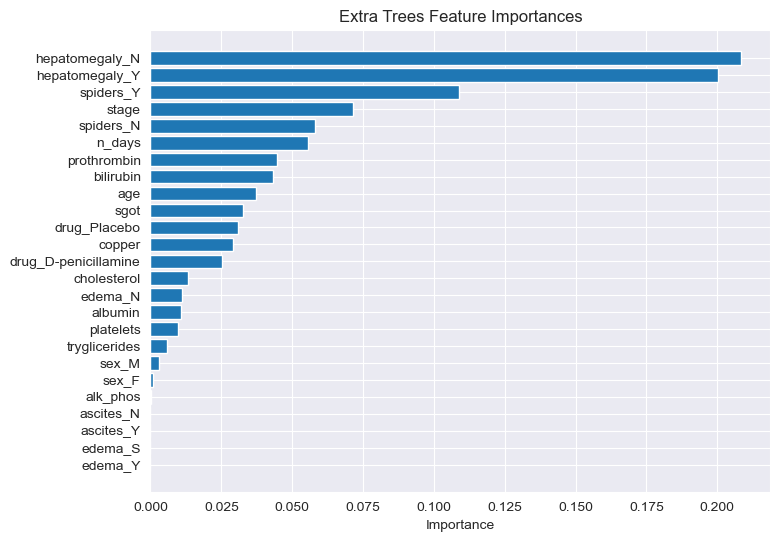

In [180]:
# Build the model
model = ExtraTreesClassifier(**trial_et.params)
model.fit(X_adasyn, y_adasyn)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance']
)
plt.xlabel('Importance')
plt.title('Extra Trees Feature Importances')
plt.gca().invert_yaxis()
plt.show()


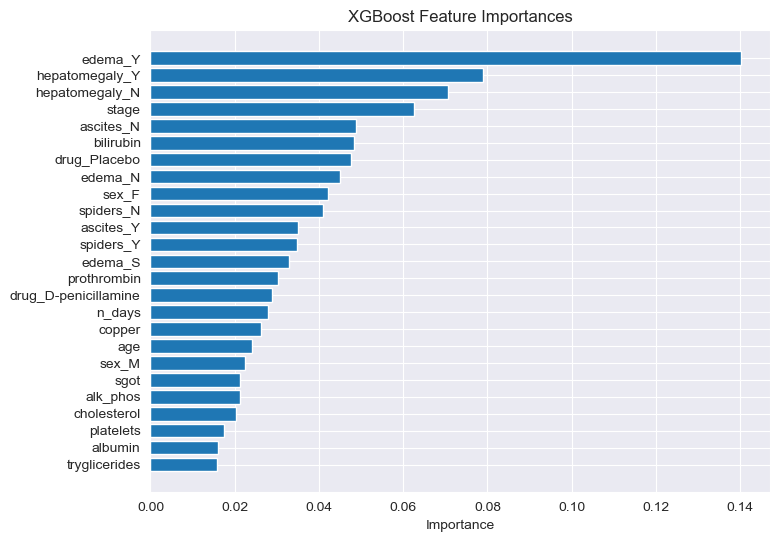

In [221]:
# Build the model
model = XGBClassifier(**trial_xgb.params)
model.fit(X_adasyn, y_adasyn)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance']
)
plt.xlabel('Importance')
plt.title('XGBoost Feature Importances')
plt.gca().invert_yaxis()
plt.show()


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.874309387231237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.874309387231237
[LightGBM] [Warning] bagging_fraction is set=0.8738245631484038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8738245631484038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.874309387231237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.874309387231237
[LightGBM] [Warning] bagging_fraction is set=0.8738245631484038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8738245631484038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

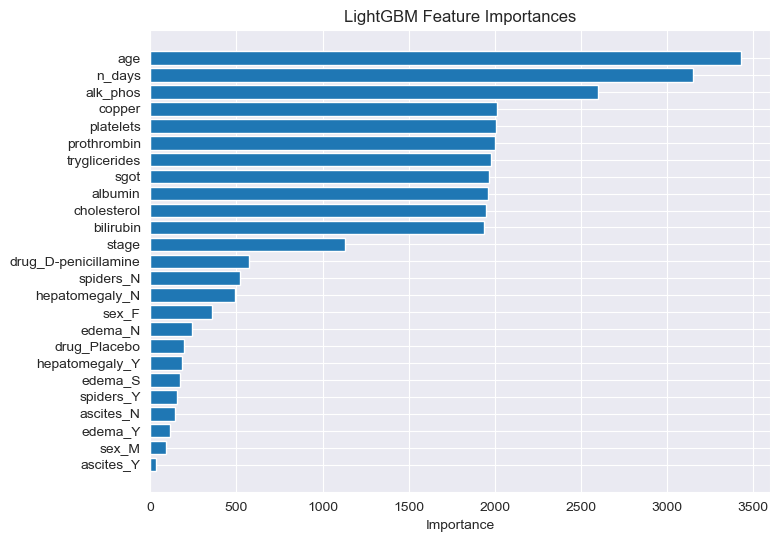

In [222]:
# Build the model
model = LGBMClassifier(**trial_lgb.params)
model.fit(X_adasyn, y_adasyn)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance']
)
plt.xlabel('Importance')
plt.title('LightGBM Feature Importances')
plt.gca().invert_yaxis()
plt.show()


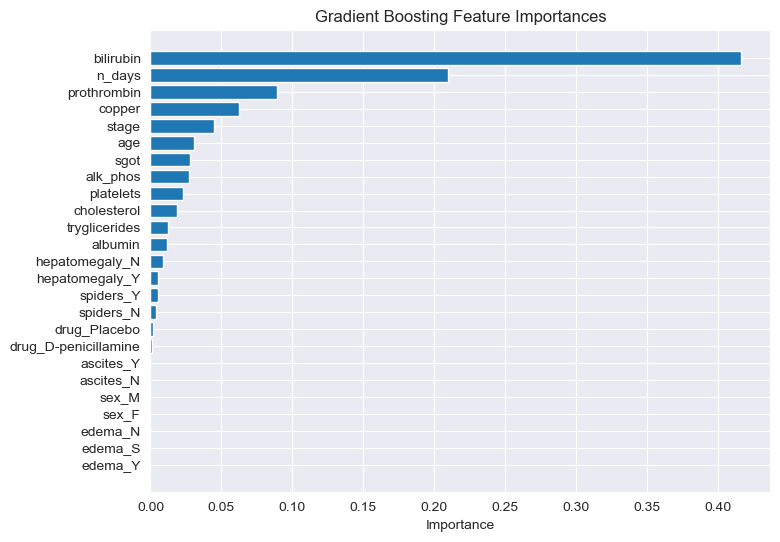

In [223]:
# Build the model
model = GradientBoostingClassifier(**trial_gb.params)
model.fit(X_train, y_train_le)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance']
)
plt.xlabel('Importance')
plt.title('Gradient Boosting Feature Importances')
plt.gca().invert_yaxis()
plt.show()


### Model Testing

We'll use the Extra Trees ADASYN oversampled model for predictions.

In [225]:
train = pd.read_csv('playground-series-s3e26/train.csv')
test = pd.read_csv('playground-series-s3e26/test.csv')
sample_sub = pd.read_csv('playground-series-s3e26/sample_submission.csv')

train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [226]:
train.head()

id  n_days             drug    age sex ascites hepatomegaly spiders edema  \
0   0     999  D-penicillamine  21532   M       N            N       N     N   
1   1    2574          Placebo  19237   F       N            N       N     N   
2   2    3428          Placebo  13727   F       N            Y       Y     Y   
3   3    2576          Placebo  18460   F       N            N       N     N   
4   4     788          Placebo  16658   F       N            Y       N     N   

   bilirubin  cholesterol  albumin  copper  alk_phos    sgot  tryglicerides  \
0        2.3        316.0     3.35   172.0    1601.0  179.80           63.0   
1        0.9        364.0     3.54    63.0    1440.0  134.85           88.0   
2        3.3        299.0     3.55   131.0    1029.0  119.35           50.0   
3        0.6        256.0     3.50    58.0    1653.0   71.30           96.0   
4        1.1        346.0     3.65    63.0    1181.0  125.55           96.0   

   platelets  prothrombin  stage status  
0      394.0          9.7    3.0      D  
1      361.0         11.0    3.0      C  
2      199.0         11.7    4.0      D  
3      269.0         10.7    3.0      C  
4      298.0         10.6    4.0      C

In [227]:
test.head()

id  n_days             drug    age sex ascites hepatomegaly spiders  \
0  7905    3839  D-penicillamine  19724   F       N            Y       N   
1  7906    2468  D-penicillamine  14975   F       N            N       N   
2  7907      51          Placebo  13149   F       N            Y       N   
3  7908    2330  D-penicillamine  20510   F       N            N       N   
4  7909    1615  D-penicillamine  21904   F       N            Y       N   

  edema  bilirubin  cholesterol  albumin  copper  alk_phos    sgot  \
0     N        1.2        546.0     3.37    65.0    1636.0  151.90   
1     N        1.1        660.0     4.22    94.0    1257.0  151.90   
2     Y        2.0        151.0     2.96    46.0     961.0   69.75   
3     N        0.6        293.0     3.85    40.0     554.0  125.55   
4     N        1.4        277.0     2.97   121.0    1110.0  125.00   

   tryglicerides  platelets  prothrombin  stage  
0           90.0      430.0         10.6    2.0  
1          155.0      227.0         10.0    2.0  
2          101.0      213.0         13.0    4.0  
3           56.0      270.0         10.6    2.0  
4          126.0      221.0          9.8    1.0

In [228]:
sample_sub.head()

id  Status_C  Status_CL  Status_D
0  7905  0.628084   0.034788  0.337128
1  7906  0.628084   0.034788  0.337128
2  7907  0.628084   0.034788  0.337128
3  7908  0.628084   0.034788  0.337128
4  7909  0.628084   0.034788  0.337128

**Prepare the Data**

In [229]:
def train_test_variables(df):
    if 'status' in df.columns:
        X = df.drop(columns='status')
    else:
        X = df.copy()

    # Transformers for numeric and categorical columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Column transformer to apply transformers to respective columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, num_cols),
            ('categorical', categorical_transformer, cat_cols)
        ])
    
    # Pipeline that includes the preprocessing steps
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])
    
    # Fit and transform the data using the pipeline
    X_transformed = pipeline.fit_transform(X)
    
    # Convert the transformed data back to a DataFrame 
    columns = num_cols.tolist() + pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols).tolist()
    
    X = pd.DataFrame(X_transformed, columns=columns)
    X[num_cols] = X[num_cols].astype(float, errors='ignore')
    
    return X

In [230]:
def encode_y_feature(df):
    y = df.status
    le = LabelEncoder()
    
    y_le = le.fit_transform(y)
    return y_le

def adasyn_sampling(X, y_le):
    X_adasyn, y_adasyn = adasyn.fit_resample(X, y_le)
    return X_adasyn, y_adasyn

In [231]:
X = train_test_variables(train)
X_test = train_test_variables(test)

y = encode_y_feature(train)

X_adasyn, y_adasyn = adasyn_sampling(X, y)

**Training & Testing**

In [232]:
et_model = ExtraTreesClassifier(**trial_et.params)
et_model.fit(X_adasyn, y_adasyn)

y_pred_proba = et_model.predict_proba(X_test)

et_adasyn = pd.DataFrame(y_pred_proba, columns=['Status_C', 'Status_CL', 'Status_D'])
et_adasyn.insert(0, 'id', test.id)

et_adasyn.head()

id  Status_C  Status_CL  Status_D
0  7905  0.313978   0.329023  0.356999
1  7906  0.458582   0.312200  0.229218
2  7907  0.287287   0.318490  0.394223
3  7908  0.507926   0.275091  0.216983
4  7909  0.313686   0.330041  0.356272

In [233]:
et_adasyn.to_csv('et_adasyn.csv', index=False)

In [234]:
gb_model = GradientBoostingClassifier(**trial_gb.params)
gb_model.fit(X, y)

y_pred_proba = gb_model.predict_proba(X_test)

gb_orig = pd.DataFrame(y_pred_proba, columns=['Status_C', 'Status_CL', 'Status_D'])
gb_orig.insert(0, 'id', test.id)

gb_orig.to_csv('gb_orig.csv', index=False)

In [235]:
xgb_model = XGBClassifier(**trial_xgb.params)
xgb_model.fit(X_adasyn, y_adasyn)

y_pred_proba = xgb_model.predict_proba(X_test)

xgb_adasyn = pd.DataFrame(y_pred_proba, columns=['Status_C', 'Status_CL', 'Status_D'])
xgb_adasyn.insert(0, 'id', test.id)

xgb_adasyn.to_csv('xgb_adasyn.csv', index=False)

In [237]:
lgbm_model = LGBMClassifier(**trial_lgb.params)
lgbm_model.fit(X_adasyn, y_adasyn)

y_pred_proba = lgbm_model.predict_proba(X_test)

lgb_adasyn = pd.DataFrame(y_pred_proba, columns=['Status_C', 'Status_CL', 'Status_D'])
lgb_adasyn.insert(0, 'id', test.id)

lgb_adasyn.to_csv('lgb_adasyn.csv', index=False)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.874309387231237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.874309387231237
[LightGBM] [Warning] bagging_fraction is set=0.8738245631484038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8738245631484038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.874309387231237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.874309387231237
[LightGBM] [Warning] bagging_fraction is set=0.8738245631484038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8738245631484038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [238]:
voting_model = VotingClassifier(estimators=[
    ('lgb',lgbm_model), ('xgb', xgb_model)], voting='soft')

voting_model.fit(X_adasyn, y_adasyn)


y_pred_proba = voting_model.predict_proba(X_test)

vm_adasyn = pd.DataFrame(y_pred_proba, columns=['Status_C', 'Status_CL', 'Status_D'])
vm_adasyn.insert(0, 'id', test.id)

vm_adasyn.to_csv('vm_adasyn.csv', index=False)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.874309387231237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.874309387231237
[LightGBM] [Warning] bagging_fraction is set=0.8738245631484038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8738245631484038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.874309387231237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.874309387231237
[LightGBM] [Warning] bagging_fraction is set=0.8738245631484038, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8738245631484038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 